In [43]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"


In [44]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

In [45]:
import os

random_results_folder = "NEW_CORR_KNN_random_results"
kmeans_class_results_folder = "NEW_CORR_KNN_kmeans_class_results"

def get_folders(directory):
    return set(name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name)))


random_folders = get_folders(random_results_folder)
kmeans_folders = get_folders(kmeans_class_results_folder)
common_folders = random_folders.intersection(kmeans_folders)

common_folders = {'breast','ionosphere',
 'iris',
 'lrs',
 'vertebral_column',
 } | {'ecoli', 'glass', 'seeds','algerian_forest_fires'}

common_folder_paths = {
    "NEW_CORR_KNN_random_results": {os.path.join(random_results_folder, folder): [] for folder in common_folders},
    "NEW_CORR_KNN_kmeans_class_results": {os.path.join(kmeans_class_results_folder, folder) :[] for folder in common_folders},
}



In [46]:
import os
import glob
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from IPython.display import clear_output

# Function to load and concatenate datasets from a folder with filtering
def load_and_concatenate_filtered(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))  # Get CSV files
    if not csv_files:
        return None  # Return None if no files found
    
    filtered_dfs = []
    
    for file in csv_files:
        df = pd.read_csv(file)  # Load full dataset
        if not df.empty:
            filtered_dfs.append(df)
    
    return pd.concat(filtered_dfs, ignore_index=True) if filtered_dfs else None

# Function to process a single folder
def process_folder(experiment_name, folder):
    dataset_name = os.path.basename(folder)  # Get dataset name
    df = load_and_concatenate_filtered(folder)  # Load & filter data

    if df is not None:
        # Ensure the required columns exist before applying conditions
        if {'fix_feature', 'fix_threshold'}.issubset(df.columns):
            df['type_of_split'] = np.select(
                [
                    (~df['fix_feature']) & (~df['fix_threshold']),
                    (df['fix_feature']) & (~df['fix_threshold']),
                    (df['fix_feature']) & (df['fix_threshold'])
                ],
                ['free', 'fix_feat', 'fix_thr'],
                default='unknown'
            )

        return experiment_name, dataset_name, df  # Return tuple of results
    
    return experiment_name, dataset_name, None  # Return None if no data

# Combine original and additional common folder paths
common_folder_paths = {
    "NEW_CORR_KNN_random_results": {os.path.join("NEW_CORR_KNN_random_results", folder): [] for folder in common_folders},
    "NEW_CORR_KNN_kmeans_class_results": {os.path.join("NEW_CORR_KNN_kmeans_class_results", folder): [] for folder in common_folders},
}


# Dictionary to store experiment results
experiment_results = {}

# Use multiprocessing for parallel execution
with ProcessPoolExecutor() as executor:
    futures = []
    
    for experiment_name, folders in common_folder_paths.items():
        print(f"Processing experiment: {experiment_name}")
        experiment_results[experiment_name] = {}  # Initialize dictionary

        # Submit each folder processing as a parallel task
        for folder in folders:
            futures.append(executor.submit(process_folder, experiment_name, folder))

    # Collect results as they complete
    for future in as_completed(futures):
        experiment_name, dataset_name, df = future.result()
        if df is not None:
            df['type_of_exp'] = experiment_name
            experiment_results[experiment_name][dataset_name] = df
            print(f"Processed {dataset_name} → {df.shape[0]} rows, {df.shape[1]} columns.")
        else:
            print(f"No valid datasets found in {dataset_name}.")

clear_output()


In [47]:
import re
for k, v in experiment_results['NEW_CORR_KNN_kmeans_class_results'].items():
    # Drop columns that match the pattern 'kmeans_fit_time_{number}' or 'selection_time_{number}'
    columns_to_drop = [col for col in v.columns if re.match(r'^(kmeans_fit_time_\d+|selection_time_\d+)$', col)]
    v.drop(columns=columns_to_drop, inplace=True)


In [48]:
def aggregate_results(df):
    # Filter relevant rows for the absolute_diff types at the beginning
    valid_splits = ['original_feat', 'only_difference', 'both_original_and_diff']
    df_filtered = df[df['absolute_diff'].isin(valid_splits)]
    
    numeric_cols = df_filtered.select_dtypes(include=['number']).columns.tolist()
    
    # Group by the necessary columns (excluding numeric ones)
    group_cols = ['type_of_exp', 'absolute_diff', 'dataset_name','dataset_type', 'perc', 'max_depth', 
                  'fix_feature', 'fix_threshold', 'type_of_split', 
                  'train_test_case', 'n_neighbors']
    
    grouped = df_filtered.groupby(group_cols)[numeric_cols].agg(['mean', 'std']).reset_index()
    
    grouped.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped.columns.values]
    
    return grouped


In [49]:
for k, v in experiment_results.items():
    for k_1, v_1 in v.items():
        experiment_results[k][k_1] = aggregate_results(v_1)
        experiment_results[k][k_1]['type_of_exp'] = k
        

In [50]:
full_exps_results_rand = pd.concat([v for k, v in experiment_results['NEW_CORR_KNN_random_results'].items()] +
                                  [v for k, v in experiment_results['NEW_CORR_KNN_kmeans_class_results'].items()])


In [51]:
full_exps_results_rand

type_of_exp_          absolute_diff_ dataset_name_  \
0           NEW_CORR_KNN_random_results  both_original_and_diff           lrs   
1           NEW_CORR_KNN_random_results  both_original_and_diff           lrs   
2           NEW_CORR_KNN_random_results  both_original_and_diff           lrs   
3           NEW_CORR_KNN_random_results  both_original_and_diff           lrs   
4           NEW_CORR_KNN_random_results  both_original_and_diff           lrs   
...                                 ...                     ...           ...   
1021  NEW_CORR_KNN_kmeans_class_results           original_feat           lrs   
1022  NEW_CORR_KNN_kmeans_class_results           original_feat           lrs   
1023  NEW_CORR_KNN_kmeans_class_results           original_feat           lrs   
1024  NEW_CORR_KNN_kmeans_class_results           original_feat           lrs   
1025  NEW_CORR_KNN_kmeans_class_results           original_feat           lrs   

     dataset_type_  perc_  max_depth_  fix_feature_  fix_threshold_  \
0     full_dataset   0.01           2         False           False   
1     full_dataset   0.01           2          True           False   
2     full_dataset   0.01           2          True            True   
3     full_dataset   0.01           4         False           False   
4     full_dataset   0.01           4          True           False   
...            ...    ...         ...           ...             ...   
1021  full_dataset   1.00          32          True           False   
1022  full_dataset   1.00          32          True            True   
1023  full_dataset   1.00          64         False           False   
1024  full_dataset   1.00          64          True           False   
1025  full_dataset   1.00          64          True            True   

     type_of_split_        train_test_case_  n_neighbors_  random_seed_mean  \
0              free  train_test_r1_r2_r1_r2             5               4.5   
1          fix_feat  train_test_r1_r2_r1_r2             5               4.5   
2           fix_thr  train_test_r1_r2_r1_r2             5               4.5   
3              free  train_test_r1_r2_r1_r2             5               4.5   
4          fix_feat  train_test_r1_r2_r1_r2             5               4.5   
...             ...                     ...           ...               ...   
1021       fix_feat  train_test_r1_r2_r1_r2             5               4.5   
1022        fix_thr  train_test_r1_r2_r1_r2             5               4.5   
1023           free  train_test_r1_r2_r1_r2             5               4.5   
1024       fix_feat  train_test_r1_r2_r1_r2             5               4.5   
1025        fix_thr  train_test_r1_r2_r1_r2             5               4.5   

      random_seed_std  perc_mean  perc_std  sample_size_mean  sample_size_std  \
0             3.02765       0.01       0.0               5.0              0.0   
1             3.02765       0.01       0.0               5.0              0.0   
2             3.02765       0.01       0.0               5.0              0.0   
3             3.02765       0.01       0.0               5.0              0.0   
4             3.02765       0.01       0.0               5.0              0.0   
...               ...        ...       ...               ...              ...   
1021          3.02765       1.00       0.0             424.0              0.0   
1022          3.02765       1.00       0.0             424.0              0.0   
1023          3.02765       1.00       0.0             424.0              0.0   
1024          3.02765       1.00       0.0             424.0              0.0   
1025          3.02765       1.00       0.0             424.0              0.0   

      selection_time_wall_mean  selection_time_wall_std  \
0                     0.000052                 0.000004   
1                     0.000052                 0.000004   
2                     0.000052                 0.000004   
3                     0.000052             

In [52]:
full_exps_results_rand = full_exps_results_rand.drop(columns = ['dataset_name_'])
full_exps_results_rand

type_of_exp_          absolute_diff_ dataset_type_  \
0           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
1           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
2           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
3           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
4           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
...                                 ...                     ...           ...   
1021  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1022  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1023  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1024  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1025  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   

      perc_  max_depth_  fix_feature_  fix_threshold_ type_of_split_  \
0      0.01           2         False           False           free   
1      0.01           2          True           False       fix_feat   
2      0.01           2          True            True        fix_thr   
3      0.01           4         False           False           free   
4      0.01           4          True           False       fix_feat   
...     ...         ...           ...             ...            ...   
1021   1.00          32          True           False       fix_feat   
1022   1.00          32          True            True        fix_thr   
1023   1.00          64         False           False           free   
1024   1.00          64          True           False       fix_feat   
1025   1.00          64          True            True        fix_thr   

            train_test_case_  n_neighbors_  random_seed_mean  random_seed_std  \
0     train_test_r1_r2_r1_r2             5               4.5          3.02765   
1     train_test_r1_r2_r1_r2             5               4.5          3.02765   
2     train_test_r1_r2_r1_r2             5               4.5          3.02765   
3     train_test_r1_r2_r1_r2             5               4.5          3.02765   
4     train_test_r1_r2_r1_r2             5               4.5          3.02765   
...                      ...           ...               ...              ...   
1021  train_test_r1_r2_r1_r2             5               4.5          3.02765   
1022  train_test_r1_r2_r1_r2             5               4.5          3.02765   
1023  train_test_r1_r2_r1_r2             5               4.5          3.02765   
1024  train_test_r1_r2_r1_r2             5               4.5          3.02765   
1025  train_test_r1_r2_r1_r2             5               4.5          3.02765   

      perc_mean  perc_std  sample_size_mean  sample_size_std  \
0          0.01       0.0               5.0              0.0   
1          0.01       0.0               5.0              0.0   
2          0.01       0.0               5.0              0.0   
3          0.01       0.0               5.0              0.0   
4          0.01       0.0               5.0              0.0   
...         ...       ...               ...              ...   
1021       1.00       0.0             424.0              0.0   
1022       1.00       0.0             424.0              0.0   
1023       1.00       0.0             424.0              0.0   
1024       1.00       0.0             424.0              0.0   
1025       1.00       0.0             424.0              0.0   

      selection_time_wall_mean  selection_time_wall_std  \
0                     0.000052                 0.000004   
1                     0.000052                 0.000004   
2                     0.000052                 0.000004   
3                     0.000052                 0.000004   
4                     0.000052                 0.000004   
...                        ...                      ...   
1021                  0.000000    

In [53]:
# Define the dictionaries
dict_abs = {
    'both_original_and_diff': 'Feat. + Dist.', 
    'only_difference': 'Dist.', 
    'original_feat': 'Feat.'
}

dict_type_of_exp = {
    'kmeans_class_results': 'k-Means', 
    'random_results': 'Rand.', 
    'stratrand_results': 'Str. Rand.'
}

dict_type_of_split_ = {
    'fix_thr': 'Fix Thr.', 
    'fix_feat': 'Fix Feat.', 
    'free': 'Standard'
}


In [54]:
full_exps_results_rand

type_of_exp_          absolute_diff_ dataset_type_  \
0           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
1           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
2           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
3           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
4           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
...                                 ...                     ...           ...   
1021  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1022  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1023  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1024  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1025  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   

      perc_  max_depth_  fix_feature_  fix_threshold_ type_of_split_  \
0      0.01           2         False           False           free   
1      0.01           2          True           False       fix_feat   
2      0.01           2          True            True        fix_thr   
3      0.01           4         False           False           free   
4      0.01           4          True           False       fix_feat   
...     ...         ...           ...             ...            ...   
1021   1.00          32          True           False       fix_feat   
1022   1.00          32          True            True        fix_thr   
1023   1.00          64         False           False           free   
1024   1.00          64          True           False       fix_feat   
1025   1.00          64          True            True        fix_thr   

            train_test_case_  n_neighbors_  random_seed_mean  random_seed_std  \
0     train_test_r1_r2_r1_r2             5               4.5          3.02765   
1     train_test_r1_r2_r1_r2             5               4.5          3.02765   
2     train_test_r1_r2_r1_r2             5               4.5          3.02765   
3     train_test_r1_r2_r1_r2             5               4.5          3.02765   
4     train_test_r1_r2_r1_r2             5               4.5          3.02765   
...                      ...           ...               ...              ...   
1021  train_test_r1_r2_r1_r2             5               4.5          3.02765   
1022  train_test_r1_r2_r1_r2             5               4.5          3.02765   
1023  train_test_r1_r2_r1_r2             5               4.5          3.02765   
1024  train_test_r1_r2_r1_r2             5               4.5          3.02765   
1025  train_test_r1_r2_r1_r2             5               4.5          3.02765   

      perc_mean  perc_std  sample_size_mean  sample_size_std  \
0          0.01       0.0               5.0              0.0   
1          0.01       0.0               5.0              0.0   
2          0.01       0.0               5.0              0.0   
3          0.01       0.0               5.0              0.0   
4          0.01       0.0               5.0              0.0   
...         ...       ...               ...              ...   
1021       1.00       0.0             424.0              0.0   
1022       1.00       0.0             424.0              0.0   
1023       1.00       0.0             424.0              0.0   
1024       1.00       0.0             424.0              0.0   
1025       1.00       0.0             424.0              0.0   

      selection_time_wall_mean  selection_time_wall_std  \
0                     0.000052                 0.000004   
1                     0.000052                 0.000004   
2                     0.000052                 0.000004   
3                     0.000052                 0.000004   
4                     0.000052                 0.000004   
...                        ...                      ...   
1021                  0.000000    

In [55]:
def selectsubset(full_exps_results_rand, 
                 measure_mean = 'PairDistTree_predict_on_test_time_process_mean',
                 measure_std = 'PairDistTree_predict_on_test_time_process_std',
                 ):
    cols = ['type_of_exp_', 'absolute_diff_', 'dataset_type_', 'perc_',
       'max_depth_', 'fix_feature_', 'fix_threshold_', 'type_of_split_',
       'train_test_case_', 'n_neighbors_']
    
    cols += [measure_mean,measure_std]

    
    full_exps_results_rand_subset = full_exps_results_rand[cols]
    return full_exps_results_rand_subset

In [56]:
measure_mean, measure_std = 'KNN_measure_test_f1_weighted_mean', 'KNN_measure_test_f1_weighted_std'
subsets_full_exps_f1 = selectsubset(full_exps_results_rand, measure_mean, measure_std)


In [57]:
measure_mean, measure_std = 'PairDistTree_measure_test_r2_mean', 'PairDistTree_measure_test_r2_std'
subsets_full_exps_r2 = selectsubset(full_exps_results_rand, measure_mean, measure_std)
subsets_full_exps_r2

type_of_exp_          absolute_diff_ dataset_type_  \
0           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
1           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
2           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
3           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
4           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
...                                 ...                     ...           ...   
1021  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1022  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1023  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1024  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1025  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   

      perc_  max_depth_  fix_feature_  fix_threshold_ type_of_split_  \
0      0.01           2         False           False           free   
1      0.01           2          True           False       fix_feat   
2      0.01           2          True            True        fix_thr   
3      0.01           4         False           False           free   
4      0.01           4          True           False       fix_feat   
...     ...         ...           ...             ...            ...   
1021   1.00          32          True           False       fix_feat   
1022   1.00          32          True            True        fix_thr   
1023   1.00          64         False           False           free   
1024   1.00          64          True           False       fix_feat   
1025   1.00          64          True            True        fix_thr   

            train_test_case_  n_neighbors_  PairDistTree_measure_test_r2_mean  \
0     train_test_r1_r2_r1_r2             5                          -0.324552   
1     train_test_r1_r2_r1_r2             5                          -0.324552   
2     train_test_r1_r2_r1_r2             5                          -0.324552   
3     train_test_r1_r2_r1_r2             5                          -0.313142   
4     train_test_r1_r2_r1_r2             5                          -0.313142   
...                      ...           ...                                ...   
1021  train_test_r1_r2_r1_r2             5                           0.888547   
1022  train_test_r1_r2_r1_r2             5                           0.865546   
1023  train_test_r1_r2_r1_r2             5                           0.885902   
1024  train_test_r1_r2_r1_r2             5                           0.888230   
1025  train_test_r1_r2_r1_r2             5                           0.865672   

      PairDistTree_measure_test_r2_std  
0                             0.310631  
1                             0.310631  
2                             0.310631  
3                             0.290064  
4                             0.290064  
...                                ...  
1021                          0.000000  
1022                          0.000000  
1023                          0.000000  
1024                          0.000000  
1025                          0.000000  

[18468 rows x 12 columns]

In [58]:
import pandas as pd

# Define the columns to group by
groupby_columns = [
    'type_of_exp_', 'absolute_diff_', 'dataset_type_', 'perc_', 
    'max_depth_', 'fix_feature_', 'fix_threshold_', 'type_of_split_', 
    'train_test_case_', 'n_neighbors_'
]

# Group by the selected columns and compute mean and std only for numeric columns
grouped_df_f1 = subsets_full_exps_f1.groupby(groupby_columns).agg(['mean', 'std'])
grouped_df_r2 = subsets_full_exps_r2.groupby(groupby_columns).agg(['mean', 'std'])


# Flatten MultiIndex columns for a cleaner DataFrame
grouped_df_f1.columns = ['_'.join(col).strip() for col in grouped_df_f1.columns] 
grouped_df_r2.columns = ['_'.join(col).strip() for col in grouped_df_r2.columns] 

# Reset index to turn grouped columns into normal columns
grouped_df_f1 = grouped_df_f1.reset_index()
grouped_df_r2 = grouped_df_r2.reset_index()

grouped_df_r2


type_of_exp_          absolute_diff_ dataset_type_  \
0     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
1     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
2     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
3     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
4     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
...                                 ...                     ...           ...   
2047        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2048        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2049        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2050        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2051        NEW_CORR_KNN_random_results           original_feat  full_dataset   

      perc_  max_depth_  fix_feature_  fix_threshold_ type_of_split_  \
0      0.01           2         False           False           free   
1      0.01           2          True           False       fix_feat   
2      0.01           2          True            True        fix_thr   
3      0.01           4         False           False           free   
4      0.01           4          True           False       fix_feat   
...     ...         ...           ...             ...            ...   
2047   1.00          32          True           False       fix_feat   
2048   1.00          32          True            True        fix_thr   
2049   1.00          64         False           False           free   
2050   1.00          64          True           False       fix_feat   
2051   1.00          64          True            True        fix_thr   

            train_test_case_  n_neighbors_  \
0     train_test_r1_r2_r1_r2             5   
1     train_test_r1_r2_r1_r2             5   
2     train_test_r1_r2_r1_r2             5   
3     train_test_r1_r2_r1_r2             5   
4     train_test_r1_r2_r1_r2             5   
...                      ...           ...   
2047  train_test_r1_r2_r1_r2             5   
2048  train_test_r1_r2_r1_r2             5   
2049  train_test_r1_r2_r1_r2             5   
2050  train_test_r1_r2_r1_r2             5   
2051  train_test_r1_r2_r1_r2             5   

      PairDistTree_measure_test_r2_mean_mean  \
0                                  -0.106889   
1                                  -0.106889   
2                                  -0.106889   
3                                  -0.029205   
4                                  -0.029205   
...                                      ...   
2047                                0.754170   
2048                                0.709730   
2049                                0.766745   
2050                                0.754364   
2051                                0.710304   

      PairDistTree_measure_test_r2_mean_std  \
0                                  0.496592   
1                                  0.496592   
2                                  0.496592   
3                                  0.521261   
4                                  0.521261   
...                                     ...   
2047                               0.132347   
2048                               0.115161   
2049                               0.127111   
2050                               0.132383   
2051                               0.114730   

      PairDistTree_measure_test_r2_std_mean  \
0                                  0.122604   
1                                  0.122604   
2                                  0.122604   
3                                  0.123774   
4                                  0.123774   
...                                     ...   
2047                               0.000000   
2048                               0.000000   
2049                               0.000000   
2050                    

### Sensitivity table

In [59]:
# Define mapping of conditions to model names
mapping = {
    ("original_feat", "free"): "PDT-αP",
    ("original_feat", "fix_feat"): "PDT-αF",
    ("original_feat", "fix_thr"): "PDT-αT",
    ("only_difference", "free"): "PDT-βP",
    ("only_difference", "fix_feat"): "PDT-βF",
    ("only_difference", "fix_thr"): "PDT-βT",
    ("both_original_and_diff", "free"): "PDT-γP",
    ("both_original_and_diff", "fix_feat"): "PDT-γF",
    ("both_original_and_diff", "fix_thr"): "PDT-γT",
}



tab_sensitivit = grouped_df_r2
tab_sensitivit = tab_sensitivit[tab_sensitivit['dataset_type_'] == 'full_dataset']
tab_sensitivit = tab_sensitivit[tab_sensitivit['max_depth_'] == 8]
tab_sensitivit = tab_sensitivit[tab_sensitivit['perc_'] == 1.0]
shortt = tab_sensitivit[['type_of_exp_','absolute_diff_','type_of_split_','PairDistTree_measure_test_r2_mean_mean','PairDistTree_measure_test_r2_mean_std']]


In [60]:
shortt

type_of_exp_          absolute_diff_  \
330   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
331   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
332   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
672   NEW_CORR_KNN_kmeans_class_results         only_difference   
673   NEW_CORR_KNN_kmeans_class_results         only_difference   
674   NEW_CORR_KNN_kmeans_class_results         only_difference   
1014  NEW_CORR_KNN_kmeans_class_results           original_feat   
1015  NEW_CORR_KNN_kmeans_class_results           original_feat   
1016  NEW_CORR_KNN_kmeans_class_results           original_feat   
1356        NEW_CORR_KNN_random_results  both_original_and_diff   
1357        NEW_CORR_KNN_random_results  both_original_and_diff   
1358        NEW_CORR_KNN_random_results  both_original_and_diff   
1698        NEW_CORR_KNN_random_results         only_difference   
1699        NEW_CORR_KNN_random_results         only_difference   
1700        NEW_CORR_KNN_random_results         only_difference   
2040        NEW_CORR_KNN_random_results           original_feat   
2041        NEW_CORR_KNN_random_results           original_feat   
2042        NEW_CORR_KNN_random_results           original_feat   

     type_of_split_  PairDistTree_measure_test_r2_mean_mean  \
330            free                                0.907002   
331        fix_feat                                0.906653   
332         fix_thr                                0.906708   
672            free                                0.908540   
673        fix_feat                                0.908540   
674         fix_thr                                0.908540   
1014           free                                0.659512   
1015       fix_feat                                0.651785   
1016        fix_thr                                0.631186   
1356           free                                0.907002   
1357       fix_feat                                0.906653   
1358        fix_thr                                0.906708   
1698           free                                0.908540   
1699       fix_feat                                0.908540   
1700        fix_thr                                0.908540   
2040           free                                0.659512   
2041       fix_feat                                0.651785   
2042        fix_thr                                0.631186   

      PairDistTree_measure_test_r2_mean_std  
330                                0.058582  
331                                0.059120  
332                                0.059122  
672                                0.055976  
673                                0.055976  
674                                0.055976  
1014                               0.137571  
1015                               0.136712  
1016                               0.132641  
1356                               0.058582  
1357                               0.059120  
1358                               0.059122  
1698                               0.055976  
1699                               0.055976  
1700                               0.055976  
2040                               0.137571  
2041                               0.136712  
2042                               0.132641

In [61]:
table_ = shortt[shortt['type_of_exp_'] == 'NEW_CORR_KNN_kmeans_class_results']


# Apply the mapping to create the "model_name" column
table_["model_name"] = table_.apply(
    lambda row: mapping.get((row['absolute_diff_'], row['type_of_split_']), 'Unknown'), axis=1
)

# Display the updated DataFrame
table_


/tmp/ipykernel_1985414/638525692.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_["model_name"] = table_.apply(


type_of_exp_          absolute_diff_  \
330   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
331   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
332   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
672   NEW_CORR_KNN_kmeans_class_results         only_difference   
673   NEW_CORR_KNN_kmeans_class_results         only_difference   
674   NEW_CORR_KNN_kmeans_class_results         only_difference   
1014  NEW_CORR_KNN_kmeans_class_results           original_feat   
1015  NEW_CORR_KNN_kmeans_class_results           original_feat   
1016  NEW_CORR_KNN_kmeans_class_results           original_feat   

     type_of_split_  PairDistTree_measure_test_r2_mean_mean  \
330            free                                0.907002   
331        fix_feat                                0.906653   
332         fix_thr                                0.906708   
672            free                                0.908540   
673        fix_feat                                0.908540   
674         fix_thr                                0.908540   
1014           free                                0.659512   
1015       fix_feat                                0.651785   
1016        fix_thr                                0.631186   

      PairDistTree_measure_test_r2_mean_std model_name  
330                                0.058582     PDT-γP  
331                                0.059120     PDT-γF  
332                                0.059122     PDT-γT  
672                                0.055976     PDT-βP  
673                                0.055976     PDT-βF  
674                                0.055976     PDT-βT  
1014                               0.137571     PDT-αP  
1015                               0.136712     PDT-αF  
1016                               0.132641     PDT-αT

In [62]:
grouped_df_f1

type_of_exp_          absolute_diff_ dataset_type_  \
0     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
1     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
2     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
3     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
4     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
...                                 ...                     ...           ...   
2047        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2048        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2049        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2050        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2051        NEW_CORR_KNN_random_results           original_feat  full_dataset   

      perc_  max_depth_  fix_feature_  fix_threshold_ type_of_split_  \
0      0.01           2         False           False           free   
1      0.01           2          True           False       fix_feat   
2      0.01           2          True            True        fix_thr   
3      0.01           4         False           False           free   
4      0.01           4          True           False       fix_feat   
...     ...         ...           ...             ...            ...   
2047   1.00          32          True           False       fix_feat   
2048   1.00          32          True            True        fix_thr   
2049   1.00          64         False           False           free   
2050   1.00          64          True           False       fix_feat   
2051   1.00          64          True            True        fix_thr   

            train_test_case_  n_neighbors_  \
0     train_test_r1_r2_r1_r2             5   
1     train_test_r1_r2_r1_r2             5   
2     train_test_r1_r2_r1_r2             5   
3     train_test_r1_r2_r1_r2             5   
4     train_test_r1_r2_r1_r2             5   
...                      ...           ...   
2047  train_test_r1_r2_r1_r2             5   
2048  train_test_r1_r2_r1_r2             5   
2049  train_test_r1_r2_r1_r2             5   
2050  train_test_r1_r2_r1_r2             5   
2051  train_test_r1_r2_r1_r2             5   

      KNN_measure_test_f1_weighted_mean_mean  \
0                                   0.654921   
1                                   0.654921   
2                                   0.654921   
3                                   0.670526   
4                                   0.670526   
...                                      ...   
2047                                0.826191   
2048                                0.821896   
2049                                0.853173   
2050                                0.830449   
2051                                0.823353   

      KNN_measure_test_f1_weighted_mean_std  \
0                                  0.121339   
1                                  0.121339   
2                                  0.121339   
3                                  0.127677   
4                                  0.127677   
...                                     ...   
2047                               0.131971   
2048                               0.130451   
2049                               0.106475   
2050                               0.130106   
2051                               0.121336   

      KNN_measure_test_f1_weighted_std_mean  \
0                                  0.043103   
1                                  0.043103   
2                                  0.043103   
3                                  0.045509   
4                                  0.045509   
...                                     ...   
2047                               0.000000   
2048                               0.000000   
2049                               0.000000   
2050                    

In [63]:
tab_sensitivit = grouped_df_f1
tab_sensitivit = tab_sensitivit[tab_sensitivit['dataset_type_'] == 'full_dataset']
tab_sensitivit = tab_sensitivit[tab_sensitivit['max_depth_'] == 8]
tab_sensitivit = tab_sensitivit[tab_sensitivit['perc_'] == 1.0]
shortt = tab_sensitivit[['type_of_exp_','absolute_diff_','type_of_split_','KNN_measure_test_f1_weighted_mean_mean','KNN_measure_test_f1_weighted_mean_std']]


In [64]:
table_ = shortt[shortt['type_of_exp_'] == 'NEW_CORR_KNN_kmeans_class_results']


# Apply the mapping to create the "model_name" column
table_["model_name"] = table_.apply(
    lambda row: mapping.get((row['absolute_diff_'], row['type_of_split_']), 'Unknown'), axis=1
)

# Display the updated DataFrame
table_


/tmp/ipykernel_1985414/638525692.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_["model_name"] = table_.apply(


type_of_exp_          absolute_diff_  \
330   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
331   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
332   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
672   NEW_CORR_KNN_kmeans_class_results         only_difference   
673   NEW_CORR_KNN_kmeans_class_results         only_difference   
674   NEW_CORR_KNN_kmeans_class_results         only_difference   
1014  NEW_CORR_KNN_kmeans_class_results           original_feat   
1015  NEW_CORR_KNN_kmeans_class_results           original_feat   
1016  NEW_CORR_KNN_kmeans_class_results           original_feat   

     type_of_split_  KNN_measure_test_f1_weighted_mean_mean  \
330            free                                0.800258   
331        fix_feat                                0.800258   
332         fix_thr                                0.800258   
672            free                                0.799306   
673        fix_feat                                0.799306   
674         fix_thr                                0.799306   
1014           free                                0.654425   
1015       fix_feat                                0.656405   
1016        fix_thr                                0.607345   

      KNN_measure_test_f1_weighted_mean_std model_name  
330                                0.143703     PDT-γP  
331                                0.143703     PDT-γF  
332                                0.143703     PDT-γT  
672                                0.142830     PDT-βP  
673                                0.142830     PDT-βF  
674                                0.142830     PDT-βT  
1014                               0.126019     PDT-αP  
1015                               0.161359     PDT-αF  
1016                               0.210073     PDT-αT

### Save results for plots

In [65]:
import pandas as pd

def create_f1_matrix(grouped_df, type_of_exp, absolute_diff, dataset_type, type_of_split, mean_measure, mean_std):
    """
    Creates a DataFrame where:
    - Rows: 'perc_' values
    - Columns: 'max_depth_' values
    - Values: 'KNN_measure_test_f1_weighted_mean_mean' and 'KNN_measure_test_f1_weighted_std_mean'

    Filters data based on type_of_exp_, absolute_diff_, dataset_type_, and type_of_split_.

    Parameters:
    - grouped_df: DataFrame containing grouped results
    - type_of_exp: Value for 'type_of_exp_'
    - absolute_diff: Value for 'absolute_diff_'
    - dataset_type: Value for 'dataset_type_'
    - type_of_split: Value for 'type_of_split_'

    Returns:
    - Two DataFrames (mean & std), with 'perc_' as the index
    """

    # Filter dataframe based on input conditions
    filtered_df = grouped_df[
        (grouped_df['type_of_exp_'] == type_of_exp) &
        (grouped_df['absolute_diff_'] == absolute_diff) &
        (grouped_df['dataset_type_'] == dataset_type) &
        (grouped_df['type_of_split_'] == type_of_split)
    ]

    # Pivot tables to create the matrix format
    f1_matrix = filtered_df.pivot(index='perc_', columns='max_depth_', values= mean_measure )
    std_matrix = filtered_df.pivot(index='perc_', columns='max_depth_', values= mean_std )

    # Convert pivot tables to normal DataFrame and set 'perc_' as index
    f1_matrix = f1_matrix.reset_index().set_index('perc_')
    std_matrix = std_matrix.reset_index().set_index('perc_')

    # Add metadata columns
    f1_matrix.insert(0, 'type_of_exp_', type_of_exp)
    f1_matrix.insert(1, 'absolute_diff_', absolute_diff)
    f1_matrix.insert(2, 'dataset_type_', dataset_type)
    f1_matrix.insert(3, 'type_of_split_', type_of_split)

    std_matrix.insert(0, 'type_of_exp_', type_of_exp)
    std_matrix.insert(1, 'absolute_diff_', absolute_diff)
    std_matrix.insert(2, 'dataset_type_', dataset_type)
    std_matrix.insert(3, 'type_of_split_', type_of_split)

    return f1_matrix, std_matrix

# Example usage:
# f1_matrix, std_matrix = create_f1_matrix(grouped_df, 'exp1', 0.1, 'datasetA', 'split1')
# print(f1_matrix)
# print(std_matrix)


In [66]:
measure_mean, measure_std = 'PairDistTree_measure_test_r2_mean', 'PairDistTree_measure_test_r2_std'
subsets_full_exps_r2 = selectsubset(full_exps_results_rand, measure_mean, measure_std)

measure_mean, measure_std = 'KNN_measure_test_f1_weighted_mean', 'KNN_measure_test_f1_weighted_std'
subsets_full_exps_f1 = selectsubset(full_exps_results_rand, measure_mean, measure_std)

measure_mean, measure_std = 'PairDistTree_train_time_process_mean', 'PairDistTree_train_time_process_std'
subsets_full_exps_train_time = selectsubset(full_exps_results_rand, measure_mean, measure_std)

measure_mean, measure_std = 'PairDistTree_predict_on_test_time_process_mean', 'PairDistTree_predict_on_test_time_process_std'
subsets_full_exps_test_time = selectsubset(full_exps_results_rand, measure_mean, measure_std)

In [67]:
subsets_full_exps_r2

type_of_exp_          absolute_diff_ dataset_type_  \
0           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
1           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
2           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
3           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
4           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
...                                 ...                     ...           ...   
1021  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1022  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1023  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1024  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1025  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   

      perc_  max_depth_  fix_feature_  fix_threshold_ type_of_split_  \
0      0.01           2         False           False           free   
1      0.01           2          True           False       fix_feat   
2      0.01           2          True            True        fix_thr   
3      0.01           4         False           False           free   
4      0.01           4          True           False       fix_feat   
...     ...         ...           ...             ...            ...   
1021   1.00          32          True           False       fix_feat   
1022   1.00          32          True            True        fix_thr   
1023   1.00          64         False           False           free   
1024   1.00          64          True           False       fix_feat   
1025   1.00          64          True            True        fix_thr   

            train_test_case_  n_neighbors_  PairDistTree_measure_test_r2_mean  \
0     train_test_r1_r2_r1_r2             5                          -0.324552   
1     train_test_r1_r2_r1_r2             5                          -0.324552   
2     train_test_r1_r2_r1_r2             5                          -0.324552   
3     train_test_r1_r2_r1_r2             5                          -0.313142   
4     train_test_r1_r2_r1_r2             5                          -0.313142   
...                      ...           ...                                ...   
1021  train_test_r1_r2_r1_r2             5                           0.888547   
1022  train_test_r1_r2_r1_r2             5                           0.865546   
1023  train_test_r1_r2_r1_r2             5                           0.885902   
1024  train_test_r1_r2_r1_r2             5                           0.888230   
1025  train_test_r1_r2_r1_r2             5                           0.865672   

      PairDistTree_measure_test_r2_std  
0                             0.310631  
1                             0.310631  
2                             0.310631  
3                             0.290064  
4                             0.290064  
...                                ...  
1021                          0.000000  
1022                          0.000000  
1023                          0.000000  
1024                          0.000000  
1025                          0.000000  

[18468 rows x 12 columns]

In [68]:
subsets_full_exps = pd.concat([subsets_full_exps_r2, subsets_full_exps_f1, subsets_full_exps_train_time, subsets_full_exps_test_time], axis=1)
subsets_full_exps = subsets_full_exps.loc[:, ~subsets_full_exps.columns.duplicated()]
subsets_full_exps

type_of_exp_          absolute_diff_ dataset_type_  \
0           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
1           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
2           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
3           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
4           NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
...                                 ...                     ...           ...   
1021  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1022  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1023  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1024  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1025  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   

      perc_  max_depth_  fix_feature_  fix_threshold_ type_of_split_  \
0      0.01           2         False           False           free   
1      0.01           2          True           False       fix_feat   
2      0.01           2          True            True        fix_thr   
3      0.01           4         False           False           free   
4      0.01           4          True           False       fix_feat   
...     ...         ...           ...             ...            ...   
1021   1.00          32          True           False       fix_feat   
1022   1.00          32          True            True        fix_thr   
1023   1.00          64         False           False           free   
1024   1.00          64          True           False       fix_feat   
1025   1.00          64          True            True        fix_thr   

            train_test_case_  n_neighbors_  PairDistTree_measure_test_r2_mean  \
0     train_test_r1_r2_r1_r2             5                          -0.324552   
1     train_test_r1_r2_r1_r2             5                          -0.324552   
2     train_test_r1_r2_r1_r2             5                          -0.324552   
3     train_test_r1_r2_r1_r2             5                          -0.313142   
4     train_test_r1_r2_r1_r2             5                          -0.313142   
...                      ...           ...                                ...   
1021  train_test_r1_r2_r1_r2             5                           0.888547   
1022  train_test_r1_r2_r1_r2             5                           0.865546   
1023  train_test_r1_r2_r1_r2             5                           0.885902   
1024  train_test_r1_r2_r1_r2             5                           0.888230   
1025  train_test_r1_r2_r1_r2             5                           0.865672   

      PairDistTree_measure_test_r2_std  KNN_measure_test_f1_weighted_mean  \
0                             0.310631                           0.494475   
1                             0.310631                           0.494475   
2                             0.310631                           0.494475   
3                             0.290064                           0.518475   
4                             0.290064                           0.518475   
...                                ...                                ...   
1021                          0.000000                           0.823681   
1022                          0.000000                           0.826049   
1023                          0.000000                           0.806782   
1024                          0.000000                           0.825383   
1025                          0.000000                           0.825397   

      KNN_measure_test_f1_weighted_std  PairDistTree_train_time_process_mean  \
0                             0.075749                              0.005460   
1                             0.075749                              0.005375   
2                             0.075749             

In [69]:
import pandas as pd

groupby_columns = [
    'type_of_exp_', 'absolute_diff_', 'dataset_type_', 'perc_', 
    'max_depth_', 'fix_feature_', 'fix_threshold_', 'type_of_split_', 
    'train_test_case_', 'n_neighbors_'
]

# Group by the selected columns and compute mean and std only for numeric columns
grouped_df = subsets_full_exps.groupby(groupby_columns).agg(['mean', 'std'])

# Flatten MultiIndex columns for a cleaner DataFrame
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns] 

# Reset index to turn grouped columns into normal columns
grouped_df = grouped_df.reset_index()

grouped_df


type_of_exp_          absolute_diff_ dataset_type_  \
0     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
1     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
2     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
3     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
4     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
...                                 ...                     ...           ...   
2047        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2048        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2049        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2050        NEW_CORR_KNN_random_results           original_feat  full_dataset   
2051        NEW_CORR_KNN_random_results           original_feat  full_dataset   

      perc_  max_depth_  fix_feature_  fix_threshold_ type_of_split_  \
0      0.01           2         False           False           free   
1      0.01           2          True           False       fix_feat   
2      0.01           2          True            True        fix_thr   
3      0.01           4         False           False           free   
4      0.01           4          True           False       fix_feat   
...     ...         ...           ...             ...            ...   
2047   1.00          32          True           False       fix_feat   
2048   1.00          32          True            True        fix_thr   
2049   1.00          64         False           False           free   
2050   1.00          64          True           False       fix_feat   
2051   1.00          64          True            True        fix_thr   

            train_test_case_  n_neighbors_  \
0     train_test_r1_r2_r1_r2             5   
1     train_test_r1_r2_r1_r2             5   
2     train_test_r1_r2_r1_r2             5   
3     train_test_r1_r2_r1_r2             5   
4     train_test_r1_r2_r1_r2             5   
...                      ...           ...   
2047  train_test_r1_r2_r1_r2             5   
2048  train_test_r1_r2_r1_r2             5   
2049  train_test_r1_r2_r1_r2             5   
2050  train_test_r1_r2_r1_r2             5   
2051  train_test_r1_r2_r1_r2             5   

      PairDistTree_measure_test_r2_mean_mean  \
0                                  -0.106889   
1                                  -0.106889   
2                                  -0.106889   
3                                  -0.029205   
4                                  -0.029205   
...                                      ...   
2047                                0.754170   
2048                                0.709730   
2049                                0.766745   
2050                                0.754364   
2051                                0.710304   

      PairDistTree_measure_test_r2_mean_std  \
0                                  0.496592   
1                                  0.496592   
2                                  0.496592   
3                                  0.521261   
4                                  0.521261   
...                                     ...   
2047                               0.132347   
2048                               0.115161   
2049                               0.127111   
2050                               0.132383   
2051                               0.114730   

      PairDistTree_measure_test_r2_std_mean  \
0                                  0.122604   
1                                  0.122604   
2                                  0.122604   
3                                  0.123774   
4                                  0.123774   
...                                     ...   
2047                               0.000000   
2048                               0.000000   
2049                               0.000000   
2050                    

In [70]:
unique_combinations = grouped_df[['type_of_exp_', 'absolute_diff_', 'dataset_type_', 'type_of_split_']].drop_duplicates()

unique_combinations = unique_combinations.reset_index(drop=True)

unique_combinations

type_of_exp_          absolute_diff_ dataset_type_  \
0   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
1   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
2   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
3   NEW_CORR_KNN_kmeans_class_results         only_difference  full_dataset   
4   NEW_CORR_KNN_kmeans_class_results         only_difference  full_dataset   
5   NEW_CORR_KNN_kmeans_class_results         only_difference  full_dataset   
6   NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
7   NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
8   NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
9         NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
10        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
11        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
12        NEW_CORR_KNN_random_results         only_difference  full_dataset   
13        NEW_CORR_KNN_random_results         only_difference  full_dataset   
14        NEW_CORR_KNN_random_results         only_difference  full_dataset   
15        NEW_CORR_KNN_random_results           original_feat  full_dataset   
16        NEW_CORR_KNN_random_results           original_feat  full_dataset   
17        NEW_CORR_KNN_random_results           original_feat  full_dataset   

   type_of_split_  
0            free  
1        fix_feat  
2         fix_thr  
3            free  
4        fix_feat  
5         fix_thr  
6            free  
7        fix_feat  
8         fix_thr  
9            free  
10       fix_feat  
11        fix_thr  
12           free  
13       fix_feat  
14        fix_thr  
15           free  
16       fix_feat  
17        fix_thr

In [71]:
path_names = {
    'KNN_results_exp': ('KNN_measure_test_f1_weighted_mean_mean', 'KNN_measure_test_f1_weighted_std_mean'),
    'R2_results_exp': ('PairDistTree_measure_test_r2_mean_mean', 'PairDistTree_measure_test_r2_std_mean'),
    'TRAIN_TIME_results_exp': ('PairDistTree_train_time_process_mean_mean', 'PairDistTree_train_time_process_std_mean'),
    'TEST_TIME_results_exp' : ('PairDistTree_predict_on_test_time_process_mean_mean', 'PairDistTree_predict_on_test_time_process_std_mean')
}
    
    

In [72]:
for path_name, (measure_mean, measure_std) in path_names.items():
    print(path_name)
    
    for e, row in unique_combinations.iterrows():
        type_of_exp = row['type_of_exp_']
        absolute_diff = row['absolute_diff_']
        dataset_type = row['dataset_type_']
        type_of_split = row['type_of_split_'] 
        
        f1_matrix, std_matrix = create_f1_matrix(grouped_df,type_of_exp,absolute_diff,dataset_type,type_of_split, measure_mean, measure_std)
        #display(f1_matrix)
        
        name_path = f'{path_name}/mean/{type_of_exp}/{absolute_diff}/{dataset_type}/{type_of_split}/'
        save_dir = name_path
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)  # Create the directory
      
        name_save = os.path.join(save_dir, 'res_table.csv')
        f1_matrix.to_csv(name_save, index=False)
    
        name_path = f'{path_name}/std/{type_of_exp}/{absolute_diff}/{dataset_type}/{type_of_split}/'
        save_dir = name_path
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)  # Create the directory
      
        name_save = os.path.join(save_dir, 'res_table.csv')
        std_matrix.to_csv(name_save, index=False)
        

KNN_results_exp
R2_results_exp
TRAIN_TIME_results_exp
TEST_TIME_results_exp


In [10]:
for k, v in experiment_results.items():
    if k == 'NEW_CORR_KNN_random_results':
        for dataset_name, dataframe in experiment_results['ADD_DEPT_NEW_CORR_KNN_random_results'].items():
            dataframe['type_of_exp'] = 'NEW_CORR_KNN_random_results'
        
            v[dataset_name] = pd.concat([v[dataset_name],dataframe])
            
    if k == 'NEW_CORR_KNN_random_results':
        for dataset_name, dataframe in experiment_results['1SMALL_ADD_DEPT_NEW_CORR_KNN_random_results'].items():
            dataframe['type_of_exp'] = 'NEW_CORR_KNN_random_results'
        
            v[dataset_name] = pd.concat([v[dataset_name],dataframe])
            
    if k == 'NEW_CORR_KNN_kmeans_class_results':
        for dataset_name, dataframe in experiment_results['ADD_DEPT_NEW_CORR_KNN_kmeans_class_results'].items():
            dataframe['type_of_exp'] = 'NEW_CORR_KNN_kmeans_class_results'
            v[dataset_name] = pd.concat([v[dataset_name],dataframe])
            
    if k == 'NEW_CORR_KNN_kmeans_class_results':
        for dataset_name, dataframe in experiment_results['1SMALL_ADD_DEPT_NEW_CORR_KNN_kmeans_class_results'].items():
            dataframe['type_of_exp'] = 'NEW_CORR_KNN_kmeans_class_results'
            v[dataset_name] = pd.concat([v[dataset_name],dataframe])
            

In [11]:
experiment_results['NEW_CORR_KNN_random_results']['fed_ecoli']

absolute_diff dataset_name  random_seed  perc  sample_size  \
0              original_feat    fed_ecoli            8  1.00          268   
1              original_feat    fed_ecoli            8  1.00          268   
2              original_feat    fed_ecoli            8  1.00          268   
3              original_feat    fed_ecoli            8  1.00          268   
4              original_feat    fed_ecoli            8  1.00          268   
...                      ...          ...          ...   ...          ...   
1615  both_original_and_diff    fed_ecoli            6  0.09           25   
1616  both_original_and_diff    fed_ecoli            6  0.09           25   
1617  both_original_and_diff    fed_ecoli            6  0.09           25   
1618  both_original_and_diff    fed_ecoli            6  0.09           25   
1619  both_original_and_diff    fed_ecoli            6  0.09           25   

      selection_time_wall  selection_time_process  selection_time_perf  \
0                0.000044                0.000042             0.000040   
1                0.000044                0.000042             0.000040   
2                0.000044                0.000042             0.000040   
3                0.000044                0.000042             0.000040   
4                0.000044                0.000042             0.000040   
...                   ...                     ...                  ...   
1615             0.000511                0.000100             0.000507   
1616             0.000511                0.000100             0.000507   
1617             0.000511                0.000100             0.000507   
1618             0.000511                0.000100             0.000507   
1619             0.000511                0.000100             0.000507   

      scaler_fit_time_wall  scaler_fit_time_process  scaler_fit_time_perf  \
0                 0.000684                 0.000685              0.000686   
1                 0.000684                 0.000685              0.000686   
2                 0.000684                 0.000685              0.000686   
3                 0.000684                 0.000685              0.000686   
4                 0.000684                 0.000685              0.000686   
...                    ...                      ...                   ...   
1615              0.000368                 0.000369              0.000370   
1616              0.000368                 0.000369              0.000370   
1617              0.000368                 0.000369              0.000370   
1618              0.000368                 0.000369              0.000370   
1619              0.000368                 0.000369              0.000370   

      scaler_transform_train_fulldataset_time_wall  \
0                                         0.000193   
1                                         0.000193   
2                                         0.000193   
3                                         0.000193   
4                                         0.000193   
...                                            ...   
1615                                      0.000121   
1616                                      0.000121   
1617                                      0.000121   
1618                                      0.000121   
1619                                      0.000121   

      scaler_transform_train_fulldataset_time_process  \
0                                            0.000194   
1                                            0.000194   
2                                            0.000194   
3                                            0.000194   
4                                            0.000194   
...                                               ...   
1615                                         0.000122   
1616                                         0.000122   
1617                                         0.000122   
1618                                         0.000122   


In [12]:
for k, v in experiment_results.items():
    for name, df in v.items():
        # Apply both filtering conditions
        df_filtered = df[(df['train_test_case'] == 'train_test_r1_r2_r1_r2') & (df['n_neighbors'] > 3)]
        
        # Update the dictionary with the filtered DataFrame
        v[name] = df_filtered  # Updating 'v' directly ensures 'experiment_results' is modified


In [13]:
experiment_results['NEW_CORR_KNN_random_results']['fed_ecoli']

absolute_diff dataset_name  random_seed  perc  sample_size  \
8              original_feat    fed_ecoli            8  1.00          268   
20             original_feat    fed_ecoli            8  1.00          268   
32             original_feat    fed_ecoli            8  1.00          268   
44             original_feat    fed_ecoli            8  1.00          268   
56             original_feat    fed_ecoli            8  1.00          268   
...                      ...          ...          ...   ...          ...   
1615  both_original_and_diff    fed_ecoli            6  0.09           25   
1616  both_original_and_diff    fed_ecoli            6  0.09           25   
1617  both_original_and_diff    fed_ecoli            6  0.09           25   
1618  both_original_and_diff    fed_ecoli            6  0.09           25   
1619  both_original_and_diff    fed_ecoli            6  0.09           25   

      selection_time_wall  selection_time_process  selection_time_perf  \
8                0.000044                0.000042             0.000040   
20               0.000044                0.000042             0.000040   
32               0.000044                0.000042             0.000040   
44               0.000044                0.000042             0.000040   
56               0.000044                0.000042             0.000040   
...                   ...                     ...                  ...   
1615             0.000511                0.000100             0.000507   
1616             0.000511                0.000100             0.000507   
1617             0.000511                0.000100             0.000507   
1618             0.000511                0.000100             0.000507   
1619             0.000511                0.000100             0.000507   

      scaler_fit_time_wall  scaler_fit_time_process  scaler_fit_time_perf  \
8                 0.000684                 0.000685              0.000686   
20                0.000684                 0.000685              0.000686   
32                0.000684                 0.000685              0.000686   
44                0.000684                 0.000685              0.000686   
56                0.000684                 0.000685              0.000686   
...                    ...                      ...                   ...   
1615              0.000368                 0.000369              0.000370   
1616              0.000368                 0.000369              0.000370   
1617              0.000368                 0.000369              0.000370   
1618              0.000368                 0.000369              0.000370   
1619              0.000368                 0.000369              0.000370   

      scaler_transform_train_fulldataset_time_wall  \
8                                         0.000193   
20                                        0.000193   
32                                        0.000193   
44                                        0.000193   
56                                        0.000193   
...                                            ...   
1615                                      0.000121   
1616                                      0.000121   
1617                                      0.000121   
1618                                      0.000121   
1619                                      0.000121   

      scaler_transform_train_fulldataset_time_process  \
8                                            0.000194   
20                                           0.000194   
32                                           0.000194   
44                                           0.000194   
56                                           0.000194   
...                                               ...   
1615                                         0.000122   
1616                                         0.000122   
1617                                         0.000122   
1618                                         0.000122   


In [14]:
3 * 10 * 10 * 7 * 3 * 3 

18900

In [15]:
import re

# Iterate through the dictionary
for k, v in experiment_results['NEW_CORR_KNN_kmeans_class_results'].items():
    # Drop columns that match the pattern 'kmeans_fit_time_{number}' or 'selection_time_{number}'
    columns_to_drop = [col for col in v.columns if re.match(r'^(kmeans_fit_time_\d+|selection_time_\d+)$', col)]
    v.drop(columns=columns_to_drop, inplace=True)

    # Optionally, print the updated DataFrame or continue processing
    #print(f"Updated DataFrame for {k}:\n", v.head())


In [16]:
experiment_results.keys()

dict_keys(['NEW_CORR_KNN_random_results', 'NEW_CORR_KNN_stratrand_results', 'NEW_CORR_KNN_kmeans_class_results', 'ADD_DEPT_NEW_CORR_KNN_random_results', 'ADD_DEPT_NEW_CORR_KNN_kmeans_class_results', '1SMALL_ADD_DEPT_NEW_CORR_KNN_random_results', '1SMALL_ADD_DEPT_NEW_CORR_KNN_kmeans_class_results'])

In [17]:
experiment_results['NEW_CORR_KNN_kmeans_class_results']['fed_ecoli']

absolute_diff dataset_name  random_seed  perc  sample_size  \
8             original_feat    fed_ecoli            8  1.00          268   
20            original_feat    fed_ecoli            8  1.00          268   
32            original_feat    fed_ecoli            8  1.00          268   
44            original_feat    fed_ecoli            8  1.00          268   
56            original_feat    fed_ecoli            8  1.00          268   
..                      ...          ...          ...   ...          ...   
535  both_original_and_diff    fed_ecoli            6  0.09           28   
536  both_original_and_diff    fed_ecoli            6  0.09           28   
537  both_original_and_diff    fed_ecoli            6  0.09           28   
538  both_original_and_diff    fed_ecoli            6  0.09           28   
539  both_original_and_diff    fed_ecoli            6  0.09           28   

     total_kmeans_fit_time_wall  total_kmeans_fit_time_process  \
8                      0.000000                        0.00000   
20                     0.000000                        0.00000   
32                     0.000000                        0.00000   
44                     0.000000                        0.00000   
56                     0.000000                        0.00000   
..                          ...                            ...   
535                    0.011254                        0.01126   
536                    0.011254                        0.01126   
537                    0.011254                        0.01126   
538                    0.011254                        0.01126   
539                    0.011254                        0.01126   

     total_kmeans_fit_time_perf  total_selection_closest_instance_time_wall  \
8                      0.000000                                    0.000000   
20                     0.000000                                    0.000000   
32                     0.000000                                    0.000000   
44                     0.000000                                    0.000000   
56                     0.000000                                    0.000000   
..                          ...                                         ...   
535                    0.011268                                    0.000848   
536                    0.011268                                    0.000848   
537                    0.011268                                    0.000848   
538                    0.011268                                    0.000848   
539                    0.011268                                    0.000848   

     total_selection_closest_instance_time_process  \
8                                         0.000000   
20                                        0.000000   
32                                        0.000000   
44                                        0.000000   
56                                        0.000000   
..                                             ...   
535                                       0.000843   
536                                       0.000843   
537                                       0.000843   
538                                       0.000843   
539                                       0.000843   

     total_selection_closest_instance_time_perf  selection_time_wall  \
8                                      0.000000             0.000000   
20                                     0.000000             0.000000   
32                                     0.000000             0.000000   
44                                     0.000000             0.000000   
56                                     0.000000             0.000000   
..                                          ...                  ...   
535                                    0.000836             0.012102   
536                                    0.000836             0.012102   
537                                    0.000836             0.

In [18]:
import pandas as pd

def aggregate_results(df):
    # Filter relevant rows for the absolute_diff types at the beginning
    valid_splits = ['original_feat', 'only_difference', 'both_original_and_diff']
    df_filtered = df[df['absolute_diff'].isin(valid_splits)]
    
    # Identify numeric columns to avoid errors in aggregation
    numeric_cols = df_filtered.select_dtypes(include=['number']).columns.tolist()
    
    # Group by the necessary columns (excluding numeric ones)
    group_cols = ['type_of_exp', 'absolute_diff', 'dataset_name','dataset_type', 'perc', 'max_depth', 
                  'fix_feature', 'fix_threshold', 'type_of_split', 
                  'train_test_case', 'n_neighbors']
    
    # Ensure we only aggregate numeric columns
    grouped = df_filtered.groupby(group_cols)[numeric_cols].agg(['mean', 'std']).reset_index()
    
    # Flatten multi-level columns
    grouped.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped.columns.values]
    
    return grouped


In [19]:
for k, v in experiment_results.items():
    for k_1, v_1 in v.items():
        experiment_results[k][k_1] = aggregate_results(v_1)
        experiment_results[k][k_1]['type_of_exp'] = k
        

In [20]:
experiment_results['NEW_CORR_KNN_kmeans_class_results']['vertebral_column']

type_of_exp_          absolute_diff_  \
0     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
1     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
2     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
3     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
4     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
...                                 ...                     ...   
1849  NEW_CORR_KNN_kmeans_class_results           original_feat   
1850  NEW_CORR_KNN_kmeans_class_results           original_feat   
1851  NEW_CORR_KNN_kmeans_class_results           original_feat   
1852  NEW_CORR_KNN_kmeans_class_results           original_feat   
1853  NEW_CORR_KNN_kmeans_class_results           original_feat   

         dataset_name_      dataset_type_  perc_  max_depth_  fix_feature_  \
0     vertebral_column       full_dataset   0.01           2          True   
1     vertebral_column       full_dataset   0.01           4          True   
2     vertebral_column       full_dataset   0.01           8          True   
3     vertebral_column       full_dataset   0.01          16          True   
4     vertebral_column       full_dataset   0.01          32          True   
...                ...                ...    ...         ...           ...   
1849  vertebral_column  subsample_dataset   1.00          32          True   
1850  vertebral_column  subsample_dataset   1.00          32          True   
1851  vertebral_column  subsample_dataset   1.00          64         False   
1852  vertebral_column  subsample_dataset   1.00          64          True   
1853  vertebral_column  subsample_dataset   1.00          64          True   

      fix_threshold_ type_of_split_        train_test_case_  n_neighbors_  \
0               True        fix_thr  train_test_r1_r2_r1_r2             5   
1               True        fix_thr  train_test_r1_r2_r1_r2             5   
2               True        fix_thr  train_test_r1_r2_r1_r2             5   
3               True        fix_thr  train_test_r1_r2_r1_r2             5   
4               True        fix_thr  train_test_r1_r2_r1_r2             5   
...              ...            ...                     ...           ...   
1849           False       fix_feat  train_test_r1_r2_r1_r2             5   
1850            True        fix_thr  train_test_r1_r2_r1_r2             5   
1851           False           free  train_test_r1_r2_r1_r2             5   
1852           False       fix_feat  train_test_r1_r2_r1_r2             5   
1853            True        fix_thr  train_test_r1_r2_r1_r2             5   

      random_seed_mean  random_seed_std  perc_mean  perc_std  \
0                  4.5          3.02765       0.01       0.0   
1                  4.5          3.02765       0.01       0.0   
2                  4.5          3.02765       0.01       0.0   
3                  4.5          3.02765       0.01       0.0   
4                  4.5          3.02765       0.01       0.0   
...                ...              ...        ...       ...   
1849               4.5          3.02765       1.00       0.0   
1850               4.5          3.02765       1.00       0.0   
1851               4.5          3.02765       1.00       0.0   
1852               4.5          3.02765       1.00       0.0   
1853               4.5          3.02765       1.00       0.0   

      sample_size_mean  sample_size_std  total_kmeans_fit_time_wall_mean  \
0                  6.0              0.0                         0.017214   
1                  6.0              0.0                         0.017214   
2                  6.0              0.0                         0.017214   
3                  6.0              0.0                         0.017214   
4                  6.0              0.0                         0.017214   
...                ...              ...                              ...   
1849             248.0              0.0                    

In [21]:
ki = experiment_results['NEW_CORR_KNN_random_results']['fed_ecoli']
ki = ki[ki['max_depth_'] == 8]
ki = ki[ki['perc_'] == 0.1]
ki = ki[ki['dataset_type_'] == 'full_dataset']
ki

type_of_exp_          absolute_diff_ dataset_name_  \
180   NEW_CORR_KNN_random_results  both_original_and_diff     fed_ecoli   
181   NEW_CORR_KNN_random_results  both_original_and_diff     fed_ecoli   
182   NEW_CORR_KNN_random_results  both_original_and_diff     fed_ecoli   
780   NEW_CORR_KNN_random_results         only_difference     fed_ecoli   
781   NEW_CORR_KNN_random_results         only_difference     fed_ecoli   
782   NEW_CORR_KNN_random_results         only_difference     fed_ecoli   
1380  NEW_CORR_KNN_random_results           original_feat     fed_ecoli   
1381  NEW_CORR_KNN_random_results           original_feat     fed_ecoli   
1382  NEW_CORR_KNN_random_results           original_feat     fed_ecoli   

     dataset_type_  perc_  max_depth_  fix_feature_  fix_threshold_  \
180   full_dataset    0.1           8         False           False   
181   full_dataset    0.1           8          True           False   
182   full_dataset    0.1           8          True            True   
780   full_dataset    0.1           8         False           False   
781   full_dataset    0.1           8          True           False   
782   full_dataset    0.1           8          True            True   
1380  full_dataset    0.1           8         False           False   
1381  full_dataset    0.1           8          True           False   
1382  full_dataset    0.1           8          True            True   

     type_of_split_        train_test_case_  n_neighbors_  random_seed_mean  \
180            free  train_test_r1_r2_r1_r2             5               4.5   
181        fix_feat  train_test_r1_r2_r1_r2             5               4.5   
182         fix_thr  train_test_r1_r2_r1_r2             5               4.5   
780            free  train_test_r1_r2_r1_r2             5               4.5   
781        fix_feat  train_test_r1_r2_r1_r2             5               4.5   
782         fix_thr  train_test_r1_r2_r1_r2             5               4.5   
1380           free  train_test_r1_r2_r1_r2             5               4.5   
1381       fix_feat  train_test_r1_r2_r1_r2             5               4.5   
1382        fix_thr  train_test_r1_r2_r1_r2             5               4.5   

      random_seed_std  perc_mean  perc_std  sample_size_mean  sample_size_std  \
180           3.02765        0.1       0.0              26.0              0.0   
181           3.02765        0.1       0.0              26.0              0.0   
182           3.02765        0.1       0.0              26.0              0.0   
780           3.02765        0.1       0.0              26.0              0.0   
781           3.02765        0.1       0.0              26.0              0.0   
782           3.02765        0.1       0.0              26.0              0.0   
1380          3.02765        0.1       0.0              26.0              0.0   
1381          3.02765        0.1       0.0              26.0              0.0   
1382          3.02765        0.1       0.0              26.0              0.0   

      selection_time_wall_mean  selection_time_wall_std  \
180                   0.000061                 0.000005   
181                   0.000061                 0.000005   
182                   0.000061                 0.000005   
780                   0.000061                 0.000005   
781                   0.000061                 0.000005   
782                   0.000061                 0.000005   
1380                  0.000061                 0.000005   
1381                  0.000061                 0.000005   
1382                  0.000061                 0.000005   

      selection_time_process_mean  selection_time_process_std  \
180                      0.000058                    0.000004   
181                      0.000058                    0.000004   
182                      0.000058                    0.000004   
780                      0.000058                    0.000004   
781                      0.000058        

In [22]:
full_exps_results_rand = pd.concat([v for k, v in experiment_results['NEW_CORR_KNN_random_results'].items()] +
                                  [v for k, v in experiment_results['NEW_CORR_KNN_stratrand_results'].items()]+
                                  [v for k, v in experiment_results['NEW_CORR_KNN_kmeans_class_results'].items()])


In [23]:
full_exps_results_rand_cd_plot_all = full_exps_results_rand
full_exps_results_rand 

type_of_exp_          absolute_diff_  \
0           NEW_CORR_KNN_random_results  both_original_and_diff   
1           NEW_CORR_KNN_random_results  both_original_and_diff   
2           NEW_CORR_KNN_random_results  both_original_and_diff   
3           NEW_CORR_KNN_random_results  both_original_and_diff   
4           NEW_CORR_KNN_random_results  both_original_and_diff   
...                                 ...                     ...   
1849  NEW_CORR_KNN_kmeans_class_results           original_feat   
1850  NEW_CORR_KNN_kmeans_class_results           original_feat   
1851  NEW_CORR_KNN_kmeans_class_results           original_feat   
1852  NEW_CORR_KNN_kmeans_class_results           original_feat   
1853  NEW_CORR_KNN_kmeans_class_results           original_feat   

         dataset_name_      dataset_type_  perc_  max_depth_  fix_feature_  \
0     vertebral_column       full_dataset   0.01           2         False   
1     vertebral_column       full_dataset   0.01           2          True   
2     vertebral_column       full_dataset   0.01           2          True   
3     vertebral_column       full_dataset   0.01           4         False   
4     vertebral_column       full_dataset   0.01           4          True   
...                ...                ...    ...         ...           ...   
1849               lrs  subsample_dataset   1.00          32          True   
1850               lrs  subsample_dataset   1.00          32          True   
1851               lrs  subsample_dataset   1.00          64         False   
1852               lrs  subsample_dataset   1.00          64          True   
1853               lrs  subsample_dataset   1.00          64          True   

      fix_threshold_ type_of_split_        train_test_case_  n_neighbors_  \
0              False           free  train_test_r1_r2_r1_r2             5   
1              False       fix_feat  train_test_r1_r2_r1_r2             5   
2               True        fix_thr  train_test_r1_r2_r1_r2             5   
3              False           free  train_test_r1_r2_r1_r2             5   
4              False       fix_feat  train_test_r1_r2_r1_r2             5   
...              ...            ...                     ...           ...   
1849           False       fix_feat  train_test_r1_r2_r1_r2             5   
1850            True        fix_thr  train_test_r1_r2_r1_r2             5   
1851           False           free  train_test_r1_r2_r1_r2             5   
1852           False       fix_feat  train_test_r1_r2_r1_r2             5   
1853            True        fix_thr  train_test_r1_r2_r1_r2             5   

      random_seed_mean  random_seed_std  perc_mean  perc_std  \
0                  4.5          3.02765       0.01       0.0   
1                  4.5          3.02765       0.01       0.0   
2                  4.5          3.02765       0.01       0.0   
3                  4.5          3.02765       0.01       0.0   
4                  4.5          3.02765       0.01       0.0   
...                ...              ...        ...       ...   
1849               4.5          3.02765       1.00       0.0   
1850               4.5          3.02765       1.00       0.0   
1851               4.5          3.02765       1.00       0.0   
1852               4.5          3.02765       1.00       0.0   
1853               4.5          3.02765       1.00       0.0   

      sample_size_mean  sample_size_std  selection_time_wall_mean  \
0                  5.0              0.0                  0.000045   
1                  5.0              0.0                  0.000045   
2                  5.0              0.0                  0.000045   
3                  5.0              0.0                  0.000045   
4                  5.0              0.0                  0.000045   
...                ...              ...                       ...   
1849             424.0              0.0                  0.000000   
1850             424.0              0.0

In [24]:
full_exps_results_rand = full_exps_results_rand.drop(columns = ['dataset_name_'])
full_exps_results_rand

type_of_exp_          absolute_diff_  \
0           NEW_CORR_KNN_random_results  both_original_and_diff   
1           NEW_CORR_KNN_random_results  both_original_and_diff   
2           NEW_CORR_KNN_random_results  both_original_and_diff   
3           NEW_CORR_KNN_random_results  both_original_and_diff   
4           NEW_CORR_KNN_random_results  both_original_and_diff   
...                                 ...                     ...   
1849  NEW_CORR_KNN_kmeans_class_results           original_feat   
1850  NEW_CORR_KNN_kmeans_class_results           original_feat   
1851  NEW_CORR_KNN_kmeans_class_results           original_feat   
1852  NEW_CORR_KNN_kmeans_class_results           original_feat   
1853  NEW_CORR_KNN_kmeans_class_results           original_feat   

          dataset_type_  perc_  max_depth_  fix_feature_  fix_threshold_  \
0          full_dataset   0.01           2         False           False   
1          full_dataset   0.01           2          True           False   
2          full_dataset   0.01           2          True            True   
3          full_dataset   0.01           4         False           False   
4          full_dataset   0.01           4          True           False   
...                 ...    ...         ...           ...             ...   
1849  subsample_dataset   1.00          32          True           False   
1850  subsample_dataset   1.00          32          True            True   
1851  subsample_dataset   1.00          64         False           False   
1852  subsample_dataset   1.00          64          True           False   
1853  subsample_dataset   1.00          64          True            True   

     type_of_split_        train_test_case_  n_neighbors_  random_seed_mean  \
0              free  train_test_r1_r2_r1_r2             5               4.5   
1          fix_feat  train_test_r1_r2_r1_r2             5               4.5   
2           fix_thr  train_test_r1_r2_r1_r2             5               4.5   
3              free  train_test_r1_r2_r1_r2             5               4.5   
4          fix_feat  train_test_r1_r2_r1_r2             5               4.5   
...             ...                     ...           ...               ...   
1849       fix_feat  train_test_r1_r2_r1_r2             5               4.5   
1850        fix_thr  train_test_r1_r2_r1_r2             5               4.5   
1851           free  train_test_r1_r2_r1_r2             5               4.5   
1852       fix_feat  train_test_r1_r2_r1_r2             5               4.5   
1853        fix_thr  train_test_r1_r2_r1_r2             5               4.5   

      random_seed_std  perc_mean  perc_std  sample_size_mean  sample_size_std  \
0             3.02765       0.01       0.0               5.0              0.0   
1             3.02765       0.01       0.0               5.0              0.0   
2             3.02765       0.01       0.0               5.0              0.0   
3             3.02765       0.01       0.0               5.0              0.0   
4             3.02765       0.01       0.0               5.0              0.0   
...               ...        ...       ...               ...              ...   
1849          3.02765       1.00       0.0             424.0              0.0   
1850          3.02765       1.00       0.0             424.0              0.0   
1851          3.02765       1.00       0.0             424.0              0.0   
1852          3.02765       1.00       0.0             424.0              0.0   
1853          3.02765       1.00       0.0             424.0              0.0   

      selection_time_wall_mean  selection_time_wall_std  \
0                     0.000045                 0.000005   
1                     0.000045                 0.000005   
2                     0.000045                 0.000005   
3                     0.000045                 0.000005   
4                     0.000045                 0.000005   
...                        ...   

In [25]:
# Define the dictionaries
dict_abs = {
    'both_original_and_diff': 'Feat. + Dist.', 
    'only_difference': 'Dist.', 
    'original_feat': 'Feat.'
}

dict_type_of_exp = {
    'kmeans_class_results': 'k-Means', 
    'random_results': 'Rand.', 
    'stratrand_results': 'Str. Rand.'
}

dict_type_of_split_ = {
    'fix_thr': 'Fix Thr.', 
    'fix_feat': 'Fix Feat.', 
    'free': 'Standard'
}

# Apply the mappings to the DataFrame columns
#full_exps_results_rand['absolute_diff_'] = full_exps_results_rand['absolute_diff_'].map(dict_abs)
#full_exps_results_rand['type_of_exp'] = full_exps_results_rand['type_of_exp'].map(dict_type_of_exp)
#full_exps_results_rand['type_of_split_'] = full_exps_results_rand['type_of_split_'].map(dict_type_of_split_)


In [26]:
full_exps_results_rand

type_of_exp_          absolute_diff_  \
0           NEW_CORR_KNN_random_results  both_original_and_diff   
1           NEW_CORR_KNN_random_results  both_original_and_diff   
2           NEW_CORR_KNN_random_results  both_original_and_diff   
3           NEW_CORR_KNN_random_results  both_original_and_diff   
4           NEW_CORR_KNN_random_results  both_original_and_diff   
...                                 ...                     ...   
1849  NEW_CORR_KNN_kmeans_class_results           original_feat   
1850  NEW_CORR_KNN_kmeans_class_results           original_feat   
1851  NEW_CORR_KNN_kmeans_class_results           original_feat   
1852  NEW_CORR_KNN_kmeans_class_results           original_feat   
1853  NEW_CORR_KNN_kmeans_class_results           original_feat   

          dataset_type_  perc_  max_depth_  fix_feature_  fix_threshold_  \
0          full_dataset   0.01           2         False           False   
1          full_dataset   0.01           2          True           False   
2          full_dataset   0.01           2          True            True   
3          full_dataset   0.01           4         False           False   
4          full_dataset   0.01           4          True           False   
...                 ...    ...         ...           ...             ...   
1849  subsample_dataset   1.00          32          True           False   
1850  subsample_dataset   1.00          32          True            True   
1851  subsample_dataset   1.00          64         False           False   
1852  subsample_dataset   1.00          64          True           False   
1853  subsample_dataset   1.00          64          True            True   

     type_of_split_        train_test_case_  n_neighbors_  random_seed_mean  \
0              free  train_test_r1_r2_r1_r2             5               4.5   
1          fix_feat  train_test_r1_r2_r1_r2             5               4.5   
2           fix_thr  train_test_r1_r2_r1_r2             5               4.5   
3              free  train_test_r1_r2_r1_r2             5               4.5   
4          fix_feat  train_test_r1_r2_r1_r2             5               4.5   
...             ...                     ...           ...               ...   
1849       fix_feat  train_test_r1_r2_r1_r2             5               4.5   
1850        fix_thr  train_test_r1_r2_r1_r2             5               4.5   
1851           free  train_test_r1_r2_r1_r2             5               4.5   
1852       fix_feat  train_test_r1_r2_r1_r2             5               4.5   
1853        fix_thr  train_test_r1_r2_r1_r2             5               4.5   

      random_seed_std  perc_mean  perc_std  sample_size_mean  sample_size_std  \
0             3.02765       0.01       0.0               5.0              0.0   
1             3.02765       0.01       0.0               5.0              0.0   
2             3.02765       0.01       0.0               5.0              0.0   
3             3.02765       0.01       0.0               5.0              0.0   
4             3.02765       0.01       0.0               5.0              0.0   
...               ...        ...       ...               ...              ...   
1849          3.02765       1.00       0.0             424.0              0.0   
1850          3.02765       1.00       0.0             424.0              0.0   
1851          3.02765       1.00       0.0             424.0              0.0   
1852          3.02765       1.00       0.0             424.0              0.0   
1853          3.02765       1.00       0.0             424.0              0.0   

      selection_time_wall_mean  selection_time_wall_std  \
0                     0.000045                 0.000005   
1                     0.000045                 0.000005   
2                     0.000045                 0.000005   
3                     0.000045                 0.000005   
4                     0.000045                 0.000005   
...                        ...   

In [27]:
def selectsubset(full_exps_results_rand, 
                 measure_mean = 'PairDistTree_predict_on_test_time_process_mean',
                 measure_std = 'PairDistTree_predict_on_test_time_process_std',
                 ):
    cols = ['type_of_exp_', 'absolute_diff_', 'dataset_type_', 'perc_',
       'max_depth_', 'fix_feature_', 'fix_threshold_', 'type_of_split_',
       'train_test_case_', 'n_neighbors_']
    
    cols += [measure_mean,measure_std]

    
    full_exps_results_rand_subset = full_exps_results_rand[cols]
    return full_exps_results_rand_subset

In [28]:
subsets_full_exps = selectsubset(full_exps_results_rand)
subsets_full_exps

type_of_exp_          absolute_diff_  \
0           NEW_CORR_KNN_random_results  both_original_and_diff   
1           NEW_CORR_KNN_random_results  both_original_and_diff   
2           NEW_CORR_KNN_random_results  both_original_and_diff   
3           NEW_CORR_KNN_random_results  both_original_and_diff   
4           NEW_CORR_KNN_random_results  both_original_and_diff   
...                                 ...                     ...   
1849  NEW_CORR_KNN_kmeans_class_results           original_feat   
1850  NEW_CORR_KNN_kmeans_class_results           original_feat   
1851  NEW_CORR_KNN_kmeans_class_results           original_feat   
1852  NEW_CORR_KNN_kmeans_class_results           original_feat   
1853  NEW_CORR_KNN_kmeans_class_results           original_feat   

          dataset_type_  perc_  max_depth_  fix_feature_  fix_threshold_  \
0          full_dataset   0.01           2         False           False   
1          full_dataset   0.01           2          True           False   
2          full_dataset   0.01           2          True            True   
3          full_dataset   0.01           4         False           False   
4          full_dataset   0.01           4          True           False   
...                 ...    ...         ...           ...             ...   
1849  subsample_dataset   1.00          32          True           False   
1850  subsample_dataset   1.00          32          True            True   
1851  subsample_dataset   1.00          64         False           False   
1852  subsample_dataset   1.00          64          True           False   
1853  subsample_dataset   1.00          64          True            True   

     type_of_split_        train_test_case_  n_neighbors_  \
0              free  train_test_r1_r2_r1_r2             5   
1          fix_feat  train_test_r1_r2_r1_r2             5   
2           fix_thr  train_test_r1_r2_r1_r2             5   
3              free  train_test_r1_r2_r1_r2             5   
4          fix_feat  train_test_r1_r2_r1_r2             5   
...             ...                     ...           ...   
1849       fix_feat  train_test_r1_r2_r1_r2             5   
1850        fix_thr  train_test_r1_r2_r1_r2             5   
1851           free  train_test_r1_r2_r1_r2             5   
1852       fix_feat  train_test_r1_r2_r1_r2             5   
1853        fix_thr  train_test_r1_r2_r1_r2             5   

      PairDistTree_predict_on_test_time_process_mean  \
0                                           0.002206   
1                                           0.001911   
2                                           0.001809   
3                                           0.002527   
4                                           0.002780   
...                                              ...   
1849                                        0.770472   
1850                                        0.134689   
1851                                        0.952422   
1852                                        0.617962   
1853                                        0.141392   

      PairDistTree_predict_on_test_time_process_std  
0                                          0.000743  
1                                          0.000092  
2                                          0.000071  
3                                          0.000158  
4                                          0.000201  
...                                             ...  
1849                                       0.164286  
1850                                       0.019135  
1851                                       0.027315  
1852                                       0.020900  
1853                                       0.010998  

[45144 rows x 12 columns]

In [29]:
import pandas as pd

# Define the columns to group by
groupby_columns = [
    'type_of_exp_', 'absolute_diff_', 'dataset_type_', 'perc_', 
    'max_depth_', 'fix_feature_', 'fix_threshold_', 'type_of_split_', 
    'train_test_case_', 'n_neighbors_'
]

# Group by the selected columns and compute mean and std only for numeric columns
grouped_df = subsets_full_exps.groupby(groupby_columns).agg(['mean', 'std'])

# Flatten MultiIndex columns for a cleaner DataFrame
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns] 

# Reset index to turn grouped columns into normal columns
grouped_df = grouped_df.reset_index()

grouped_df


type_of_exp_          absolute_diff_  \
0     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
1     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
2     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
3     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
4     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
...                                 ...                     ...   
5071     NEW_CORR_KNN_stratrand_results           original_feat   
5072     NEW_CORR_KNN_stratrand_results           original_feat   
5073     NEW_CORR_KNN_stratrand_results           original_feat   
5074     NEW_CORR_KNN_stratrand_results           original_feat   
5075     NEW_CORR_KNN_stratrand_results           original_feat   

          dataset_type_  perc_  max_depth_  fix_feature_  fix_threshold_  \
0          full_dataset   0.01           2          True            True   
1          full_dataset   0.01           4          True            True   
2          full_dataset   0.01           8          True            True   
3          full_dataset   0.01          16          True            True   
4          full_dataset   0.01          32          True            True   
...                 ...    ...         ...           ...             ...   
5071  subsample_dataset   1.00           7          True           False   
5072  subsample_dataset   1.00           7          True            True   
5073  subsample_dataset   1.00           8         False           False   
5074  subsample_dataset   1.00           8          True           False   
5075  subsample_dataset   1.00           8          True            True   

     type_of_split_        train_test_case_  n_neighbors_  \
0           fix_thr  train_test_r1_r2_r1_r2             5   
1           fix_thr  train_test_r1_r2_r1_r2             5   
2           fix_thr  train_test_r1_r2_r1_r2             5   
3           fix_thr  train_test_r1_r2_r1_r2             5   
4           fix_thr  train_test_r1_r2_r1_r2             5   
...             ...                     ...           ...   
5071       fix_feat  train_test_r1_r2_r1_r2             5   
5072        fix_thr  train_test_r1_r2_r1_r2             5   
5073           free  train_test_r1_r2_r1_r2             5   
5074       fix_feat  train_test_r1_r2_r1_r2             5   
5075        fix_thr  train_test_r1_r2_r1_r2             5   

      PairDistTree_predict_on_test_time_process_mean_mean  \
0                                              0.006848     
1                                              0.009585     
2                                              0.013546     
3                                              0.013056     
4                                              0.013182     
...                                                 ...     
5071                                           0.018343     
5072                                           0.015910     
5073                                           0.022554     
5074                                           0.020040     
5075                                           0.015820     

      PairDistTree_predict_on_test_time_process_mean_std  \
0                                              0.009778    
1                                              0.015160    
2                                              0.024074    
3                                              0.022576    
4                                              0.022954    
...                                                 ...    
5071                                           0.027547    
5072                                           0.025712    
5073                                           0.032289    
5074                                           0.025045    
5075                                           0.023071    

      PairDistTree_predict_on_test_time_process_std_mean  \
0                                              0.000726    
1 

### CD PLOT F1

In [30]:
full_exps_results_rand_cd_plot_all

tab_sensitiviy_cd = full_exps_results_rand_cd_plot_all
tab_sensitiviy_cd = tab_sensitiviy_cd[tab_sensitiviy_cd['dataset_type_'] == 'full_dataset']
tab_sensitiviy_cd = tab_sensitiviy_cd[tab_sensitiviy_cd['max_depth_'] == 8]
tab_sensitiviy_cd = tab_sensitiviy_cd[tab_sensitiviy_cd['perc_'] == 1.0]
cd_plot_table = tab_sensitiviy_cd[tab_sensitiviy_cd['type_of_exp_'] == 'NEW_CORR_KNN_random_results']
cd_plot_table

type_of_exp_          absolute_diff_     dataset_name_  \
450   NEW_CORR_KNN_random_results  both_original_and_diff  vertebral_column   
451   NEW_CORR_KNN_random_results  both_original_and_diff  vertebral_column   
452   NEW_CORR_KNN_random_results  both_original_and_diff  vertebral_column   
1050  NEW_CORR_KNN_random_results         only_difference  vertebral_column   
1051  NEW_CORR_KNN_random_results         only_difference  vertebral_column   
...                           ...                     ...               ...   
1051  NEW_CORR_KNN_random_results         only_difference               lrs   
1052  NEW_CORR_KNN_random_results         only_difference               lrs   
1650  NEW_CORR_KNN_random_results           original_feat               lrs   
1651  NEW_CORR_KNN_random_results           original_feat               lrs   
1652  NEW_CORR_KNN_random_results           original_feat               lrs   

     dataset_type_  perc_  max_depth_  fix_feature_  fix_threshold_  \
450   full_dataset    1.0           8         False           False   
451   full_dataset    1.0           8          True           False   
452   full_dataset    1.0           8          True            True   
1050  full_dataset    1.0           8         False           False   
1051  full_dataset    1.0           8          True           False   
...            ...    ...         ...           ...             ...   
1051  full_dataset    1.0           8          True           False   
1052  full_dataset    1.0           8          True            True   
1650  full_dataset    1.0           8         False           False   
1651  full_dataset    1.0           8          True           False   
1652  full_dataset    1.0           8          True            True   

     type_of_split_        train_test_case_  n_neighbors_  random_seed_mean  \
450            free  train_test_r1_r2_r1_r2             5               4.5   
451        fix_feat  train_test_r1_r2_r1_r2             5               4.5   
452         fix_thr  train_test_r1_r2_r1_r2             5               4.5   
1050           free  train_test_r1_r2_r1_r2             5               4.5   
1051       fix_feat  train_test_r1_r2_r1_r2             5               4.5   
...             ...                     ...           ...               ...   
1051       fix_feat  train_test_r1_r2_r1_r2             5               4.5   
1052        fix_thr  train_test_r1_r2_r1_r2             5               4.5   
1650           free  train_test_r1_r2_r1_r2             5               4.5   
1651       fix_feat  train_test_r1_r2_r1_r2             5               4.5   
1652        fix_thr  train_test_r1_r2_r1_r2             5               4.5   

      random_seed_std  perc_mean  perc_std  sample_size_mean  sample_size_std  \
450           3.02765        1.0       0.0             248.0              0.0   
451           3.02765        1.0       0.0             248.0              0.0   
452           3.02765        1.0       0.0             248.0              0.0   
1050          3.02765        1.0       0.0             248.0              0.0   
1051          3.02765        1.0       0.0             248.0              0.0   
...               ...        ...       ...               ...              ...   
1051          3.02765        1.0       0.0             424.0              0.0   
1052          3.02765        1.0       0.0             424.0              0.0   
1650          3.02765        1.0       0.0             424.0              0.0   
1651          3.02765        1.0       0.0             424.0              0.0   
1652          3.02765        1.0       0.0             424.0              0.0   

      selection_time_wall_mean  selection_time_wall_std  \
450                   0.000041                 0.000002   
451                   0.000041                 0.000002   
452                   0.000041                 0.000002   
1050                  0.000041                 0.000002   
10

In [43]:
import pandas as pd

# Filter the DataFrame
cd_plot_table = tab_sensitiviy_cd[tab_sensitiviy_cd['type_of_exp_'] == 'NEW_CORR_KNN_kmeans_class_results']

# Define mapping of conditions to model names
# Define mapping of conditions to model names with Greek letters before the letters P, T, F
mapping = {
    ("original_feat", "free"): "PDT-αP",
    ("original_feat", "fix_feat"): "PDT-αF",
    ("original_feat", "fix_thr"): "PDT-αT",
    ("only_difference", "free"): "PDT-βP",
    ("only_difference", "fix_feat"): "PDT-βF",
    ("only_difference", "fix_thr"): "PDT-βT",
    ("both_original_and_diff", "free"): "PDT-γP",
    ("both_original_and_diff", "fix_feat"): "PDT-γF",
    ("both_original_and_diff", "fix_thr"): "PDT-γT",
}


# Apply the mapping to create the "model_name" column
cd_plot_table["model_name"] = cd_plot_table.apply(
    lambda row: mapping.get((row['absolute_diff_'], row['type_of_split_']), 'Unknown'), axis=1
)

# Display the updated DataFrame
cd_plot_table


/tmp/ipykernel_1654540/3994436240.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cd_plot_table["model_name"] = cd_plot_table.apply(
/tmp/ipykernel_1654540/3994436240.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd_plot_table["model_name"] = cd_plot_table.apply(


type_of_exp_          absolute_diff_  \
342   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
343   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
344   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
942   NEW_CORR_KNN_kmeans_class_results         only_difference   
943   NEW_CORR_KNN_kmeans_class_results         only_difference   
...                                 ...                     ...   
943   NEW_CORR_KNN_kmeans_class_results         only_difference   
944   NEW_CORR_KNN_kmeans_class_results         only_difference   
1542  NEW_CORR_KNN_kmeans_class_results           original_feat   
1543  NEW_CORR_KNN_kmeans_class_results           original_feat   
1544  NEW_CORR_KNN_kmeans_class_results           original_feat   

         dataset_name_ dataset_type_  perc_  max_depth_  fix_feature_  \
342   vertebral_column  full_dataset    1.0           8         False   
343   vertebral_column  full_dataset    1.0           8          True   
344   vertebral_column  full_dataset    1.0           8          True   
942   vertebral_column  full_dataset    1.0           8         False   
943   vertebral_column  full_dataset    1.0           8          True   
...                ...           ...    ...         ...           ...   
943                lrs  full_dataset    1.0           8          True   
944                lrs  full_dataset    1.0           8          True   
1542               lrs  full_dataset    1.0           8         False   
1543               lrs  full_dataset    1.0           8          True   
1544               lrs  full_dataset    1.0           8          True   

      fix_threshold_ type_of_split_        train_test_case_  n_neighbors_  \
342            False           free  train_test_r1_r2_r1_r2             5   
343            False       fix_feat  train_test_r1_r2_r1_r2             5   
344             True        fix_thr  train_test_r1_r2_r1_r2             5   
942            False           free  train_test_r1_r2_r1_r2             5   
943            False       fix_feat  train_test_r1_r2_r1_r2             5   
...              ...            ...                     ...           ...   
943            False       fix_feat  train_test_r1_r2_r1_r2             5   
944             True        fix_thr  train_test_r1_r2_r1_r2             5   
1542           False           free  train_test_r1_r2_r1_r2             5   
1543           False       fix_feat  train_test_r1_r2_r1_r2             5   
1544            True        fix_thr  train_test_r1_r2_r1_r2             5   

      random_seed_mean  random_seed_std  perc_mean  perc_std  \
342                4.5          3.02765        1.0       0.0   
343                4.5          3.02765        1.0       0.0   
344                4.5          3.02765        1.0       0.0   
942                4.5          3.02765        1.0       0.0   
943                4.5          3.02765        1.0       0.0   
...                ...              ...        ...       ...   
943                4.5          3.02765        1.0       0.0   
944                4.5          3.02765        1.0       0.0   
1542               4.5          3.02765        1.0       0.0   
1543               4.5          3.02765        1.0       0.0   
1544               4.5          3.02765        1.0       0.0   

      sample_size_mean  sample_size_std  selection_time_wall_mean  \
342              248.0              0.0                       0.0   
343              248.0              0.0                       0.0   
344              248.0              0.0                       0.0   
942              248.0              0.0                       0.0   
943              248.0              0.0                       0.0   
...                ...              ...                       ...   
943              424.0              0.0                       0.0   
944              424.0              0.0                       0.0   
1542             424.0        

In [44]:
# Select relevant columns
cd_plot_for_code = cd_plot_table[['model_name', 'dataset_name_', 'KNN_measure_test_f1_weighted_mean']]


In [45]:
cd_plot_for_code.drop(columns = ['dataset_name_'])

model_name  KNN_measure_test_f1_weighted_mean
342      PDT-γP                           0.756386
343      PDT-γF                           0.756386
344      PDT-γT                           0.756386
942      PDT-βP                           0.756386
943      PDT-βF                           0.756386
...         ...                                ...
943      PDT-βF                           0.746651
944      PDT-βT                           0.746651
1542     PDT-αP                           0.557553
1543     PDT-αF                           0.571525
1544     PDT-αT                           0.450519

[81 rows x 2 columns]

In [46]:
cd_plot_for_code.drop(columns = ['dataset_name_']).groupby('model_name').agg(['mean', 'std'])

KNN_measure_test_f1_weighted_mean          
                                        mean       std
model_name                                            
PDT-αF                              0.656405  0.161359
PDT-αP                              0.654425  0.126019
PDT-αT                              0.607345  0.210073
PDT-βF                              0.799306  0.142830
PDT-βP                              0.799306  0.142830
PDT-βT                              0.799306  0.142830
PDT-γF                              0.800258  0.143703
PDT-γP                              0.800258  0.143703
PDT-γT                              0.800258  0.143703

In [47]:
# Select relevant columns
cd_plot_for_code = cd_plot_table[['model_name', 'dataset_name_', 'PairDistTree_measure_test_r2_mean']]
cd_plot_for_code.drop(columns = ['dataset_name_']).groupby('model_name').agg(['mean', 'std'])

PairDistTree_measure_test_r2_mean          
                                        mean       std
model_name                                            
PDT-αF                              0.651785  0.136712
PDT-αP                              0.659512  0.137571
PDT-αT                              0.631186  0.132641
PDT-βF                              0.908540  0.055976
PDT-βP                              0.908540  0.055976
PDT-βT                              0.908540  0.055976
PDT-γF                              0.906653  0.059120
PDT-γP                              0.907002  0.058582
PDT-γT                              0.906708  0.059122

In [165]:
# Pivot the table to get dataset as rows, model_name as columns, and KNN_measure_train_f1_weighted_mean as values
pivoted_table = cd_plot_for_code.pivot(index='dataset_name_', columns='model_name', values='KNN_measure_train_f1_weighted_mean')

pivoted_table.reset_index(inplace = True)
pivoted_table = pivoted_table.drop(columns = ['dataset_name_'])
pivoted_table

pivoted_table.reset_index(drop=True, inplace=True)

pivoted_table


KeyError: 'KNN_measure_train_f1_weighted_mean'

In [39]:
# Initialize an empty list to store dictionaries
dict_list = []

# Iterate through each row in the pivoted table
for e, row in pivoted_table.iterrows():
    # Create a dictionary for each row
    row_dict = {k: v for k, v in zip(row.index, row)}
    
    # Append the dictionary to the list
    dict_list.append(row_dict)

# The result is stored in dict_list
pivoted_table = pd.DataFrame(dict_list)
pivoted_table

NameError: name 'pivoted_table' is not defined

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table

np.random.seed(42)
pd.set_option('display.max_columns', 7)
std = 0.3
means = [0.2, 0.3, 0.5, 0.8, 0.85, 0.9]
sample_size = 50
data = pd.DataFrame()
for i, mean in enumerate(means):
    data['pop_%i' % i] = np.random.normal(mean, std, sample_size).clip(0, 1)

In [29]:
data.head()

pop_0     pop_1     pop_2     pop_3     pop_4     pop_5
0  0.349014  0.397225  0.075389  0.875148  0.957336  0.521735
1  0.158521  0.184475  0.373806  0.903934  1.000000  1.000000
2  0.394307  0.096923  0.397186  0.595993  1.000000  1.000000
3  0.656909  0.483503  0.259317  0.869676  1.000000  1.000000
4  0.129754  0.609300  0.451614  0.887922  0.436699  0.444189

In [30]:
result = autorank(pivoted_table, alpha=0.05, verbose=False, force_mode = 'nonparametric')
print(result)

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
RankResult(rankdf=
        meanrank    median       mad  ci_lower  ci_upper effect_size  \
PDT-αT  8.375000  0.605276   0.11963  0.386584  0.810967         0.0   
PDT-αP  7.916667  0.697589  0.093987  0.445666   0.82231   -0.174145   
PDT-αF  7.708333  0.609484   0.18892  0.417754   0.87151   -0.207123   
PDT-γT  3.666667  0.840658  0.082324  0.627209  0.973945   -1.033338   
PDT-γF  3.666667  0.840658  0.082324  0.627209  0.973945   -1.033338   
PDT-βP  3.416667  0.840658  0.082324  0.628207  0.973792   -1.036875   
PDT-βF  3.416667  0.840658  0.082324  0.628207  0.973792   -1.036875   
PDT-βT  3.416667  0.840658  0.082324  0.628207  0.973792   -1.036875   
PDT-γP  3.416667  0.840658  0.082324  0.628207  0.973792   -1.036875   

         magnitude  
PDT-αT  negligible  
PDT-αP  negligible  
PDT-αF       small  
PDT-γT       large  
PDT-γF       large  
PDT-βP       large  
PDT-βF       la

In [31]:
result.posthoc

'nemenyi'

/home/acascione/.local/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/home/acascione/.local/lib/python3.10/site-packages/autorank/_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
/home/acascione/.local/lib/python3.10/site-packages/autorank/_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

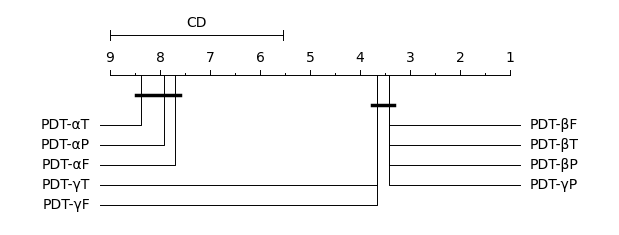

In [32]:
plot_stats(result, allow_insignificant=True)
plt.savefig('f1_score.svg')

### Tabella per F1 SENSITIVITY

In [113]:
tab_sensitivit = grouped_df
tab_sensitivit = tab_sensitivit[tab_sensitivit['dataset_type_'] == 'full_dataset']
tab_sensitivit = tab_sensitivit[tab_sensitivit['max_depth_'] == 8]
tab_sensitivit = tab_sensitivit[tab_sensitivit['perc_'] == 1.0]
tab_sensitivit

type_of_exp_          absolute_diff_ dataset_type_  \
342   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
343   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
344   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
942   NEW_CORR_KNN_kmeans_class_results         only_difference  full_dataset   
943   NEW_CORR_KNN_kmeans_class_results         only_difference  full_dataset   
944   NEW_CORR_KNN_kmeans_class_results         only_difference  full_dataset   
1542  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1543  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
1544  NEW_CORR_KNN_kmeans_class_results           original_feat  full_dataset   
2304        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
2305        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
2306        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
2904        NEW_CORR_KNN_random_results         only_difference  full_dataset   
2905        NEW_CORR_KNN_random_results         only_difference  full_dataset   
2906        NEW_CORR_KNN_random_results         only_difference  full_dataset   
3504        NEW_CORR_KNN_random_results           original_feat  full_dataset   
3505        NEW_CORR_KNN_random_results           original_feat  full_dataset   
3506        NEW_CORR_KNN_random_results           original_feat  full_dataset   
4023     NEW_CORR_KNN_stratrand_results  both_original_and_diff  full_dataset   
4024     NEW_CORR_KNN_stratrand_results  both_original_and_diff  full_dataset   
4025     NEW_CORR_KNN_stratrand_results  both_original_and_diff  full_dataset   
4443     NEW_CORR_KNN_stratrand_results         only_difference  full_dataset   
4444     NEW_CORR_KNN_stratrand_results         only_difference  full_dataset   
4445     NEW_CORR_KNN_stratrand_results         only_difference  full_dataset   
4863     NEW_CORR_KNN_stratrand_results           original_feat  full_dataset   
4864     NEW_CORR_KNN_stratrand_results           original_feat  full_dataset   
4865     NEW_CORR_KNN_stratrand_results           original_feat  full_dataset   

      perc_  max_depth_  fix_feature_  fix_threshold_ type_of_split_  \
342     1.0           8         False           False           free   
343     1.0           8          True           False       fix_feat   
344     1.0           8          True            True        fix_thr   
942     1.0           8         False           False           free   
943     1.0           8          True           False       fix_feat   
944     1.0           8          True            True        fix_thr   
1542    1.0           8         False           False           free   
1543    1.0           8          True           False       fix_feat   
1544    1.0           8          True            True        fix_thr   
2304    1.0           8         False           False           free   
2305    1.0           8          True           False       fix_feat   
2306    1.0           8          True            True        fix_thr   
2904    1.0           8         False           False           free   
2905    1.0           8          True           False       fix_feat   
2906    1.0           8          True            True        fix_thr   
3504    1.0           8         False           False           free   
3505    1.0           8          True           False       fix_feat   
3506    1.0           8          True            True        fix_thr   
4023    1.0           8         False           False           free   
4024    1.0           8          True           False       fix_feat   
4025    1.0           8          True            True        fix_thr   
4443    1.0           8         False           False           free   
4444    1.0           8          True           False       fix_feat   
4445    1.0           8       

In [114]:
tab_sensitivit = grouped_df
tab_sensitivit = tab_sensitivit[tab_sensitivit['dataset_type_'] == 'full_dataset']
tab_sensitivit = tab_sensitivit[tab_sensitivit['max_depth_'] == 8]
tab_sensitivit = tab_sensitivit[tab_sensitivit['perc_'] == 1.0]
shortt = tab_sensitivit[['type_of_exp_','absolute_diff_','type_of_split_','KNN_measure_test_f1_weighted_mean_mean','KNN_measure_test_f1_weighted_mean_std']]

KeyError: "['KNN_measure_test_f1_weighted_mean_mean', 'KNN_measure_test_f1_weighted_mean_std'] not in index"

In [115]:
shortt

NameError: name 'shortt' is not defined

In [117]:
import pandas as pd

# Filter the DataFrame
cd_plot_table = shortt[shortt['type_of_exp_'] == 'NEW_CORR_KNN_kmeans_class_results']

# Define mapping of conditions to model names
mapping = {
    ("original_feat", "free"): "PDT-Pα",
    ("original_feat", "fix_feat"): "PDT-Fα",
    ("original_feat", "fix_thr"): "PDT-Tα",
    ("only_difference", "free"): "PDT-Pβ",
    ("only_difference", "fix_feat"): "PDT-Fβ",
    ("only_difference", "fix_thr"): "PDT-Tβ",
    ("both_original_and_diff", "free"): "PDT-Pγ",
    ("both_original_and_diff", "fix_feat"): "PDT-Fγ",
    ("both_original_and_diff", "fix_thr"): "PDT-Tγ",
}

# Apply the mapping to create the "model_name" column
cd_plot_table["model_name"] = cd_plot_table.apply(
    lambda row: mapping.get((row['absolute_diff_'], row['type_of_split_']), 'Unknown'), axis=1
)

# Display the updated DataFrame
cd_plot_table


NameError: name 'shortt' is not defined

In [118]:
shortt = shortt[shortt['type_of_exp_'] == 'NEW_CORR_KNN_kmeans_class_results']
shortt[shortt['absolute_diff_'] == 'both_original_and_diff']

NameError: name 'shortt' is not defined

In [119]:
import numpy as np
import pandas as pd

# Iterate through unique experiment types
for exp in np.unique(tab_sensitivit['type_of_exp_']):
    df_exp = tab_sensitivit[tab_sensitivit['type_of_exp_'] == exp]
    
    # Select numeric columns only
    numeric_cols = df_exp.select_dtypes(include=[np.number]).columns
    
    # Perform groupby and compute mean & std only on numeric columns
    grouped_df_table = df_exp.groupby(['absolute_diff_', 'type_of_split_'])[numeric_cols].agg(['mean', 'std']).reset_index()
    
    display(grouped_df_table)  # Show intermediate grouped table

    # Pivot to reshape the DataFrame
    mean_pivot = grouped_df_table.pivot(index='absolute_diff_', columns='type_of_split_', values=[(col, 'mean') for col in numeric_cols])
    std_pivot = grouped_df_table.pivot(index='absolute_diff_', columns='type_of_split_', values=[(col, 'std') for col in numeric_cols])

    # Rename columns to indicate Mean & Std values
    mean_pivot.columns = [f"{col[0]}_{col[1]}_mean" for col in mean_pivot.columns]
    std_pivot.columns = [f"{col[0]}_{col[1]}_std" for col in std_pivot.columns]

    # Combine Mean & Std tables
    final_pivot = pd.concat([mean_pivot, std_pivot], axis=1)

    # Reset index
    final_pivot.reset_index(inplace=True)

    # Display the final result
    display(final_pivot)  # Use print(final_pivot) if not using Jupyter Notebook


absolute_diff_ type_of_split_ perc_     max_depth_      \
                                          mean std       mean std   
0  both_original_and_diff       fix_feat   1.0 NaN        8.0 NaN   
1  both_original_and_diff        fix_thr   1.0 NaN        8.0 NaN   
2  both_original_and_diff           free   1.0 NaN        8.0 NaN   
3         only_difference       fix_feat   1.0 NaN        8.0 NaN   
4         only_difference        fix_thr   1.0 NaN        8.0 NaN   
5         only_difference           free   1.0 NaN        8.0 NaN   
6           original_feat       fix_feat   1.0 NaN        8.0 NaN   
7           original_feat        fix_thr   1.0 NaN        8.0 NaN   
8           original_feat           free   1.0 NaN        8.0 NaN   

  n_neighbors_     PairDistTree_predict_on_test_time_process_mean_mean      \
          mean std                                                mean std   
0          5.0 NaN                                           0.028762  NaN   
1          5.0 NaN                                           0.028309  NaN   
2          5.0 NaN                                           0.028274  NaN   
3          5.0 NaN                                           0.027295  NaN   
4          5.0 NaN                                           0.026937  NaN   
5          5.0 NaN                                           0.028055  NaN   
6          5.0 NaN                                           0.021109  NaN   
7          5.0 NaN                                           0.016513  NaN   
8          5.0 NaN                                           0.023600  NaN   

  PairDistTree_predict_on_test_time_process_mean_std      \
                                                mean std   
0                                           0.036559 NaN   
1                                           0.035111 NaN   
2                                           0.035370 NaN   
3                                           0.032368 NaN   
4                                           0.030270 NaN   
5                                           0.033186 NaN   
6                                           0.027918 NaN   
7                                           0.024824 NaN   
8                                           0.035468 NaN   

  PairDistTree_predict_on_test_time_process_std_mean      \
                                                mean std   
0                                           0.004627 NaN   
1                                           0.003442 NaN   
2                                           0.003314 NaN   
3                                           0.003439 NaN   
4                                           0.003309 NaN   
5                                           0.003386 NaN   
6                                           0.004462 NaN   
7                                           0.002840 NaN   
8                                           0.004200 NaN   

  PairDistTree_predict_on_test_time_process_std_std      
                                               mean std  
0                                          0.007868 NaN  
1                                          0.004487 NaN  
2                                          0.004023 NaN  
3                                          0.003740 NaN  
4                                          0.002640 NaN  
5                                          0.003659 NaN  
6                                          0.009326 NaN  
7                                          0.005949 NaN  
8                                          0.009114 NaN

absolute_diff_  ('perc_', 'mean')_fix_feat_mean  \
0  both_original_and_diff                              1.0   
1         only_difference                              1.0   
2           original_feat                              1.0   

   ('perc_', 'mean')_fix_thr_mean  ('perc_', 'mean')_free_mean  \
0                             1.0                          1.0   
1                             1.0                          1.0   
2                             1.0                          1.0   

   ('max_depth_', 'mean')_fix_feat_mean  ('max_depth_', 'mean')_fix_thr_mean  \
0                                   8.0                                  8.0   
1                                   8.0                                  8.0   
2                                   8.0                                  8.0   

   ('max_depth_', 'mean')_free_mean  ('n_neighbors_', 'mean')_fix_feat_mean  \
0                               8.0                                     5.0   
1                               8.0                                     5.0   
2                               8.0                                     5.0   

   ('n_neighbors_', 'mean')_fix_thr_mean  ('n_neighbors_', 'mean')_free_mean  \
0                                    5.0                                 5.0   
1                                    5.0                                 5.0   
2                                    5.0                                 5.0   

   ('PairDistTree_predict_on_test_time_process_mean_mean', 'mean')_fix_feat_mean  \
0                                           0.028762                               
1                                           0.027295                               
2                                           0.021109                               

   ('PairDistTree_predict_on_test_time_process_mean_mean', 'mean')_fix_thr_mean  \
0                                           0.028309                              
1                                           0.026937                              
2                                           0.016513                              

   ('PairDistTree_predict_on_test_time_process_mean_mean', 'mean')_free_mean  \
0                                           0.028274                           
1                                           0.028055                           
2                                           0.023600                           

   ('PairDistTree_predict_on_test_time_process_mean_std', 'mean')_fix_feat_mean  \
0                                           0.036559                              
1                                           0.032368                              
2                                           0.027918                              

   ('PairDistTree_predict_on_test_time_process_mean_std', 'mean')_fix_thr_mean  \
0                                           0.035111                             
1                                           0.030270                             
2                                           0.024824                             

   ('PairDistTree_predict_on_test_time_process_mean_std', 'mean')_free_mean  \
0                                           0.035370                          
1                                           0.033186                          
2                                           0.035468                          

   ('PairDistTree_predict_on_test_time_process_std_mean', 'mean')_fix_feat_mean  \
0                                           0.004627                              
1                                           0.003439                              
2                                           0.004462                              

   ('PairDistTree_predict_on_test_time_process_std_mean', 'mean')_fix_thr_mean  \
0                                           0.003442                             
1                                           0.003309                   

absolute_diff_ type_of_split_ perc_     max_depth_      \
                                          mean std       mean std   
0  both_original_and_diff       fix_feat   1.0 NaN        8.0 NaN   
1  both_original_and_diff        fix_thr   1.0 NaN        8.0 NaN   
2  both_original_and_diff           free   1.0 NaN        8.0 NaN   
3         only_difference       fix_feat   1.0 NaN        8.0 NaN   
4         only_difference        fix_thr   1.0 NaN        8.0 NaN   
5         only_difference           free   1.0 NaN        8.0 NaN   
6           original_feat       fix_feat   1.0 NaN        8.0 NaN   
7           original_feat        fix_thr   1.0 NaN        8.0 NaN   
8           original_feat           free   1.0 NaN        8.0 NaN   

  n_neighbors_     PairDistTree_predict_on_test_time_process_mean_mean      \
          mean std                                                mean std   
0          5.0 NaN                                           0.028683  NaN   
1          5.0 NaN                                           0.029138  NaN   
2          5.0 NaN                                           0.028983  NaN   
3          5.0 NaN                                           0.026568  NaN   
4          5.0 NaN                                           0.026254  NaN   
5          5.0 NaN                                           0.026500  NaN   
6          5.0 NaN                                           0.021163  NaN   
7          5.0 NaN                                           0.017870  NaN   
8          5.0 NaN                                           0.022031  NaN   

  PairDistTree_predict_on_test_time_process_mean_std      \
                                                mean std   
0                                           0.037475 NaN   
1                                           0.038812 NaN   
2                                           0.037762 NaN   
3                                           0.031795 NaN   
4                                           0.030563 NaN   
5                                           0.031230 NaN   
6                                           0.030269 NaN   
7                                           0.030558 NaN   
8                                           0.033274 NaN   

  PairDistTree_predict_on_test_time_process_std_mean      \
                                                mean std   
0                                           0.005205 NaN   
1                                           0.005040 NaN   
2                                           0.004057 NaN   
3                                           0.003489 NaN   
4                                           0.002960 NaN   
5                                           0.003589 NaN   
6                                           0.004537 NaN   
7                                           0.003858 NaN   
8                                           0.003216 NaN   

  PairDistTree_predict_on_test_time_process_std_std      
                                               mean std  
0                                          0.008765 NaN  
1                                          0.007739 NaN  
2                                          0.004151 NaN  
3                                          0.003329 NaN  
4                                          0.002694 NaN  
5                                          0.003491 NaN  
6                                          0.009832 NaN  
7                                          0.009155 NaN  
8                                          0.005513 NaN

absolute_diff_  ('perc_', 'mean')_fix_feat_mean  \
0  both_original_and_diff                              1.0   
1         only_difference                              1.0   
2           original_feat                              1.0   

   ('perc_', 'mean')_fix_thr_mean  ('perc_', 'mean')_free_mean  \
0                             1.0                          1.0   
1                             1.0                          1.0   
2                             1.0                          1.0   

   ('max_depth_', 'mean')_fix_feat_mean  ('max_depth_', 'mean')_fix_thr_mean  \
0                                   8.0                                  8.0   
1                                   8.0                                  8.0   
2                                   8.0                                  8.0   

   ('max_depth_', 'mean')_free_mean  ('n_neighbors_', 'mean')_fix_feat_mean  \
0                               8.0                                     5.0   
1                               8.0                                     5.0   
2                               8.0                                     5.0   

   ('n_neighbors_', 'mean')_fix_thr_mean  ('n_neighbors_', 'mean')_free_mean  \
0                                    5.0                                 5.0   
1                                    5.0                                 5.0   
2                                    5.0                                 5.0   

   ('PairDistTree_predict_on_test_time_process_mean_mean', 'mean')_fix_feat_mean  \
0                                           0.028683                               
1                                           0.026568                               
2                                           0.021163                               

   ('PairDistTree_predict_on_test_time_process_mean_mean', 'mean')_fix_thr_mean  \
0                                           0.029138                              
1                                           0.026254                              
2                                           0.017870                              

   ('PairDistTree_predict_on_test_time_process_mean_mean', 'mean')_free_mean  \
0                                           0.028983                           
1                                           0.026500                           
2                                           0.022031                           

   ('PairDistTree_predict_on_test_time_process_mean_std', 'mean')_fix_feat_mean  \
0                                           0.037475                              
1                                           0.031795                              
2                                           0.030269                              

   ('PairDistTree_predict_on_test_time_process_mean_std', 'mean')_fix_thr_mean  \
0                                           0.038812                             
1                                           0.030563                             
2                                           0.030558                             

   ('PairDistTree_predict_on_test_time_process_mean_std', 'mean')_free_mean  \
0                                           0.037762                          
1                                           0.031230                          
2                                           0.033274                          

   ('PairDistTree_predict_on_test_time_process_std_mean', 'mean')_fix_feat_mean  \
0                                           0.005205                              
1                                           0.003489                              
2                                           0.004537                              

   ('PairDistTree_predict_on_test_time_process_std_mean', 'mean')_fix_thr_mean  \
0                                           0.005040                             
1                                           0.002960                   

absolute_diff_ type_of_split_ perc_     max_depth_      \
                                          mean std       mean std   
0  both_original_and_diff       fix_feat   1.0 NaN        8.0 NaN   
1  both_original_and_diff        fix_thr   1.0 NaN        8.0 NaN   
2  both_original_and_diff           free   1.0 NaN        8.0 NaN   
3         only_difference       fix_feat   1.0 NaN        8.0 NaN   
4         only_difference        fix_thr   1.0 NaN        8.0 NaN   
5         only_difference           free   1.0 NaN        8.0 NaN   
6           original_feat       fix_feat   1.0 NaN        8.0 NaN   
7           original_feat        fix_thr   1.0 NaN        8.0 NaN   
8           original_feat           free   1.0 NaN        8.0 NaN   

  n_neighbors_     PairDistTree_predict_on_test_time_process_mean_mean      \
          mean std                                                mean std   
0          5.0 NaN                                           0.029646  NaN   
1          5.0 NaN                                           0.028930  NaN   
2          5.0 NaN                                           0.028840  NaN   
3          5.0 NaN                                           0.026655  NaN   
4          5.0 NaN                                           0.026560  NaN   
5          5.0 NaN                                           0.027151  NaN   
6          5.0 NaN                                           0.020040  NaN   
7          5.0 NaN                                           0.015820  NaN   
8          5.0 NaN                                           0.022554  NaN   

  PairDistTree_predict_on_test_time_process_mean_std      \
                                                mean std   
0                                           0.039505 NaN   
1                                           0.037241 NaN   
2                                           0.037535 NaN   
3                                           0.031474 NaN   
4                                           0.030067 NaN   
5                                           0.032614 NaN   
6                                           0.025045 NaN   
7                                           0.023071 NaN   
8                                           0.032289 NaN   

  PairDistTree_predict_on_test_time_process_std_mean      \
                                                mean std   
0                                           0.004303 NaN   
1                                           0.004052 NaN   
2                                           0.003815 NaN   
3                                           0.002931 NaN   
4                                           0.003471 NaN   
5                                           0.003043 NaN   
6                                           0.002607 NaN   
7                                           0.001852 NaN   
8                                           0.003329 NaN   

  PairDistTree_predict_on_test_time_process_std_std      
                                               mean std  
0                                          0.006895 NaN  
1                                          0.006090 NaN  
2                                          0.005672 NaN  
3                                          0.002854 NaN  
4                                          0.003093 NaN  
5                                          0.003404 NaN  
6                                          0.004056 NaN  
7                                          0.003001 NaN  
8                                          0.006134 NaN

absolute_diff_  ('perc_', 'mean')_fix_feat_mean  \
0  both_original_and_diff                              1.0   
1         only_difference                              1.0   
2           original_feat                              1.0   

   ('perc_', 'mean')_fix_thr_mean  ('perc_', 'mean')_free_mean  \
0                             1.0                          1.0   
1                             1.0                          1.0   
2                             1.0                          1.0   

   ('max_depth_', 'mean')_fix_feat_mean  ('max_depth_', 'mean')_fix_thr_mean  \
0                                   8.0                                  8.0   
1                                   8.0                                  8.0   
2                                   8.0                                  8.0   

   ('max_depth_', 'mean')_free_mean  ('n_neighbors_', 'mean')_fix_feat_mean  \
0                               8.0                                     5.0   
1                               8.0                                     5.0   
2                               8.0                                     5.0   

   ('n_neighbors_', 'mean')_fix_thr_mean  ('n_neighbors_', 'mean')_free_mean  \
0                                    5.0                                 5.0   
1                                    5.0                                 5.0   
2                                    5.0                                 5.0   

   ('PairDistTree_predict_on_test_time_process_mean_mean', 'mean')_fix_feat_mean  \
0                                           0.029646                               
1                                           0.026655                               
2                                           0.020040                               

   ('PairDistTree_predict_on_test_time_process_mean_mean', 'mean')_fix_thr_mean  \
0                                            0.02893                              
1                                            0.02656                              
2                                            0.01582                              

   ('PairDistTree_predict_on_test_time_process_mean_mean', 'mean')_free_mean  \
0                                           0.028840                           
1                                           0.027151                           
2                                           0.022554                           

   ('PairDistTree_predict_on_test_time_process_mean_std', 'mean')_fix_feat_mean  \
0                                           0.039505                              
1                                           0.031474                              
2                                           0.025045                              

   ('PairDistTree_predict_on_test_time_process_mean_std', 'mean')_fix_thr_mean  \
0                                           0.037241                             
1                                           0.030067                             
2                                           0.023071                             

   ('PairDistTree_predict_on_test_time_process_mean_std', 'mean')_free_mean  \
0                                           0.037535                          
1                                           0.032614                          
2                                           0.032289                          

   ('PairDistTree_predict_on_test_time_process_std_mean', 'mean')_fix_feat_mean  \
0                                           0.004303                              
1                                           0.002931                              
2                                           0.002607                              

   ('PairDistTree_predict_on_test_time_process_std_mean', 'mean')_fix_thr_mean  \
0                                           0.004052                             
1                                           0.003471                   

In [48]:
groupby df_exp absolute_diff_ type_of_split_ and consider onyl nuemric columsn for mean and standard dev

SyntaxError: invalid syntax (2013801472.py, line 1)

In [120]:
import pandas as pd

# Select relevant columns and get unique combinations
unique_combinations = grouped_df[['type_of_exp_', 'absolute_diff_', 'dataset_type_', 'type_of_split_']].drop_duplicates()

# Reset index for cleaner output
unique_combinations = unique_combinations.reset_index(drop=True)

unique_combinations.head()

type_of_exp_          absolute_diff_  \
0  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
1  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
2  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
3  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
4  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   

       dataset_type_ type_of_split_  
0       full_dataset        fix_thr  
1       full_dataset           free  
2       full_dataset       fix_feat  
3  subsample_dataset           free  
4  subsample_dataset       fix_feat

In [121]:
import pandas as pd

def create_f1_matrix(grouped_df, type_of_exp, absolute_diff, dataset_type, type_of_split):
    """
    Creates a DataFrame where:
    - Rows: 'perc_' values
    - Columns: 'max_depth_' values
    - Values: 'KNN_measure_test_f1_weighted_mean_mean' and 'KNN_measure_test_f1_weighted_std_mean'

    Filters data based on type_of_exp_, absolute_diff_, dataset_type_, and type_of_split_.

    Parameters:
    - grouped_df: DataFrame containing grouped results
    - type_of_exp: Value for 'type_of_exp_'
    - absolute_diff: Value for 'absolute_diff_'
    - dataset_type: Value for 'dataset_type_'
    - type_of_split: Value for 'type_of_split_'

    Returns:
    - Two DataFrames (mean & std), with 'perc_' as the index
    """

    # Filter dataframe based on input conditions
    filtered_df = grouped_df[
        (grouped_df['type_of_exp_'] == type_of_exp) &
        (grouped_df['absolute_diff_'] == absolute_diff) &
        (grouped_df['dataset_type_'] == dataset_type) &
        (grouped_df['type_of_split_'] == type_of_split)
    ]

    # Pivot tables to create the matrix format
    f1_matrix = filtered_df.pivot(index='perc_', columns='max_depth_', values='PairDistTree_predict_on_test_time_process_mean_mean')
    std_matrix = filtered_df.pivot(index='perc_', columns='max_depth_', values='PairDistTree_predict_on_test_time_process_std_mean')

    # Convert pivot tables to normal DataFrame and set 'perc_' as index
    f1_matrix = f1_matrix.reset_index().set_index('perc_')
    std_matrix = std_matrix.reset_index().set_index('perc_')

    # Add metadata columns
    f1_matrix.insert(0, 'type_of_exp_', type_of_exp)
    f1_matrix.insert(1, 'absolute_diff_', absolute_diff)
    f1_matrix.insert(2, 'dataset_type_', dataset_type)
    f1_matrix.insert(3, 'type_of_split_', type_of_split)

    std_matrix.insert(0, 'type_of_exp_', type_of_exp)
    std_matrix.insert(1, 'absolute_diff_', absolute_diff)
    std_matrix.insert(2, 'dataset_type_', dataset_type)
    std_matrix.insert(3, 'type_of_split_', type_of_split)

    return f1_matrix, std_matrix

# Example usage:
# f1_matrix, std_matrix = create_f1_matrix(grouped_df, 'exp1', 0.1, 'datasetA', 'split1')
# print(f1_matrix)
# print(std_matrix)


In [122]:
grouped_df

type_of_exp_          absolute_diff_  \
0     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
1     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
2     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
3     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
4     NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
...                                 ...                     ...   
5071     NEW_CORR_KNN_stratrand_results           original_feat   
5072     NEW_CORR_KNN_stratrand_results           original_feat   
5073     NEW_CORR_KNN_stratrand_results           original_feat   
5074     NEW_CORR_KNN_stratrand_results           original_feat   
5075     NEW_CORR_KNN_stratrand_results           original_feat   

          dataset_type_  perc_  max_depth_  fix_feature_  fix_threshold_  \
0          full_dataset   0.01           2          True            True   
1          full_dataset   0.01           4          True            True   
2          full_dataset   0.01           8          True            True   
3          full_dataset   0.01          16          True            True   
4          full_dataset   0.01          32          True            True   
...                 ...    ...         ...           ...             ...   
5071  subsample_dataset   1.00           7          True           False   
5072  subsample_dataset   1.00           7          True            True   
5073  subsample_dataset   1.00           8         False           False   
5074  subsample_dataset   1.00           8          True           False   
5075  subsample_dataset   1.00           8          True            True   

     type_of_split_        train_test_case_  n_neighbors_  \
0           fix_thr  train_test_r1_r2_r1_r2             5   
1           fix_thr  train_test_r1_r2_r1_r2             5   
2           fix_thr  train_test_r1_r2_r1_r2             5   
3           fix_thr  train_test_r1_r2_r1_r2             5   
4           fix_thr  train_test_r1_r2_r1_r2             5   
...             ...                     ...           ...   
5071       fix_feat  train_test_r1_r2_r1_r2             5   
5072        fix_thr  train_test_r1_r2_r1_r2             5   
5073           free  train_test_r1_r2_r1_r2             5   
5074       fix_feat  train_test_r1_r2_r1_r2             5   
5075        fix_thr  train_test_r1_r2_r1_r2             5   

      PairDistTree_predict_on_test_time_process_mean_mean  \
0                                              0.006848     
1                                              0.009585     
2                                              0.013546     
3                                              0.013056     
4                                              0.013182     
...                                                 ...     
5071                                           0.018343     
5072                                           0.015910     
5073                                           0.022554     
5074                                           0.020040     
5075                                           0.015820     

      PairDistTree_predict_on_test_time_process_mean_std  \
0                                              0.009778    
1                                              0.015160    
2                                              0.024074    
3                                              0.022576    
4                                              0.022954    
...                                                 ...    
5071                                           0.027547    
5072                                           0.025712    
5073                                           0.032289    
5074                                           0.025045    
5075                                           0.023071    

      PairDistTree_predict_on_test_time_process_std_mean  \
0                                              0.000726    
1 

In [123]:
f1_matrix, std_matrix = create_f1_matrix(grouped_df,'NEW_CORR_KNN_random_results','both_original_and_diff','full_dataset','fix_thr')

In [124]:
f1_matrix

max_depth_                 type_of_exp_          absolute_diff_ dataset_type_  \
perc_                                                                           
0.01        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.02        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.03        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.04        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.05        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.06        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.07        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.08        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.09        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.10        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.20        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.30        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.40        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.50        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.60        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.70        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.80        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
0.90        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
1.00        NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   

max_depth_ type_of_split_         2         3         4         5         6  \
perc_                                                                         
0.01              fix_thr  0.005873       NaN  0.009460       NaN       NaN   
0.02              fix_thr  0.005586       NaN  0.008875       NaN       NaN   
0.03              fix_thr  0.005978       NaN  0.008824       NaN       NaN   
0.04              fix_thr  0.005837       NaN  0.008993       NaN       NaN   
0.05              fix_thr  0.006366       NaN  0.011852       NaN       NaN   
0.06              fix_thr  0.006624       NaN  0.009833       NaN       NaN   
0.07              fix_thr  0.005817       NaN  0.008931       NaN       NaN   
0.08              fix_thr  0.005823       NaN  0.009125       NaN       NaN   
0.09              fix_thr  0.006021       NaN  0.009270       NaN       NaN   
0.10              fix_thr  0.007433  0.009868  0.013049  0.016662  0.020626   
0.20              fix_thr  0.008033  0.009589  0.011997  0.014426  0.017817   
0.30              fix_thr  0.006981  0.009475  0.011256  0.013638  0.016790   
0.40              fix_thr  0.006897  0.008547  0.011048  0.013382  0.015766   
0.50              fix_thr  0.006519  0.008650  0.010664  0.013042  0.015969   
0.60              fix_thr  0.006845  0.008676  0.011190  0.013402  0.015928   
0.70              fix_thr  0.007107  0.008874  0.011336  0.013481  0.016328   
0.80              fix_thr  0.007306  0.009223  0.010923  0.013273  0.016451   
0.90              fix_thr  0.006546  0.008466  0.010498  0.012893  0.015657   
1.00              fix_thr  0.007995  0.010819  0.013944  0.018101  0.020666   

max_depth_         7         8        16        32        64  
perc_                                                         
0.01             NaN  0.010467  0.010415  0.010468  0.010385  
0.02             NaN  0.012551  0.013379  0.013609  0.013836  
0.03             NaN  0.013744  0.014140  0.014388  0.014014  
0.04             NaN  0.014082  0.015995  0.018098  0.018357  
0.05             NaN  0.021218  0.025871  0.026089  0.026217  
0.06             NaN  0.016601  0.020024  0.020855  0.020860  
0.07             NaN  0.015801  0.021253  0.021497  0.022295  
0.08             NaN  0.017958  0.024943  0.026020  0.025074  
0.09    

In [32]:
for e, row in unique_combinations.iterrows():
    type_of_exp = row['type_of_exp_']
    absolute_diff = row['absolute_diff_']
    dataset_type = row['dataset_type_']
    type_of_split = row['type_of_split_'] 

    f1_matrix, std_matrix = create_f1_matrix(grouped_df,type_of_exp,absolute_diff,dataset_type,type_of_split)

    
    name_path = f'TEST_TIME_results_exp/mean/{type_of_exp}/{absolute_diff}/{dataset_type}/{type_of_split}/'
    save_dir = name_path
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the directory
  
    name_save = os.path.join(save_dir, 'res_table.csv')
    f1_matrix.to_csv(name_save, index=False)

    name_path = f'TEST_TIME_results_exp/std/{type_of_exp}/{absolute_diff}/{dataset_type}/{type_of_split}/'
    save_dir = name_path
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the directory
  
    name_save = os.path.join(save_dir, 'res_table.csv')
    std_matrix.to_csv(name_save, index=False)

    
    

In [58]:
f1_matrix

max_depth_                    type_of_exp_ absolute_diff_      dataset_type_  \
perc_                                                                          
0.1         NEW_CORR_KNN_stratrand_results  original_feat  subsample_dataset   
0.2         NEW_CORR_KNN_stratrand_results  original_feat  subsample_dataset   
0.3         NEW_CORR_KNN_stratrand_results  original_feat  subsample_dataset   
0.4         NEW_CORR_KNN_stratrand_results  original_feat  subsample_dataset   
0.5         NEW_CORR_KNN_stratrand_results  original_feat  subsample_dataset   
0.6         NEW_CORR_KNN_stratrand_results  original_feat  subsample_dataset   
0.7         NEW_CORR_KNN_stratrand_results  original_feat  subsample_dataset   
0.8         NEW_CORR_KNN_stratrand_results  original_feat  subsample_dataset   
0.9         NEW_CORR_KNN_stratrand_results  original_feat  subsample_dataset   
1.0         NEW_CORR_KNN_stratrand_results  original_feat  subsample_dataset   

max_depth_ type_of_split_         2         3         4         5         6  \
perc_                                                                         
0.1               fix_thr  0.427001  0.431407  0.534637  0.545399  0.595558   
0.2               fix_thr  0.391906  0.412996  0.521207  0.523303  0.593869   
0.3               fix_thr  0.366119  0.389522  0.506318  0.520617  0.578060   
0.4               fix_thr  0.357321  0.377224  0.490385  0.504114  0.569145   
0.5               fix_thr  0.365240  0.404248  0.496007  0.501134  0.573279   
0.6               fix_thr  0.367321  0.396833  0.481998  0.482215  0.551985   
0.7               fix_thr  0.358997  0.397084  0.486550  0.488624  0.544781   
0.8               fix_thr  0.357182  0.393871  0.480821  0.491851  0.555362   
0.9               fix_thr  0.360989  0.384664  0.481469  0.490974  0.553390   
1.0               fix_thr  0.340958  0.368343  0.492527  0.504169  0.568117   

max_depth_         7         8  
perc_                           
0.1         0.601735  0.622182  
0.2         0.596404  0.652400  
0.3         0.586271  0.635226  
0.4         0.596143  0.648962  
0.5         0.581145  0.618992  
0.6         0.578404  0.625126  
0.7         0.562917  0.616259  
0.8         0.570833  0.629025  
0.9         0.560275  0.631828  
1.0         0.587401  0.607345

In [30]:
f1_matrix

max_depth_  perc_         2         3         4         5         6         7   
0             0.1  0.405159  0.440599  0.524106  0.527016  0.576543  0.608497  \
1             0.2  0.373055  0.417925  0.519484  0.544522  0.593902  0.623223   
2             0.3  0.382253  0.421638  0.520393  0.541143  0.593878  0.619618   
3             0.4  0.385252  0.420256  0.513943  0.522272  0.574777  0.608228   
4             0.5  0.380369  0.427864  0.512929  0.540843  0.589090  0.623514   
5             0.6  0.368000  0.436413  0.508110  0.521161  0.562697  0.595317   
6             0.7  0.370436  0.435711  0.516915  0.534667  0.574638  0.610140   
7             0.8  0.368736  0.431471  0.504480  0.521843  0.572863  0.603839   
8             0.9  0.361617  0.455425  0.519831  0.515699  0.566946  0.588027   
9             1.0  0.384600  0.401260  0.501322  0.521668  0.583111  0.594203   

max_depth_         8                    type_of_exp_ absolute_diff_   
0           0.630032  NEW_CORR_KNN_stratrand_results  original_feat  \
1           0.638236  NEW_CORR_KNN_stratrand_results  original_feat   
2           0.637860  NEW_CORR_KNN_stratrand_results  original_feat   
3           0.649219  NEW_CORR_KNN_stratrand_results  original_feat   
4           0.638799  NEW_CORR_KNN_stratrand_results  original_feat   
5           0.614693  NEW_CORR_KNN_stratrand_results  original_feat   
6           0.652122  NEW_CORR_KNN_stratrand_results  original_feat   
7           0.632507  NEW_CORR_KNN_stratrand_results  original_feat   
8           0.636318  NEW_CORR_KNN_stratrand_results  original_feat   
9           0.621927  NEW_CORR_KNN_stratrand_results  original_feat   

max_depth_ dataset_type_ type_of_split_  
0           full_dataset           free  
1           full_dataset           free  
2           full_dataset           free  
3           full_dataset           free  
4           full_dataset           free  
5           full_dataset           free  
6           full_dataset           free  
7           full_dataset           free  
8           full_dataset           free  
9           full_dataset           free

In [33]:
def final_result_grouping(df, type_of_exp_name = 'NEW_CORR_KNN_random_results', dataset_type_ = 'full_dataset' ):

    full_exps_results_rand_subset = df[df['type_of_exp_'] == type_of_exp_name]
    full_exps_results_rand_subset = full_exps_results_rand_subset[full_exps_results_rand_subset['dataset_type_'] == dataset_type_]


    ref_list = ['type_of_exp_', 'dataset_type_',
                'absolute_diff_',
                'perc_', 'max_depth_', 'fix_feature_', 'fix_threshold_', 'type_of_split_',
                'train_test_case_','n_neighbors_']

    
    grouped = full_exps_results_rand_subset.groupby(ref_list)
    
    mean_values = grouped.mean()
    std_values = grouped.std()
    mean_values = mean_values.reset_index()
    std_values = std_values.reset_index()
    
    mean_values.columns = [f'{col}_mean' if col not in ref_list else col for col in mean_values.columns]
    std_values.columns = [f'{col}_std' if col not in ref_list else col for col in std_values.columns]

    final_result = pd.merge(mean_values, std_values, on=ref_list)

    return final_result
    

In [34]:
random_results= final_result_grouping(selectsubset(full_exps_results_rand), type_of_exp_name ='NEW_CORR_KNN_random_results' )
stratrand_results= final_result_grouping(selectsubset(full_exps_results_rand), type_of_exp_name ='NEW_CORR_KNN_stratrand_results')
kmeans_results= final_result_grouping(selectsubset(full_exps_results_rand),  type_of_exp_name ='NEW_CORR_KNN_kmeans_class_results')

In [40]:
ki  = random_results[random_results['max_depth_'] == 4]
ki = ki[ki['type_of_split_'] == 'free']
ki = ki[ki['perc_'] == 1.0]
ki

type_of_exp_ dataset_type_          absolute_diff_  perc_   
195  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    1.0  \
405  NEW_CORR_KNN_random_results  full_dataset         only_difference    1.0   
615  NEW_CORR_KNN_random_results  full_dataset           original_feat    1.0   

     max_depth_  fix_feature_  fix_threshold_ type_of_split_   
195           4         False           False           free  \
405           4         False           False           free   
615           4         False           False           free   

           train_test_case_  n_neighbors_   
195  train_test_r1_r2_r1_r2             5  \
405  train_test_r1_r2_r1_r2             5   
615  train_test_r1_r2_r1_r2             5   

     KNN_measure_test_f1_weighted_mean_mean   
195                                0.736352  \
405                                0.736352   
615                                0.507320   

     KNN_measure_test_f1_weighted_std_mean   
195                               0.000000  \
405                               0.000000   
615                               0.010308   

     KNN_measure_test_f1_weighted_mean_std   
195                               0.183267  \
405                               0.183267   
615                               0.214007   

     KNN_measure_test_f1_weighted_std_std  
195                               0.00000  
405                               0.00000  
615                               0.01798

In [36]:
final_table_for_plot(random_results)

KeyError: 'KNN_measure_test_f1_weighted_mean_mean'

In [31]:
import numpy as np
import pandas as pd

def final_table_for_plot(dataframe, 
                         mean_NAME = 'KNN_measure_test_f1_weighted_mean_mean', 
                         std_NAME = 'KNN_measure_test_f1_weighted_std_mean'):
    # Extract unique sorted values for each categorical variable
    setting_cols = ['type_of_exp_', 'absolute_diff_', 'dataset_type_', 'perc_',
       'max_depth_', 'fix_feature_', 'fix_threshold_', 'type_of_split_',
       'train_test_case_', 'n_neighbors_']

    
    list_type_of_exp_ = sorted(np.unique(dataframe['type_of_exp_']))
    list_absolute_diff_ = sorted(np.unique(dataframe['absolute_diff_']))
    list_dataset_type_ = sorted(np.unique(dataframe['dataset_type_']))
    fix_features = sorted(np.unique(dataframe['type_of_split_']))
    list_perc_ = sorted(np.unique(dataframe['perc_']))
    depths = sorted(np.unique(dataframe['max_depth_']))
    
    # Dictionary to store results
    results_list_mean = {}
    results_list_std = {}

    # Iterate over all possible combinations of experiment parameters
    for type_of_exp_ in list_type_of_exp_:
       # print(f"Processing: {type_of_exp_}")
        
        for absolute_diff_ in list_absolute_diff_:
           # print(f"  - Absolute Diff: {absolute_diff_}")
            
            for dataset_type_ in list_dataset_type_:
                #print(f"    - Dataset Type: {dataset_type_}")

                for type_of_split_ in fix_features:
                    #print(f"      - Type of Split: {type_of_split_}")
                    
                    # Apply initial filtering based on fixed attributes
                    df_filtered = dataframe[
                        (dataframe['type_of_exp_'] == type_of_exp_) &
                        (dataframe['absolute_diff_'] == absolute_diff_) &
                        (dataframe['dataset_type_'] == dataset_type_) &
                        (dataframe['type_of_split_'] == type_of_split_)
                    ]
                    #display(df_filtered)
                    perc_depth_dict_mean = {}
                    perc_depth_dict_std = {}
                    for max_depth_ in depths:
                        df_filted_depth = df_filtered[df_filtered.max_depth_ == max_depth_]
                        perc_values_mean = []
                        perc_values_std = []
                        for perc_ in list_perc_:
                            df_perc_depth = df_filted_depth[df_filted_depth.perc_ == perc_]
                            #print(df_perc_depth.columns)
                            grouped = df_perc_depth.groupby(setting_cols).agg(['mean', 'std'])
                            grouped.columns = ['_'.join(col) for col in grouped.columns] 
                            grouped = grouped.reset_index()
                            #display(grouped)
                          
                            mean_val = grouped[mean_NAME][0]
                            std_val = grouped[std_NAME][0]
                            perc_values_mean.append(mean_val)
                            perc_values_std.append(std_val)

                        perc_depth_dict_mean[max_depth_] = perc_values_mean
                        perc_depth_dict_std[max_depth_] =perc_values_std

                    name_of_exp_ = f'{type_of_exp_}/{absolute_diff_}/{dataset_type_}/{type_of_split_}'

                    perc_depth_dict_mean = pd.DataFrame(perc_depth_dict_mean)
                    perc_depth_dict_std = pd.DataFrame(perc_depth_dict_std)

                    for k, v in {'type_of_exp_' : type_of_exp_, 'absolute_diff_' : absolute_diff_,
                              'dataset_type_': dataset_type_, 'type_of_split_': type_of_split_}.items():
                        perc_depth_dict_mean[k] = v
                        perc_depth_dict_std[k] = v
                    
                    
                    results_list_mean[name_of_exp_] = perc_depth_dict_mean

                    results_list_std[name_of_exp_] = perc_depth_dict_std      
                            
                        
    return results_list_mean, results_list_std

In [63]:
FINAL_TABLE = final_result_grouping(full_exps_results_rand_subset)
FINAL_TABLE

type_of_exp_          absolute_diff_ dataset_type_   
0     NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset  \
1     NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
2     NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
3     NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
4     NEW_CORR_KNN_random_results  both_original_and_diff  full_dataset   
...                           ...                     ...           ...   
1045  NEW_CORR_KNN_random_results           original_feat  full_dataset   
1046  NEW_CORR_KNN_random_results           original_feat  full_dataset   
1047  NEW_CORR_KNN_random_results           original_feat  full_dataset   
1048  NEW_CORR_KNN_random_results           original_feat  full_dataset   
1049  NEW_CORR_KNN_random_results           original_feat  full_dataset   

      perc_  max_depth_  fix_feature_  fix_threshold_ type_of_split_   
0       0.1           2         False           False           free  \
1       0.1           2          True           False       fix_feat   
2       0.1           2          True            True        fix_thr   
3       0.1           3         False           False           free   
4       0.1           3          True           False       fix_feat   
...     ...         ...           ...             ...            ...   
1045    1.0           7          True           False       fix_feat   
1046    1.0           7          True            True        fix_thr   
1047    1.0           8         False           False           free   
1048    1.0           8          True           False       fix_feat   
1049    1.0           8          True            True        fix_thr   

            train_test_case_  n_neighbors_  KNN_measure_test_f1_weighted_mean   
0     train_test_r1_r2_r1_r2             5                           0.152609  \
1     train_test_r1_r2_r1_r2             5                           0.152609   
2     train_test_r1_r2_r1_r2             5                           0.152609   
3     train_test_r1_r2_r1_r2             5                           0.225119   
4     train_test_r1_r2_r1_r2             5                           0.225119   
...                      ...           ...                                ...   
1045  train_test_r1_r2_r1_r2             5                           0.470209   
1046  train_test_r1_r2_r1_r2             5                           0.443114   
1047  train_test_r1_r2_r1_r2             5                           0.554666   
1048  train_test_r1_r2_r1_r2             5                           0.524444   
1049  train_test_r1_r2_r1_r2             5                           0.450778   

      KNN_measure_test_f1_weighted_std  
0                             0.072700  
1                             0.072700  
2                             0.072700  
3                             0.040584  
4                             0.040584  
...                                ...  
1045                          0.016603  
1046                          0.015819  
1047                          0.009001  
1048                          0.037167  
1049                          0.000136  

[7560 rows x 12 columns]

In [64]:
results_list_mean, results_list_std = final_table_for_plot(full_exps_results_rand_subset)

In [66]:
results_list_mean['NEW_CORR_KNN_kmeans_class_results/both_original_and_diff/full_dataset/fix_feat']

2         3         4         5         6         7         8   
0  0.574924  0.636542  0.657176  0.682313  0.709804  0.721564  0.731454  \
1  0.572976  0.657396  0.684834  0.709233  0.723253  0.739528  0.752490   
2  0.577832  0.656062  0.694186  0.708239  0.725319  0.742425  0.753172   
3  0.584230  0.649850  0.686166  0.717473  0.734214  0.750672  0.747495   
4  0.553135  0.641341  0.686747  0.703554  0.731326  0.740513  0.748784   
5  0.541818  0.647619  0.707224  0.711166  0.745977  0.745527  0.749138   
6  0.557076  0.659598  0.691405  0.713511  0.729308  0.739882  0.748191   
7  0.592085  0.662769  0.699642  0.708509  0.725075  0.737186  0.754144   
8  0.596339  0.662741  0.695024  0.713813  0.722188  0.739919  0.744071   
9  0.587518  0.693650  0.736352  0.743926  0.734262  0.772302  0.766606   

                        type_of_exp_          absolute_diff_ dataset_type_   
0  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset  \
1  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
2  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
3  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
4  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
5  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
6  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
7  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
8  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
9  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   

  type_of_split_  
0       fix_feat  
1       fix_feat  
2       fix_feat  
3       fix_feat  
4       fix_feat  
5       fix_feat  
6       fix_feat  
7       fix_feat  
8       fix_feat  
9       fix_feat

In [67]:
results_list_std['NEW_CORR_KNN_kmeans_class_results/both_original_and_diff/full_dataset/fix_feat']

2         3         4         5         6         7         8   
0  0.076886  0.064654  0.061509  0.059911  0.058240  0.054838  0.054101  \
1  0.056007  0.053086  0.050545  0.048670  0.045866  0.044428  0.039975   
2  0.042324  0.049618  0.051033  0.048288  0.038628  0.043519  0.036579   
3  0.053598  0.045610  0.045217  0.036152  0.035632  0.041076  0.033440   
4  0.037138  0.043455  0.041551  0.039290  0.037597  0.037950  0.036506   
5  0.020871  0.035165  0.036576  0.037852  0.031634  0.037029  0.032044   
6  0.027426  0.030123  0.032963  0.027945  0.035579  0.031400  0.035213   
7  0.023258  0.026773  0.034505  0.032697  0.034408  0.032614  0.029849   
8  0.012200  0.018346  0.028850  0.035192  0.023840  0.029611  0.029075   
9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                        type_of_exp_          absolute_diff_ dataset_type_   
0  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset  \
1  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
2  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
3  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
4  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
5  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
6  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
7  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
8  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   
9  NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  full_dataset   

  type_of_split_  
0       fix_feat  
1       fix_feat  
2       fix_feat  
3       fix_feat  
4       fix_feat  
5       fix_feat  
6       fix_feat  
7       fix_feat  
8       fix_feat  
9       fix_feat

In [35]:
for k, v in results_list_mean.items():
    #print(k)
    save_dir = f'KNN_results_exp/mean/{k}'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the directory
  
    name_save = os.path.join(save_dir, 'res_table.csv')
    
    v.to_csv(name_save, index=False)
    #print(f"Saved {name_save}")
    

for k, v in results_list_std.items():
    #print(k)
    save_dir = f'KNN_results_exp/std/{k}'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the directory
  
    name_save = os.path.join(save_dir, 'res_table.csv')
    
    v.to_csv(name_save, index=False)
    #print(f"Saved {name_save}")
    



### DELETE FROM HERE

In [33]:
results_list_mean['NEW_CORR_KNN_kmeans_class_results_both_original_and_diff_full_dataset_fix_feat']

KeyError: 'NEW_CORR_KNN_kmeans_class_results_both_original_and_diff_full_dataset_fix_feat'

In [48]:
import os

for k, v in results_list_mean.items():
    # Construct the path where the CSV will be saved
    save_dir = f'KNN_results_exp/mean/{k}'
    
    # Check if the directory exists, and if not, create it
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the directory
    
    # Construct the filename for saving the CSV
    name_save = os.path.join(save_dir, 'res_table.csv')
    
    # Save the DataFrame to CSV
    v.to_csv(name_save, index=False)
    print(f"Saved {name_save}")


Saved KNN_results_exp/mean/NEW_CORR_KNN_kmeans_class_results/both_original_and_diff/full_dataset/fix_feat/res_table.csv
Saved KNN_results_exp/mean/NEW_CORR_KNN_kmeans_class_results/both_original_and_diff/full_dataset/fix_thr/res_table.csv
Saved KNN_results_exp/mean/NEW_CORR_KNN_kmeans_class_results/both_original_and_diff/full_dataset/free/res_table.csv
Saved KNN_results_exp/mean/NEW_CORR_KNN_kmeans_class_results/both_original_and_diff/subsample_dataset/fix_feat/res_table.csv
Saved KNN_results_exp/mean/NEW_CORR_KNN_kmeans_class_results/both_original_and_diff/subsample_dataset/fix_thr/res_table.csv
Saved KNN_results_exp/mean/NEW_CORR_KNN_kmeans_class_results/both_original_and_diff/subsample_dataset/free/res_table.csv
Saved KNN_results_exp/mean/NEW_CORR_KNN_kmeans_class_results/only_difference/full_dataset/fix_feat/res_table.csv
Saved KNN_results_exp/mean/NEW_CORR_KNN_kmeans_class_results/only_difference/full_dataset/fix_thr/res_table.csv
Saved KNN_results_exp/mean/NEW_CORR_KNN_kmeans_cla

In [144]:
res_list_concat = pd.concat(reslist)

TypeError: 'NoneType' object is not iterable

In [106]:
res_list_concat

type_of_exp_          absolute_diff_   
0   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff  \
0   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
0   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
0   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
0   NEW_CORR_KNN_kmeans_class_results  both_original_and_diff   
..                                ...                     ...   
0      NEW_CORR_KNN_stratrand_results           original_feat   
0      NEW_CORR_KNN_stratrand_results           original_feat   
0      NEW_CORR_KNN_stratrand_results           original_feat   
0      NEW_CORR_KNN_stratrand_results           original_feat   
0      NEW_CORR_KNN_stratrand_results           original_feat   

        dataset_type_  perc_  max_depth_  fix_feature_  fix_threshold_   
0        full_dataset    0.1           2          True           False  \
0        full_dataset    0.2           2          True           False   
0        full_dataset    0.3           2          True           False   
0        full_dataset    0.4           2          True           False   
0        full_dataset    0.5           2          True           False   
..                ...    ...         ...           ...             ...   
0   subsample_dataset    0.6           8         False           False   
0   subsample_dataset    0.7           8         False           False   
0   subsample_dataset    0.8           8         False           False   
0   subsample_dataset    0.9           8         False           False   
0   subsample_dataset    1.0           8         False           False   

   type_of_split_        train_test_case_  n_neighbors_   
0        fix_feat  train_test_r1_r2_r1_r2             5  \
0        fix_feat  train_test_r1_r2_r1_r2             5   
0        fix_feat  train_test_r1_r2_r1_r2             5   
0        fix_feat  train_test_r1_r2_r1_r2             5   
0        fix_feat  train_test_r1_r2_r1_r2             5   
..            ...                     ...           ...   
0            free  train_test_r1_r2_r1_r2             5   
0            free  train_test_r1_r2_r1_r2             5   
0            free  train_test_r1_r2_r1_r2             5   
0            free  train_test_r1_r2_r1_r2             5   
0            free  train_test_r1_r2_r1_r2             5   

    KNN_measure_test_f1_weighted_mean_mean   
0                                 0.569631  \
0                                 0.541235   
0                                 0.520807   
0                                 0.537901   
0                                 0.533599   
..                                     ...   
0                                 0.586244   
0                                 0.582052   
0                                 0.575824   
0                                 0.589694   
0                                 0.585847   

    KNN_measure_test_f1_weighted_mean_std   
0                                0.123537  \
0                                0.147825   
0                                0.148258   
0                                0.164206   
0                                0.182179   
..                                    ...   
0                                0.138676   
0                                0.139457   
0                                0.133910   
0                                0.146208   
0                                0.155647   

    KNN_measure_test_f1_weighted_std_mean   
0                                0.091084  \
0                                0.082188   
0                                0.070508   
0                                0.075574   
0                                0.050715   
..                                    ...   
0                                0.101322   
0                                0.094428   
0                                0.100397   
0                                0.097133   
0                                0.000000   

    KNN_mea

In [ ]:
def final_table_for_plot(dataframe):
    list_type_of_exp_ = sorted(np.unique(dataframe.type_of_exp_))
    list_absolute_diff_ = sorted(np.unique(dataframe.absolute_diff_))
    list_dataset_type_ = sorted(np.unique(dataframe.dataset_type_))
    
    list_perc_ = sorted(np.unique(dataframe.perc_))
    depths = sorted(np.unique(dataframe.max_depth_))
    fix_features = sorted(np.unique(dataframe.type_of_split_))

    create all the possible combination and filter the dataframe accoridn got these combination then reutrn a dicitonary of all the possible combination



In [27]:
full_exps_results_rand_subset.type_of_exp_

0             NEW_CORR_KNN_random_results
1             NEW_CORR_KNN_random_results
2             NEW_CORR_KNN_random_results
3             NEW_CORR_KNN_random_results
4             NEW_CORR_KNN_random_results
                      ...                
1255    NEW_CORR_KNN_kmeans_class_results
1256    NEW_CORR_KNN_kmeans_class_results
1257    NEW_CORR_KNN_kmeans_class_results
1258    NEW_CORR_KNN_kmeans_class_results
1259    NEW_CORR_KNN_kmeans_class_results
Name: type_of_exp_, Length: 60480, dtype: object

In [82]:
def table_value(final_results,
                measure_mean = 'KNN_measure_test_f1_weighted_mean_mean', 
                measure_std = 'KNN_measure_test_f1_weighted_std_mean'):
    display(final_results)
    df = final_results

    depths = sorted(np.unique(df.max_depth_))
    perc = sorted(np.unique(df.perc_))
    absolute_diffs = sorted(np.unique(df.absolute_diff_))

    distressults = {}
    for type_of_distance in absolute_diffs:
        df_temp = df[df['absolute_diff_'] == type_of_distance]
        lines_mean = {}
        lines_std = {}
        for depth in depths:
            x_axis_mean = {}
            x_axis_std = {}
            df_line = df_temp[df_temp['max_depth_'] == depth]
            display(df_line)
            for perc_ in perc:
                df_line_perc = df_line[df_line['perc_'] == perc_]
                display(df_line_perc)
                if len(df_line_perc) > 1:
                    raise TypeError
                x_axis_mean[perc_] = df_line_perc.iloc[0][measure_mean]
                x_axis_std[perc_] = df_line_perc.iloc[0][measure_std]
   

In [83]:
table_value(final_results)

type_of_exp_ dataset_type_          absolute_diff_  perc_   
0    NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.1  \
1    NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.1   
2    NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.1   
3    NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.1   
4    NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.1   
..                           ...           ...                     ...    ...   
625  NEW_CORR_KNN_random_results  full_dataset           original_feat    1.0   
626  NEW_CORR_KNN_random_results  full_dataset           original_feat    1.0   
627  NEW_CORR_KNN_random_results  full_dataset           original_feat    1.0   
628  NEW_CORR_KNN_random_results  full_dataset           original_feat    1.0   
629  NEW_CORR_KNN_random_results  full_dataset           original_feat    1.0   

     max_depth_  fix_feature_  fix_threshold_ type_of_split_   
0             2         False           False           free  \
1             2          True           False       fix_feat   
2             2          True            True        fix_thr   
3             3         False           False           free   
4             3          True           False       fix_feat   
..          ...           ...             ...            ...   
625           7          True           False       fix_feat   
626           7          True            True        fix_thr   
627           8         False           False           free   
628           8          True           False       fix_feat   
629           8          True            True        fix_thr   

           train_test_case_  n_neighbors_   
0    train_test_r1_r2_r1_r2             5  \
1    train_test_r1_r2_r1_r2             5   
2    train_test_r1_r2_r1_r2             5   
3    train_test_r1_r2_r1_r2             5   
4    train_test_r1_r2_r1_r2             5   
..                      ...           ...   
625  train_test_r1_r2_r1_r2             5   
626  train_test_r1_r2_r1_r2             5   
627  train_test_r1_r2_r1_r2             5   
628  train_test_r1_r2_r1_r2             5   
629  train_test_r1_r2_r1_r2             5   

     KNN_measure_test_f1_weighted_mean_mean   
0                                  0.615859  \
1                                  0.615859   
2                                  0.615859   
3                                  0.659727   
4                                  0.659727   
..                                      ...   
625                                0.555813   
626                                0.548880   
627                                0.580448   
628                                0.587693   
629                                0.570835   

     KNN_measure_test_f1_weighted_std_mean   
0                                 0.098685  \
1                                 0.098685   
2                                 0.098685   
3                                 0.083056   
4                                 0.083056   
..                                     ...   
625                               0.039678   
626                               0.032034   
627                               0.037072   
628                               0.038607   
629                               0.005144   

     KNN_measure_test_f1_weighted_mean_std   
0                                 0.097577  \
1                                 0.097577   
2                                 0.097577   
3                                 0.126767   
4                                 0.126767   
..                                     ...   
625                               0.152349   
626                               0.141093   
627                               0.171317   
628                               0.145102   
629                               0.150596   

     KNN_measure_test_f1_weighted_std_std  
0                     

type_of_exp_ dataset_type_          absolute_diff_  perc_   
0    NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.1  \
1    NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.1   
2    NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.1   
21   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.2   
22   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.2   
23   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.2   
42   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.3   
43   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.3   
44   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.3   
63   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.4   
64   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.4   
65   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.4   
84   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.5   
85   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.5   
86   NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.5   
105  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.6   
106  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.6   
107  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.6   
126  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.7   
127  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.7   
128  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.7   
147  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.8   
148  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.8   
149  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.8   
168  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.9   
169  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.9   
170  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.9   
189  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    1.0   
190  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    1.0   
191  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    1.0   

     max_depth_  fix_feature_  fix_threshold_ type_of_split_   
0             2         False           False           free  \
1             2          True           False       fix_feat   
2             2          True            True        fix_thr   
21            2         False           False           free   
22            2          True           False       fix_feat   
23            2          True            True        fix_thr   
42            2         False           False           free   
43            2          True           False       fix_feat   
44            2          True            True        fix_thr   
63            2         False           False           free   
64            2          True           False       fix_feat   
65            2          True            True        fix_thr   
84            2         False           False           free   
85            2          True           False       fix_feat   
86            2          True            True        fix_thr   
105           2         False           False           free   
106           2          True           False       fix_feat   
107           2          True            True        fix_thr   
126           2         False           False           free   
127           2          True           False       fix_feat   
128           2          True            True        fix_thr   
147           2         False           False           free   
148           2          True       

type_of_exp_ dataset_type_          absolute_diff_  perc_   
0  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.1  \
1  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.1   
2  NEW_CORR_KNN_random_results  full_dataset  both_original_and_diff    0.1   

   max_depth_  fix_feature_  fix_threshold_ type_of_split_   
0           2         False           False           free  \
1           2          True           False       fix_feat   
2           2          True            True        fix_thr   

         train_test_case_  n_neighbors_   
0  train_test_r1_r2_r1_r2             5  \
1  train_test_r1_r2_r1_r2             5   
2  train_test_r1_r2_r1_r2             5   

   KNN_measure_test_f1_weighted_mean_mean   
0                                0.615859  \
1                                0.615859   
2                                0.615859   

   KNN_measure_test_f1_weighted_std_mean   
0                               0.098685  \
1                               0.098685   
2                               0.098685   

   KNN_measure_test_f1_weighted_mean_std  KNN_measure_test_f1_weighted_std_std  
0                               0.097577                              0.069608  
1                               0.097577                              0.069608  
2                               0.097577                              0.069608

TypeError: 

In [ ]:
def plot_value(final_results, type_of_exp = 'random_results', absolute_diff_ = 'original_feat', type_of_split_ = 'free',
              measure_mean = 'KNN_measure_test_f1_weighted_mean_mean', 
               measure_std = 'KNN_measure_test_f1_weighted_std_mean'):
    df = final_results
    df = df[df['type_of_exp'] == type_of_exp]
    df = df[df['absolute_diff_'] == absolute_diff_]
    df = df[df['type_of_split_'] == type_of_split_]
    

    depths = sorted(np.unique(df.max_depth_))
    perc = sorted(np.unique(df.perc_))
    #print(perc)
   # print(depths)

    lines_mean = {}
    lines_std = {}
    for depth in depths:
        x_axis_mean = {}
        x_axis_std = {}
        df_line = df[df['max_depth_'] == depth]
        for perc_ in perc:
            df_line_perc = df_line[df_line['perc_'] == perc_]
            if len(df_line_perc) > 1:
                raise TypeError
            x_axis_mean[perc_] = df_line_perc.iloc[0][measure_mean]
            x_axis_std[perc_] = df_line_perc.iloc[0][measure_std]

        lines_mean[depth] = x_axis_mean
        lines_std[depth] = x_axis_std
        

    lines_mean = pd.DataFrame(lines_mean).T
    lines_mean['max_depth'] = list(lines_mean.index)
    lines_mean['absolute_diff_'] = absolute_diff_
    lines_mean['type_of_split_'] = type_of_split_
    lines_mean['type_of_exp'] = type_of_exp
    cols_mean = ['max_depth'] + [col for col in lines_mean.columns if col != 'max_depth']
    lines_mean = lines_mean[cols_mean]
        
    lines_std = pd.DataFrame(lines_std).T
    lines_std['max_depth'] = list(lines_std.index)
    lines_std['absolute_diff_'] = absolute_diff_
    lines_std['type_of_split_'] = type_of_split_
    lines_std['type_of_exp'] = type_of_exp
    cols_std = ['max_depth'] + [col for col in lines_std.columns if col != 'max_depth']
    lines_std = lines_std[cols_std]
        
    return lines_mean, lines_std
    

## REMOVE FROM HERE

In [23]:
import pandas as pd

# Assuming 'full_exps_results_rand' is your DataFrame
ref_list = ['type_of_exp', 'absolute_diff_', 'perc_', 'max_depth_', 'fix_feature_', 'fix_threshold_', 'type_of_split_','train_test_case_','knn_n_neighbors_']
grouped = full_exps_results_rand.groupby(
    ['type_of_exp', 'absolute_diff_', 'perc_', 'max_depth_', 'fix_feature_', 'fix_threshold_', 'type_of_split_','train_test_case_','knn_n_neighbors_']
)

# Calculate both the mean and std for each group
mean_values = grouped.mean()
std_values = grouped.std()

# Flatten the result by resetting the index
mean_values = mean_values.reset_index()
std_values = std_values.reset_index()

# Rename columns to distinguish mean and std values
mean_values.columns = [f'{col}_mean' if col not in ref_list else col for col in mean_values.columns]
std_values.columns = [f'{col}_std' if col not in ref_list else col for col in std_values.columns]

# Merge the mean and std values into one DataFrame
final_result = pd.merge(mean_values, std_values, on=['type_of_exp','absolute_diff_', 'perc_', 'max_depth_', 'fix_feature_', 'fix_threshold_', 'type_of_split_','train_test_case_','knn_n_neighbors_'])

final_result


type_of_exp          absolute_diff_  perc_  max_depth_   
0     KNN_kmeans_class_results  both_original_and_diff    0.1           2  \
1     KNN_kmeans_class_results  both_original_and_diff    0.1           2   
2     KNN_kmeans_class_results  both_original_and_diff    0.1           2   
3     KNN_kmeans_class_results  both_original_and_diff    0.1           3   
4     KNN_kmeans_class_results  both_original_and_diff    0.1           3   
...                        ...                     ...    ...         ...   
1885     KNN_stratrand_results           original_feat    1.0           7   
1886     KNN_stratrand_results           original_feat    1.0           7   
1887     KNN_stratrand_results           original_feat    1.0           8   
1888     KNN_stratrand_results           original_feat    1.0           8   
1889     KNN_stratrand_results           original_feat    1.0           8   

      fix_feature_  fix_threshold_ type_of_split_        train_test_case_   
0            False           False           free  train_test_r1_r2_r1_r2  \
1             True           False       fix_feat  train_test_r1_r2_r1_r2   
2             True            True        fix_thr  train_test_r1_r2_r1_r2   
3            False           False           free  train_test_r1_r2_r1_r2   
4             True           False       fix_feat  train_test_r1_r2_r1_r2   
...            ...             ...            ...                     ...   
1885          True           False       fix_feat  train_test_r1_r2_r1_r2   
1886          True            True        fix_thr  train_test_r1_r2_r1_r2   
1887         False           False           free  train_test_r1_r2_r1_r2   
1888          True           False       fix_feat  train_test_r1_r2_r1_r2   
1889          True            True        fix_thr  train_test_r1_r2_r1_r2   

      knn_n_neighbors_  KNN_measure_test_f1_weighted_mean_mean   
0                    5                                0.487484  \
1                    5                                0.487484   
2                    5                                0.487484   
3                    5                                0.544772   
4                    5                                0.544772   
...                ...                                     ...   
1885                 5                                0.553052   
1886                 5                                0.557719   
1887                 5                                0.614189   
1888                 5                                0.588971   
1889                 5                                0.617696   

      KNN_measure_test_f1_weighted_std_mean   
0                                  0.067199  \
1                                  0.067199   
2                                  0.067199   
3                                  0.085470   
4                                  0.085470   
...                                     ...   
1885                               0.000000   
1886                               0.000000   
1887                               0.000000   
1888                               0.000000   
1889                               0.000000   

      KNN_measure_test_f1_weighted_mean_std   
0                                  0.257532  \
1                                  0.257532   
2                                  0.257532   
3                                  0.207454   
4                                  0.207454   
...                                     ...   
1885                               0.173615   
1886                               0.181298   
1887                               0.164793   
1888                               0.164082   
1889                               0.179092   

      KNN_measure_test_f1_weighted_std_std  
0                                 0.046315  
1                                 0.046315  
2                                 0.046315  
3                                 0.021969  
4                    

In [24]:
def plot_value(final_results, type_of_exp = 'random_results', absolute_diff_ = 'original_feat', type_of_split_ = 'free',
              measure_mean = 'KNN_measure_test_f1_weighted_mean_mean', 
               measure_std = 'KNN_measure_test_f1_weighted_std_mean'):
    df = final_results
    df = df[df['type_of_exp'] == type_of_exp]
    df = df[df['absolute_diff_'] == absolute_diff_]
    df = df[df['type_of_split_'] == type_of_split_]
    

    depths = sorted(np.unique(df.max_depth_))
    perc = sorted(np.unique(df.perc_))
    #print(perc)
   # print(depths)

    lines_mean = {}
    lines_std = {}
    for depth in depths:
        x_axis_mean = {}
        x_axis_std = {}
        df_line = df[df['max_depth_'] == depth]
        for perc_ in perc:
            df_line_perc = df_line[df_line['perc_'] == perc_]
            if len(df_line_perc) > 1:
                raise TypeError
            x_axis_mean[perc_] = df_line_perc.iloc[0][measure_mean]
            x_axis_std[perc_] = df_line_perc.iloc[0][measure_std]

        lines_mean[depth] = x_axis_mean
        lines_std[depth] = x_axis_std
        

    lines_mean = pd.DataFrame(lines_mean).T
    lines_mean['max_depth'] = list(lines_mean.index)
    lines_mean['absolute_diff_'] = absolute_diff_
    lines_mean['type_of_split_'] = type_of_split_
    lines_mean['type_of_exp'] = type_of_exp
    cols_mean = ['max_depth'] + [col for col in lines_mean.columns if col != 'max_depth']
    lines_mean = lines_mean[cols_mean]
        
    lines_std = pd.DataFrame(lines_std).T
    lines_std['max_depth'] = list(lines_std.index)
    lines_std['absolute_diff_'] = absolute_diff_
    lines_std['type_of_split_'] = type_of_split_
    lines_std['type_of_exp'] = type_of_exp
    cols_std = ['max_depth'] + [col for col in lines_std.columns if col != 'max_depth']
    lines_std = lines_std[cols_std]
        
    return lines_mean, lines_std
    

In [25]:
# Define the dictionaries
dict_abs = {
    'both_original_and_diff': 'Feat. + Dist.', 
    'only_difference': 'Dist.', 
    'original_feat': 'Feat.'
}

dict_type_of_exp = {
    'kmeans_class_results': 'k-Means Exp.', 
    'random_results': 'Rand. Exp.', 
    'stratrand_results': 'Str. Rand. Exp.'
}

dict_type_of_split_ = {
    'fix_thr': 'Fix Thr.', 
    'fix_feat': 'Fix Feat.', 
    'free': 'Standard'
}


In [26]:
res_mean, res_std = plot_value(final_result, type_of_exp = 'KNN_random_results',
                               type_of_split_ = 'fix_feat', 
                               absolute_diff_ = 'original_feat')
res_mean

max_depth       0.1       0.2       0.3       0.4       0.5       0.6   
2          2  0.396630  0.394306  0.390176  0.400813  0.380567  0.394595  \
3          3  0.416854  0.411269  0.401605  0.408013  0.391000  0.415968   
4          4  0.472574  0.477820  0.479352  0.490302  0.480030  0.472076   
5          5  0.502556  0.488475  0.494027  0.516284  0.501141  0.490212   
6          6  0.530244  0.539857  0.543761  0.569715  0.543551  0.545324   
7          7  0.542178  0.563850  0.572725  0.581531  0.570717  0.565194   
8          8  0.553852  0.596927  0.604119  0.607544  0.626857  0.608131   

   0.7000000000000001       0.8       0.9       1.0 absolute_diff_   
2            0.371158  0.393493  0.385346  0.357135  original_feat  \
3            0.381565  0.409325  0.392231  0.375866  original_feat   
4            0.453870  0.461869  0.450370  0.428557  original_feat   
5            0.460622  0.475883  0.463352  0.436366  original_feat   
6            0.516360  0.531619  0.539396  0.510439  original_feat   
7            0.562751  0.542374  0.575498  0.549997  original_feat   
8            0.606230  0.593911  0.625550  0.626121  original_feat   

  type_of_split_         type_of_exp  
2       fix_feat  KNN_random_results  
3       fix_feat  KNN_random_results  
4       fix_feat  KNN_random_results  
5       fix_feat  KNN_random_results  
6       fix_feat  KNN_random_results  
7       fix_feat  KNN_random_results  
8       fix_feat  KNN_random_results

In [27]:
res_mean, res_std = plot_value(final_result, type_of_exp = 'KNN_random_results', type_of_split_ = 'free', 
                               absolute_diff_ = 'original_feat')
res_mean

max_depth       0.1       0.2       0.3       0.4       0.5       0.6   
2          2  0.391105  0.387064  0.378162  0.401288  0.381132  0.389910  \
3          3  0.418096  0.409495  0.403397  0.415361  0.395677  0.418702   
4          4  0.474510  0.482915  0.474762  0.488223  0.469197  0.469467   
5          5  0.503295  0.505874  0.501203  0.513707  0.506713  0.497484   
6          6  0.531594  0.552356  0.548770  0.559056  0.548017  0.555272   
7          7  0.542069  0.574508  0.564887  0.595063  0.581356  0.575999   
8          8  0.554964  0.606313  0.613572  0.622395  0.625358  0.614580   

   0.7000000000000001       0.8       0.9       1.0 absolute_diff_   
2            0.368390  0.386474  0.388421  0.359003  original_feat  \
3            0.385112  0.409456  0.408435  0.377158  original_feat   
4            0.463130  0.464569  0.467357  0.435052  original_feat   
5            0.479285  0.483994  0.473961  0.445730  original_feat   
6            0.529634  0.548087  0.543603  0.498680  original_feat   
7            0.574495  0.568746  0.578823  0.556007  original_feat   
8            0.615598  0.607771  0.628159  0.620232  original_feat   

  type_of_split_         type_of_exp  
2           free  KNN_random_results  
3           free  KNN_random_results  
4           free  KNN_random_results  
5           free  KNN_random_results  
6           free  KNN_random_results  
7           free  KNN_random_results  
8           free  KNN_random_results

In [28]:
res_mean, res_std = plot_value(final_result, type_of_exp = 'KNN_random_results', type_of_split_ = 'free', 
                               absolute_diff_ = 'both_original_and_diff')
res_mean

max_depth       0.1       0.2       0.3       0.4       0.5       0.6   
2          2  0.549590  0.587509  0.584508  0.592841  0.579410  0.574713  \
3          3  0.574065  0.649518  0.648875  0.662763  0.648060  0.638928   
4          4  0.591727  0.673976  0.690092  0.706564  0.711127  0.723691   
5          5  0.606439  0.703413  0.719123  0.727671  0.738453  0.737261   
6          6  0.613738  0.718745  0.741407  0.738380  0.749984  0.750580   
7          7  0.618197  0.728493  0.740201  0.756227  0.765442  0.762914   
8          8  0.621677  0.729796  0.751071  0.762446  0.772611  0.774220   

   0.7000000000000001       0.8       0.9       1.0          absolute_diff_   
2            0.571017  0.583840  0.576418  0.567053  both_original_and_diff  \
3            0.641768  0.653628  0.647655  0.655113  both_original_and_diff   
4            0.691478  0.697766  0.694059  0.683220  both_original_and_diff   
5            0.731411  0.745350  0.735118  0.734440  both_original_and_diff   
6            0.748499  0.751285  0.756376  0.755970  both_original_and_diff   
7            0.756637  0.756537  0.768585  0.784787  both_original_and_diff   
8            0.771082  0.776500  0.778535  0.782013  both_original_and_diff   

  type_of_split_         type_of_exp  
2           free  KNN_random_results  
3           free  KNN_random_results  
4           free  KNN_random_results  
5           free  KNN_random_results  
6           free  KNN_random_results  
7           free  KNN_random_results  
8           free  KNN_random_results

In [29]:
dict_type_of_split_, dict_abs

({'fix_thr': 'Fix Thr.', 'fix_feat': 'Fix Feat.', 'free': 'Standard'},
 {'both_original_and_diff': 'Feat. + Dist.',
  'only_difference': 'Dist.',
  'original_feat': 'Feat.'})

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_r2_comparison_three_three(df_results):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns for side-by-side plots

    experiment_titles = {
        'free': "Free Split",
        'fix_feat': "Fixed Features Split",
        'fix_thr': "Fixed Threshold Split"
    }

    for ax, (split_type, (df_grouped_mean, df_grouped_std)) in zip(axes, df_results.items()):
        absolute_diff_ = df_grouped_mean.iloc[0]['absolute_diff_']
        type_of_exp = df_grouped_mean.iloc[0]['type_of_exp']

        df_grouped_mean = df_grouped_mean.drop(columns=['absolute_diff_', 'type_of_split_', 'type_of_exp'])
        df_grouped_std = df_grouped_std.drop(columns=['absolute_diff_', 'type_of_split_', 'type_of_exp'])

        dataset_sizes = df_grouped_mean.columns[1:].astype(float)
        x_labels = [f"{int(size * 100)}%" for size in dataset_sizes]

        for _, row in df_grouped_mean.iterrows():
            depth = int(row["max_depth"])
            mean_values = row[1:].values
            std_values = df_grouped_std[df_grouped_std["max_depth"] == depth].iloc[:, 1:].values.flatten()

            ax.errorbar(dataset_sizes, mean_values, yerr=std_values, label=f"Depth {depth}", marker='o', capsize=3)
        ax.set_xlabel("Dataset Size", fontsize=14)
        ax.set_xticks(dataset_sizes)
        ax.set_xticklabels(x_labels, fontsize=12)
        ax.set_title(experiment_titles.get(split_type, split_type), fontsize=16)
        ax.grid(True)

    axes[0].set_ylabel("Mean Weighted F1 Score", fontsize=18)  # Only leftmost plot gets the y-label
    axes[0].set_ylim(0.0, 0.8)
    axes[-1].legend(title="Tree Depth", fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

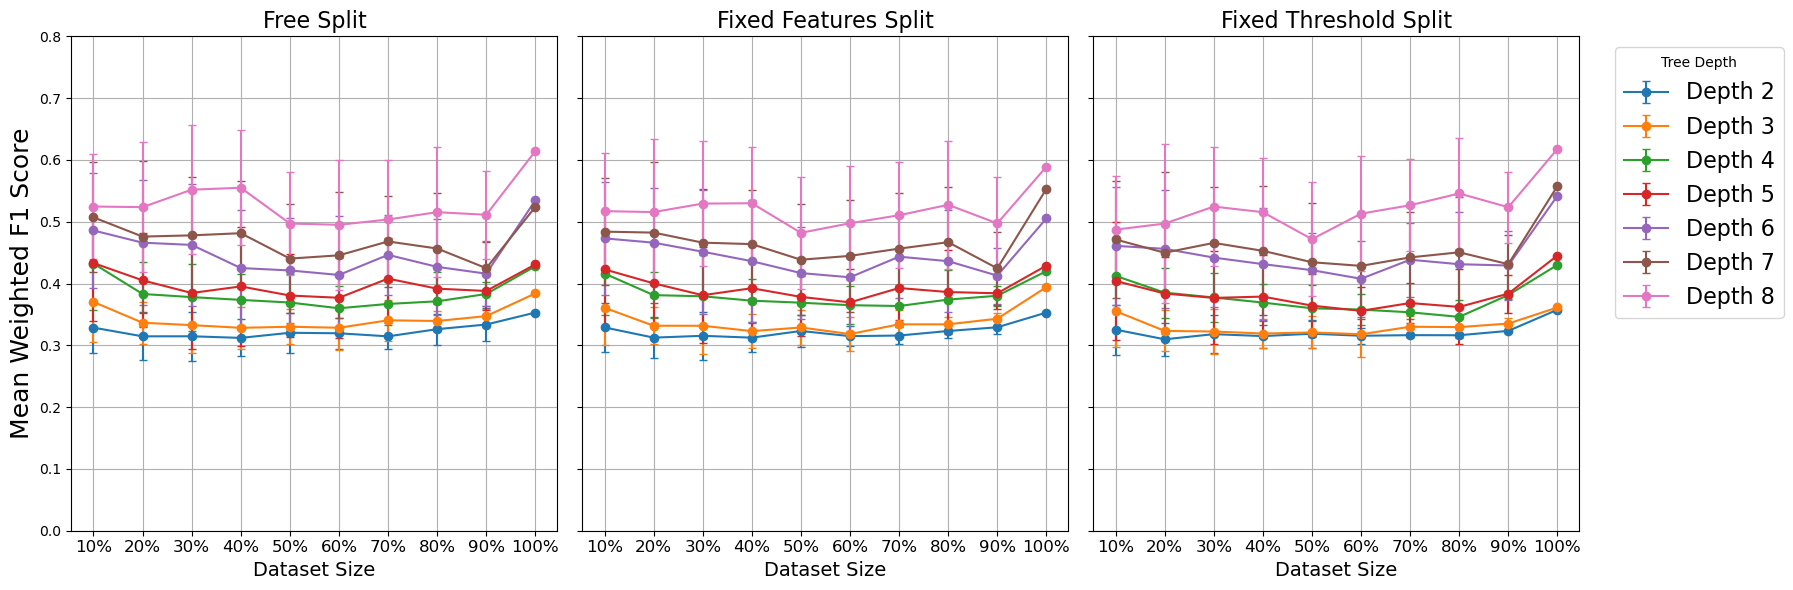

In [31]:
final_results = {}

for split_type in ['free', 'fix_feat', 'fix_thr']:
    res_mean, res_std = plot_value(final_result, 
                                   type_of_exp='KNN_kmeans_class_results', 
                                   type_of_split_=split_type, 
                                   absolute_diff_='original_feat')

    final_results[split_type] = (res_mean, res_std)

# Call the function with the properly structured dictionary
plot_r2_comparison_three_three(final_results)


In [87]:
res_mean

max_depth       0.1       0.2       0.3       0.4       0.5       0.6   
2          2  0.318835  0.351245  0.341364  0.344414  0.335535  0.348163  \
3          3  0.336329  0.367037  0.340897  0.373995  0.340069  0.370566   
4          4  0.396353  0.420653  0.405241  0.441573  0.437102  0.429721   
5          5  0.396697  0.435920  0.447198  0.432438  0.426088  0.438579   
6          6  0.422077  0.476560  0.529701  0.514246  0.478452  0.500753   
7          7  0.412530  0.468787  0.533705  0.501540  0.492679  0.518772   
8          8  0.447679  0.532751  0.554798  0.552756  0.570730  0.547746   

   0.7000000000000001       0.8       0.9       1.0 absolute_diff_   
2            0.305711  0.334242  0.321024  0.307551  original_feat  \
3            0.331544  0.355498  0.356365  0.335167  original_feat   
4            0.402874  0.412169  0.425748  0.401689  original_feat   
5            0.394095  0.436195  0.422198  0.415882  original_feat   
6            0.453750  0.495673  0.515469  0.550336  original_feat   
7            0.488135  0.502480  0.521743  0.543744  original_feat   
8            0.545531  0.574804  0.559344  0.583154  original_feat   

  type_of_split_         type_of_exp  
2        fix_thr  KNN_random_results  
3        fix_thr  KNN_random_results  
4        fix_thr  KNN_random_results  
5        fix_thr  KNN_random_results  
6        fix_thr  KNN_random_results  
7        fix_thr  KNN_random_results  
8        fix_thr  KNN_random_results

In [88]:
res_std

max_depth       0.1       0.2       0.3       0.4       0.5       0.6   
2          2  0.129205  0.091030  0.100339  0.088130  0.088741  0.055845  \
3          3  0.115176  0.086398  0.105295  0.067832  0.091227  0.069394   
4          4  0.115801  0.100029  0.098882  0.064934  0.081645  0.066101   
5          5  0.114872  0.072592  0.061875  0.063300  0.067467  0.078679   
6          6  0.110676  0.106398  0.103737  0.062560  0.077702  0.081262   
7          7  0.115484  0.117183  0.099490  0.062277  0.068689  0.066368   
8          8  0.151946  0.097470  0.096814  0.075798  0.080188  0.083626   

   0.7000000000000001       0.8       0.9       1.0 absolute_diff_   
2            0.088551  0.056160  0.077450  0.053536  original_feat  \
3            0.097361  0.051057  0.057429  0.074098  original_feat   
4            0.101701  0.065209  0.046816  0.052013  original_feat   
5            0.090897  0.087252  0.059563  0.069373  original_feat   
6            0.067075  0.051843  0.060485  0.054510  original_feat   
7            0.079667  0.064627  0.073199  0.043967  original_feat   
8            0.078626  0.102371  0.063332  0.049046  original_feat   

  type_of_split_         type_of_exp  
2        fix_thr  KNN_random_results  
3        fix_thr  KNN_random_results  
4        fix_thr  KNN_random_results  
5        fix_thr  KNN_random_results  
6        fix_thr  KNN_random_results  
7        fix_thr  KNN_random_results  
8        fix_thr  KNN_random_results

In [75]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_r2_vs_dataset_size(df_grouped_mean: pd.DataFrame, df_grouped_std: pd.DataFrame):
    """
    Plots R² score vs dataset size for different max depths, with standard deviation as error bars.
    
    Parameters:
    df_grouped_mean (pd.DataFrame): DataFrame containing the mean R² scores with 'max_depth' as the first column.
    df_grouped_std (pd.DataFrame): DataFrame containing the standard deviations with 'max_depth' as the first column.
    """
    plt.figure(figsize=(10, 6))

    absolute_diff_ = df_grouped_mean.iloc[0]['absolute_diff_']
    type_of_split_ = df_grouped_mean.iloc[0]['type_of_split_']
    type_of_exp = df_grouped_mean.iloc[0]['type_of_exp']
    
    df_grouped_mean = df_grouped_mean.drop(columns = ['absolute_diff_','type_of_split_','type_of_exp'])
    df_grouped_std = df_grouped_std.drop(columns = ['absolute_diff_','type_of_split_','type_of_exp'])
    
    # Extract dataset sizes (columns) and format them as percentages
    dataset_sizes = df_grouped_mean.columns[1:].astype(float)
    
    x_labels = [f"{int(size * 100)}%" for size in dataset_sizes]
    
    # Iterate over each row (each max depth)
    for _, row in df_grouped_mean.iterrows():
        depth = int(row["max_depth"])
        mean_values = row[1:].values
        std_values = df_grouped_std[df_grouped_std["max_depth"] == depth].iloc[:, 1:].values.flatten()

        # Plot with error bars
        plt.errorbar(dataset_sizes, mean_values, yerr=std_values, label=f"Depth {depth}", marker='o', capsize=3)

    # Labels, title, and legend
    plt.xlabel(f"Dataset Size", fontsize=18)
    plt.ylabel("Mean R² Score on Test Sets", fontsize=18)
    #plt.title(f"R² Score vs Dataset Size for Different Max Depths (with Std Dev) - {dict_type_of_split_[type_of_split_]}", fontsize=18)
    plt.title(f"{dict_type_of_exp[type_of_exp]} - {dict_type_of_split_[type_of_split_]} Split on {dict_abs[absolute_diff_]} Avg. Performance", fontsize=18)
    plt.xticks(dataset_sizes, x_labels, fontsize=18)  # Format x-axis as percentages
    plt.yticks(fontsize=18)
    
    # Set y-axis limits
    plt.ylim(-0.3, 0.9)

    plt.legend(title="Tree Depth", fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True)

    # Show plot
    plt.show()


### Random Experiment

In [172]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_r2_vs_dataset_size(df_grouped_mean: pd.DataFrame, df_grouped_std: pd.DataFrame, ax=None):
    """
    Plots R² score vs dataset size for different max depths, with standard deviation as error bars.
    
    Parameters:
    df_grouped_mean (pd.DataFrame): DataFrame containing the mean R² scores with 'max_depth' as the first column.
    df_grouped_std (pd.DataFrame): DataFrame containing the standard deviations with 'max_depth' as the first column.
    ax (matplotlib axis, optional): The axis to plot on. If None, creates a new plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    # Extracting necessary information
    absolute_diff_ = df_grouped_mean.iloc[0]['absolute_diff_']
    type_of_split_ = df_grouped_mean.iloc[0]['type_of_split_']
    type_of_exp = df_grouped_mean.iloc[0]['type_of_exp']
    
    # Dropping columns not needed for plotting
    df_grouped_mean = df_grouped_mean.drop(columns=['absolute_diff_', 'type_of_split_', 'type_of_exp'])
    df_grouped_std = df_grouped_std.drop(columns=['absolute_diff_', 'type_of_split_', 'type_of_exp'])
    
    # Extract dataset sizes (columns) and format them as percentages
    dataset_sizes = df_grouped_mean.columns[1:].astype(float)
    x_labels = [f"{int(size * 100)}%" for size in dataset_sizes]
    
    # Iterate over each row (each max depth)
    for _, row in df_grouped_mean.iterrows():
        depth = int(row["max_depth"])
        mean_values = row[1:].values
        std_values = df_grouped_std[df_grouped_std["max_depth"] == depth].iloc[:, 1:].values.flatten()

        # Plot with error bars on the specified axis
        ax.errorbar(dataset_sizes, mean_values, yerr=std_values, label=f"Depth {depth}", marker='o', capsize=3)

    # Set plot labels, title, and legend
    ax.set_xlabel("Dataset Size", fontsize=18)
    ax.set_ylabel("Mean R² Score on Test Sets", fontsize=18)
    ax.set_title(f"{dict_type_of_exp[type_of_exp]} - {dict_type_of_split_[type_of_split_]} Split on {dict_abs[absolute_diff_]} Avg. Performance", fontsize=18)
    ax.set_xticks(dataset_sizes)
    ax.set_xticklabels(x_labels, fontsize=14)  # Format x-axis as percentages
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True)

    # Set y-axis limits
    ax.set_ylim(-0.3, 0.9)

    # Display the legend
    ax.legend(title="Tree Depth", fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left')

    return ax


In [173]:
random_exps_final = final_result[final_result.type_of_exp == 'random_results']
strat_random_exps_final = final_result[final_result.type_of_exp == 'stratrand_results']
kmean_exps_final = final_result[final_result.type_of_exp == 'kmeans_class_results']

In [174]:
type_of_splits  = ['free', 'fix_feat', 'fix_thr']
type_of_features = ['original_feat', 'only_difference', 'both_original_and_diff']

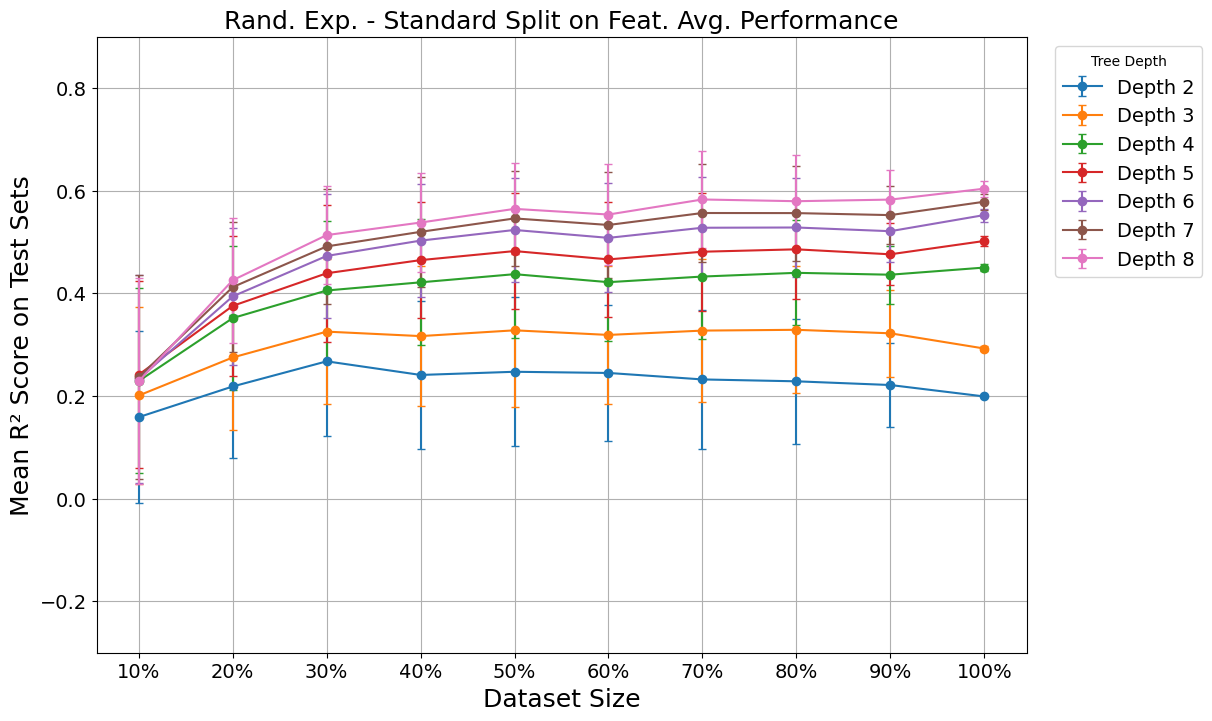

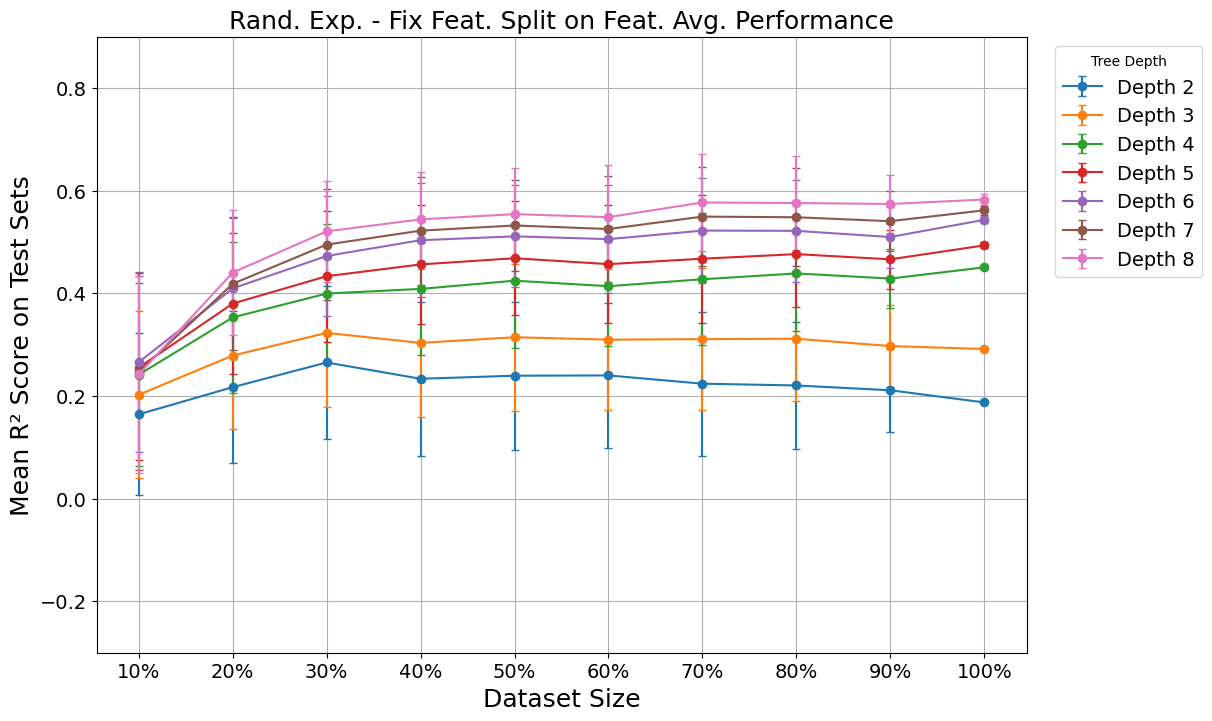

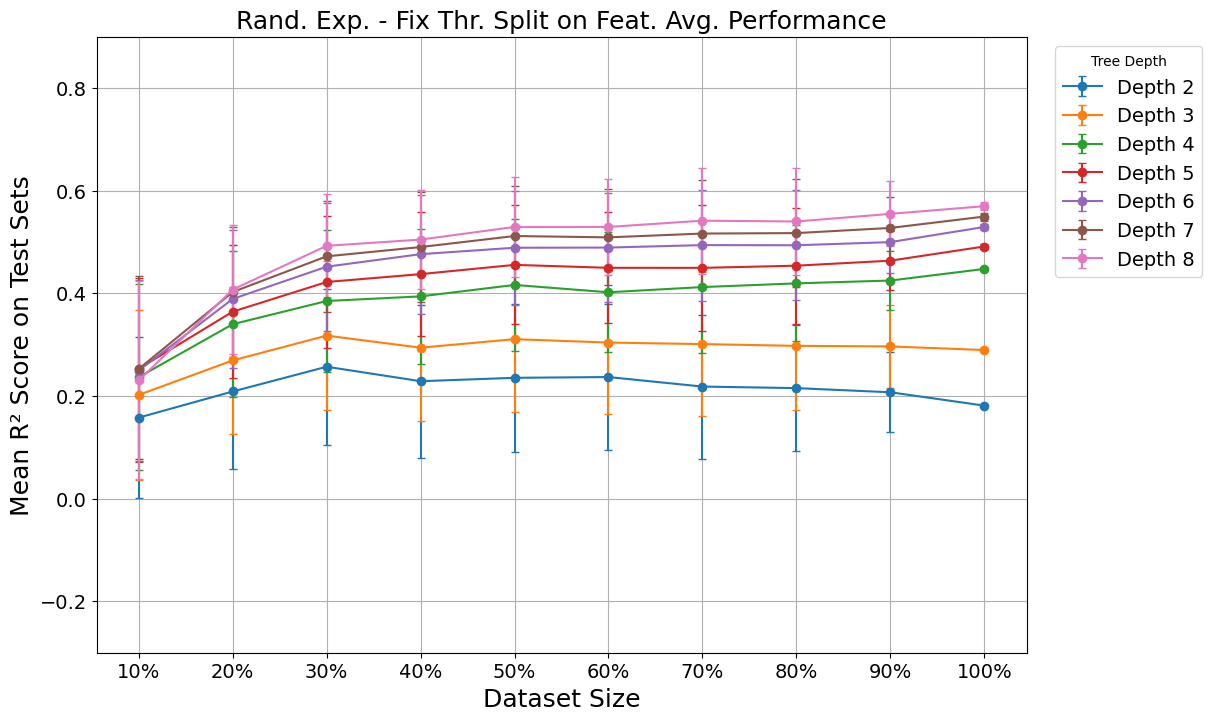

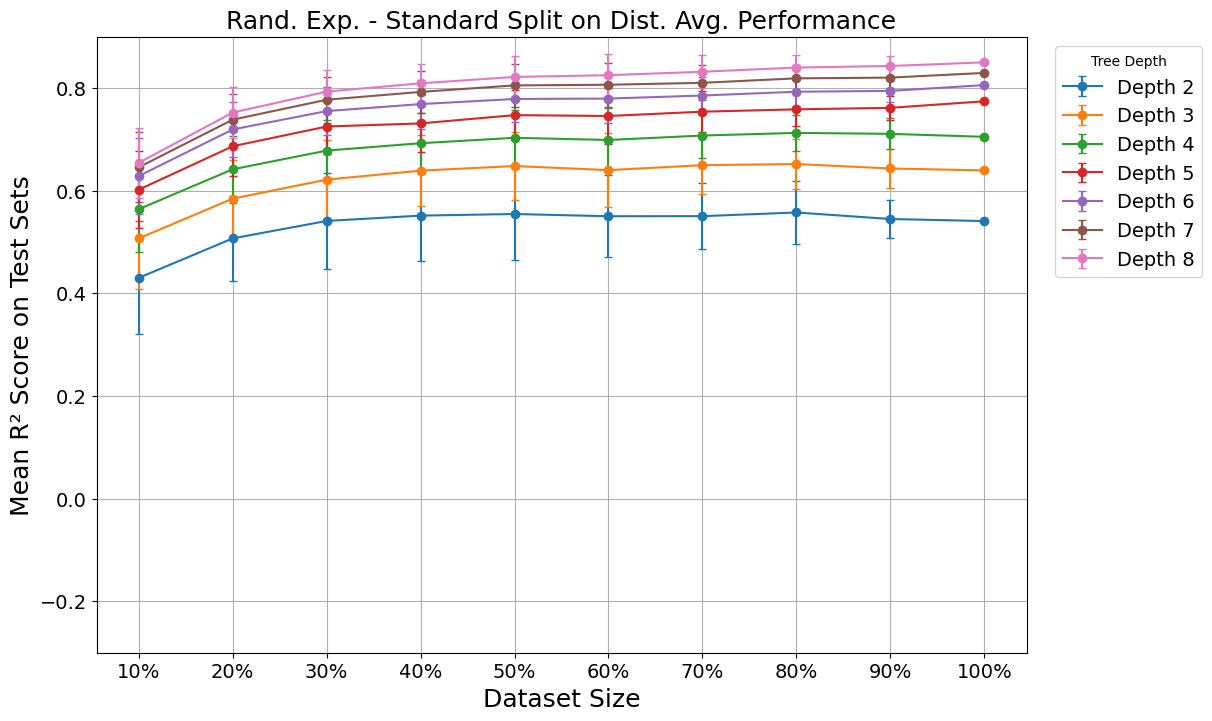

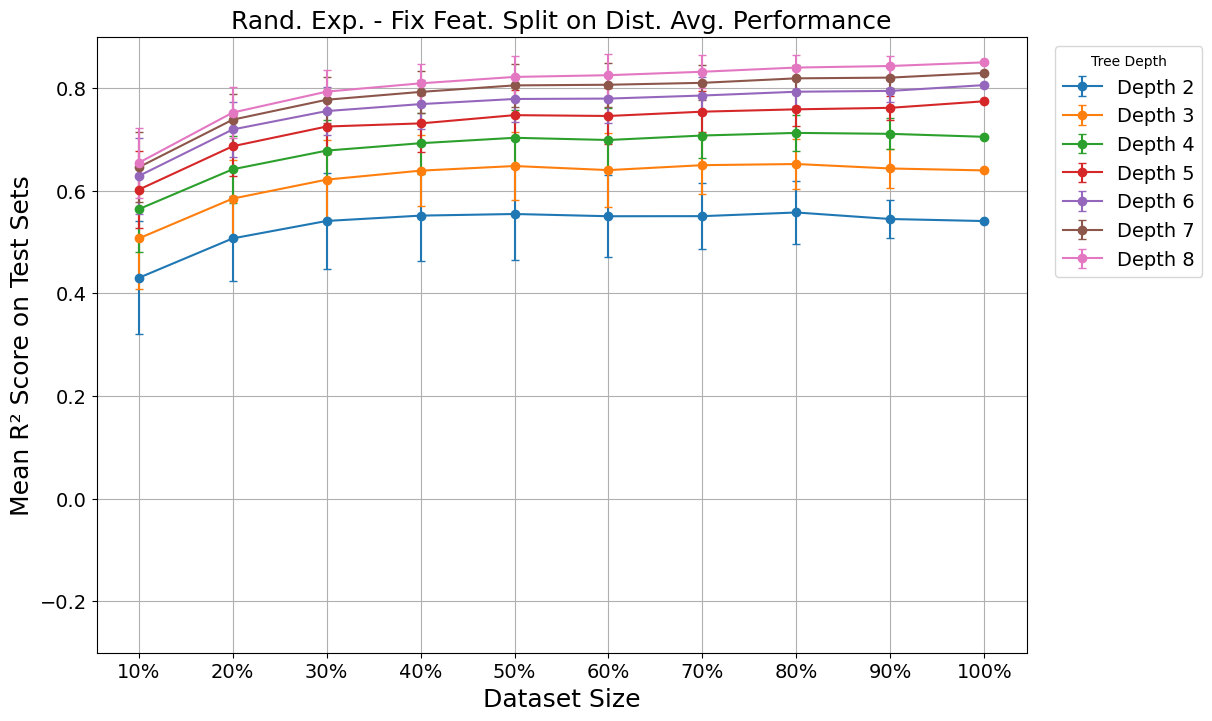

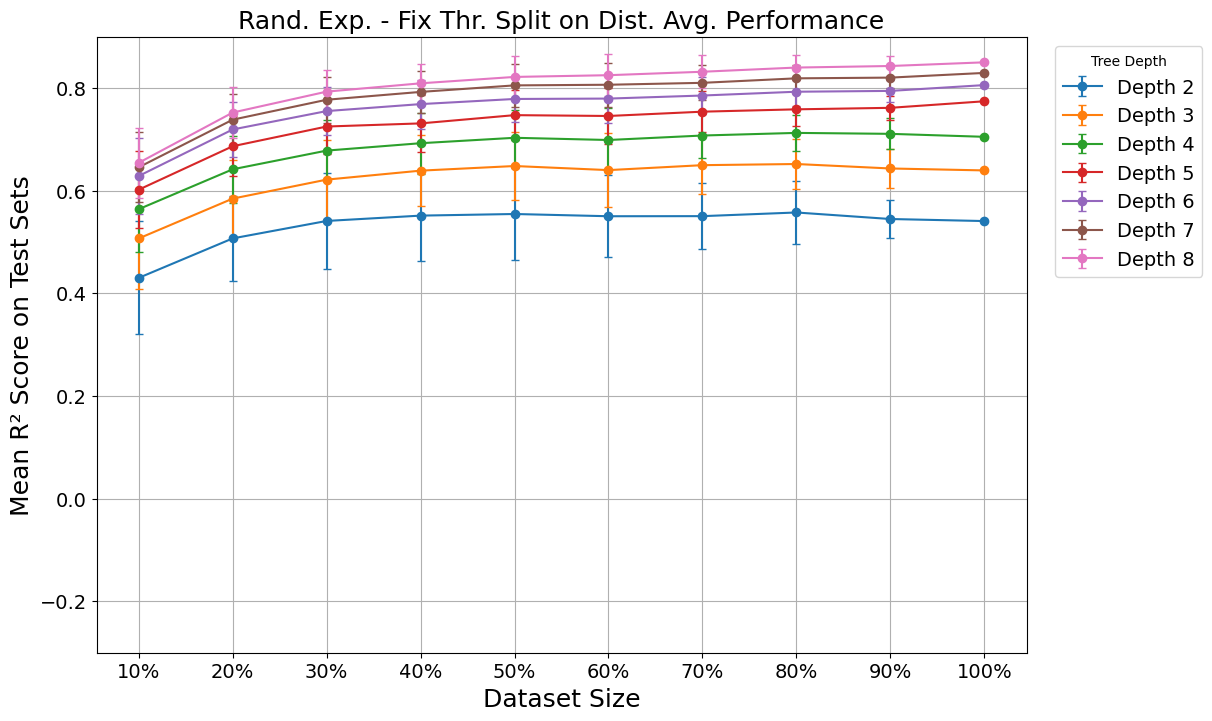

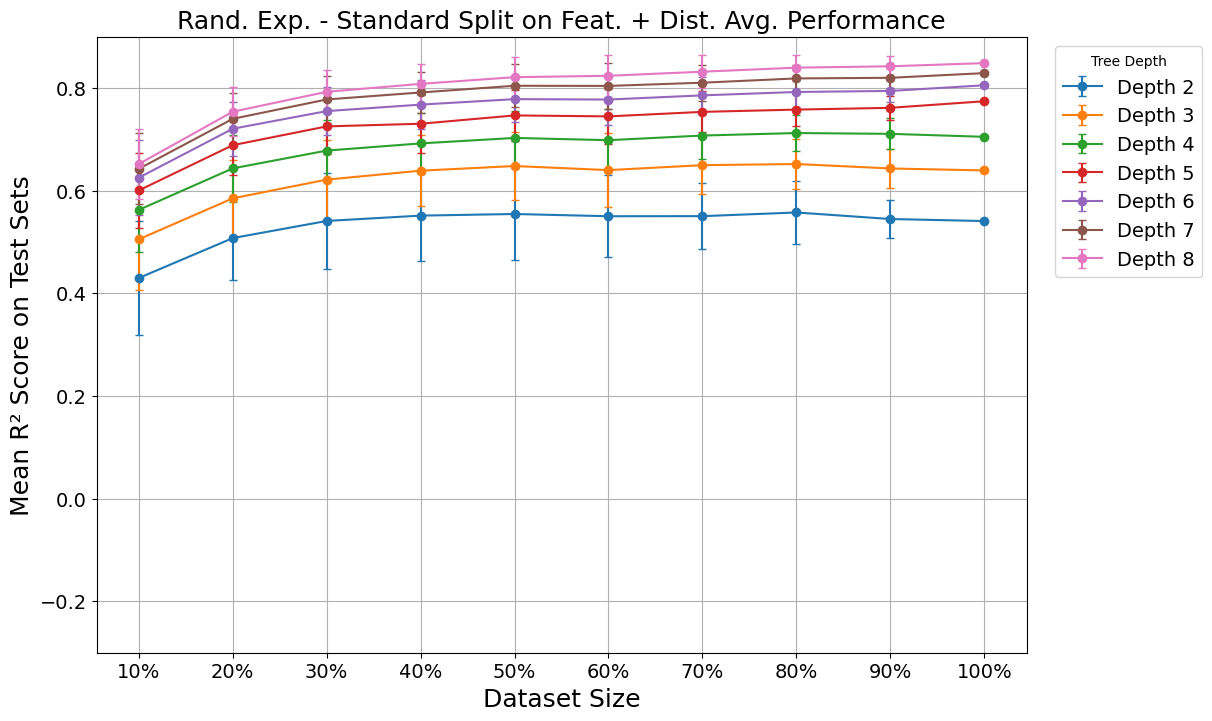

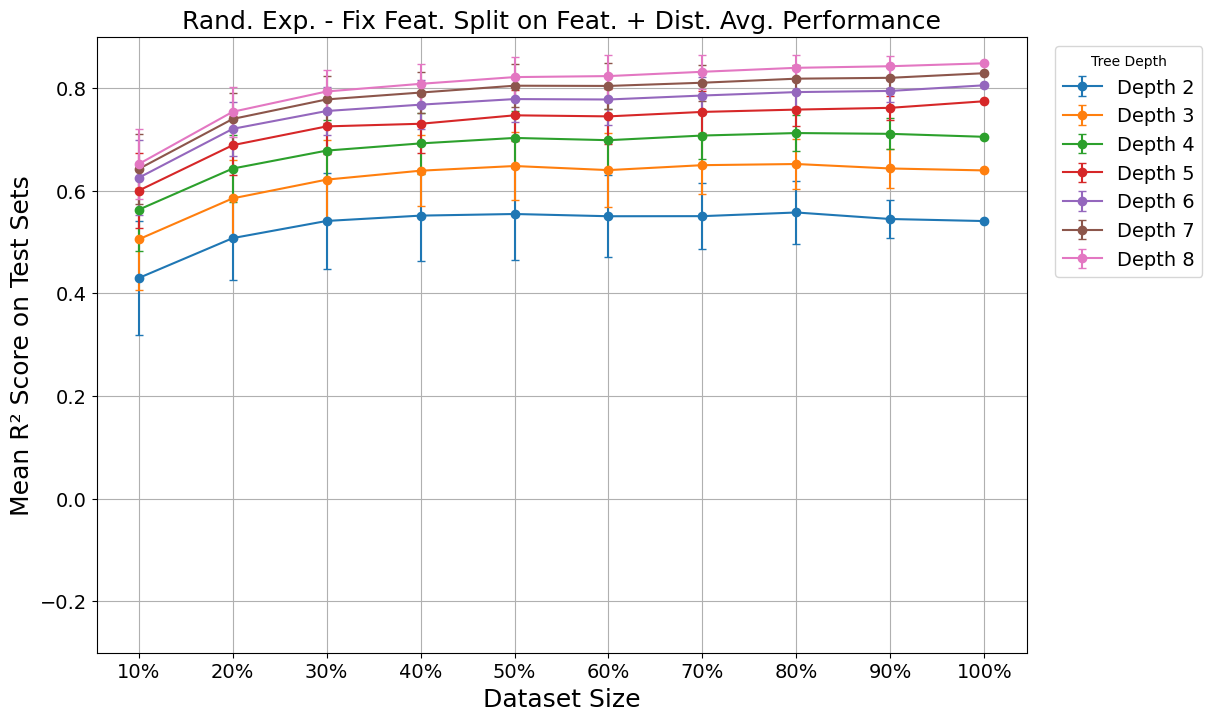

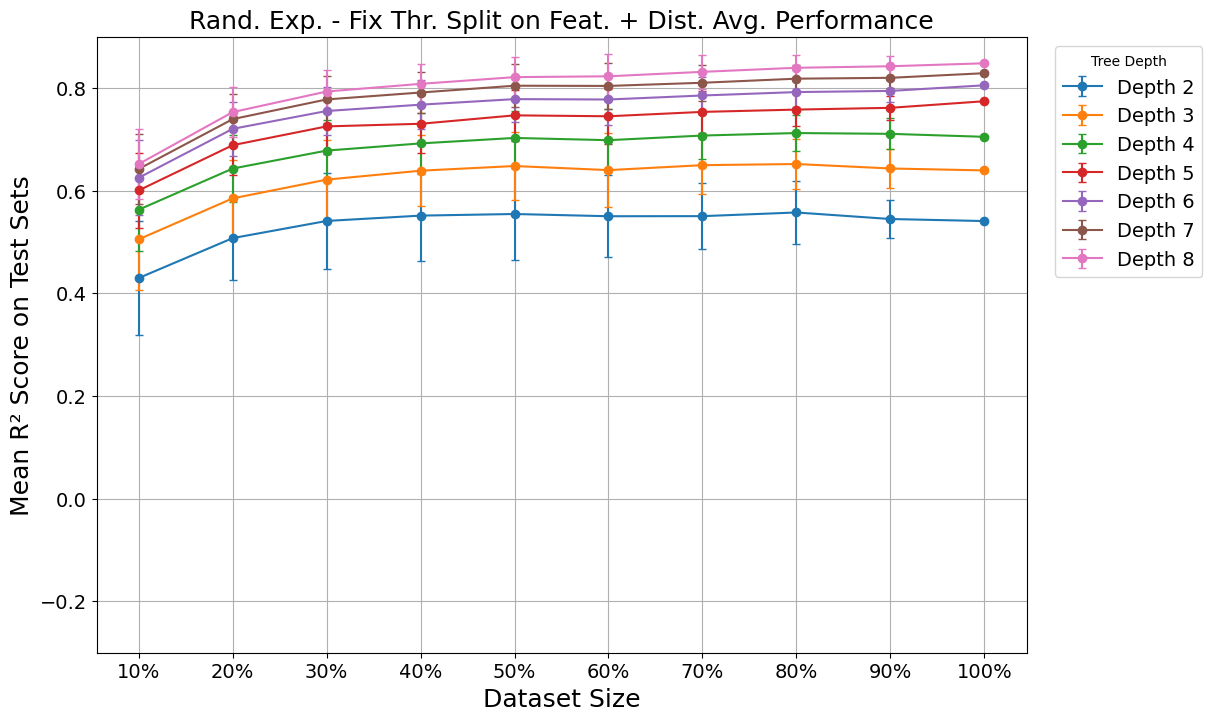

In [175]:
for type_of_feat in type_of_features:
    
    for type_of_split in type_of_splits:
        res_mean, res_std = plot_value(random_exps_final, 
                                       type_of_exp = 'random_results',
                                       type_of_split_ = type_of_split,
                                       absolute_diff_ = type_of_feat)
        plot_r2_vs_dataset_size(res_mean,res_std)
        

AttributeError: 'Figure' object has no attribute 'xlabel'

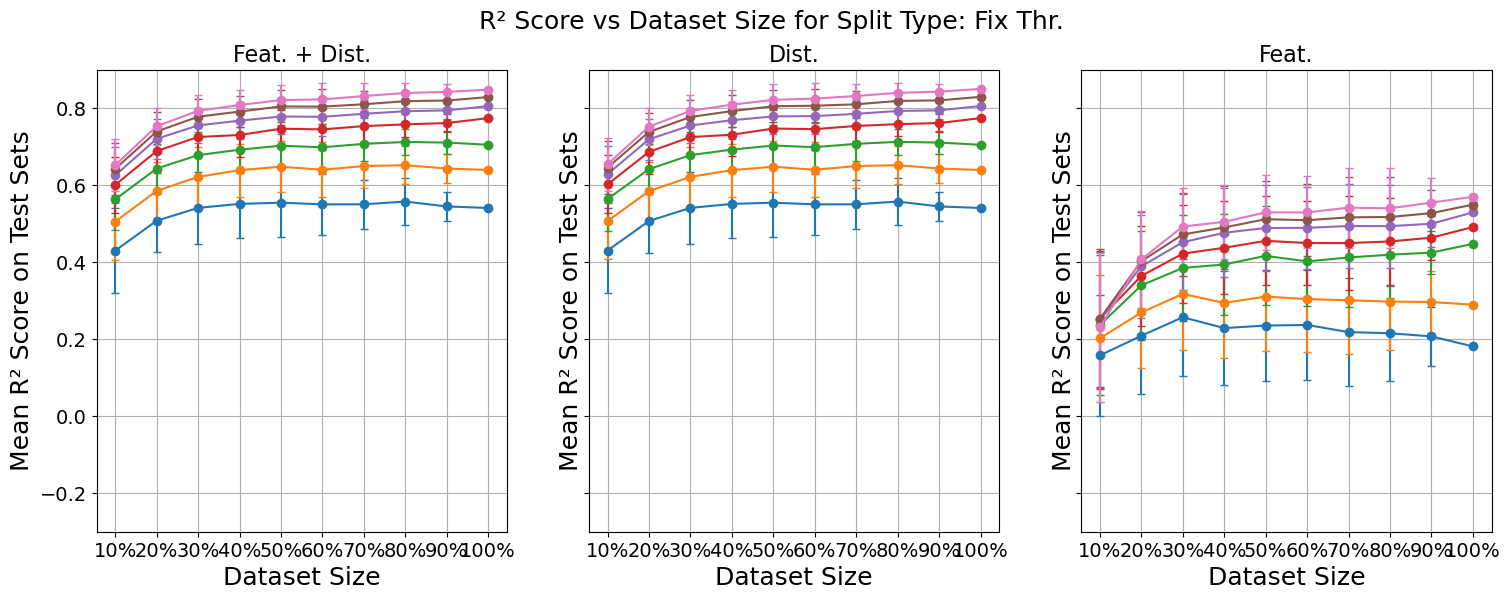

In [145]:
import matplotlib.pyplot as plt

# Create a list of `type_of_splits` and `type_of_features`
type_of_features = ['both_original_and_diff', 'only_difference', 'original_feat']  # Example values
type_of_splits = ['fix_thr', 'fix_feat', 'free']  # Example values

# Loop over each type_of_split and create a separate figure for each
for type_of_split in type_of_splits:
    # Set up the figure and subplots for this `type_of_split`
    fig, axes = plt.subplots(1, len(type_of_features), figsize=(18, 6), sharey=True)

    # Loop over each `type_of_feature`
    for i, type_of_feat in enumerate(type_of_features):
        # Get the results for the given combination of `type_of_split` and `type_of_feat`
        res_mean, res_std = plot_value(random_exps_final, 
                                       type_of_exp='random_results',
                                       type_of_split_=type_of_split,
                                       absolute_diff_=type_of_feat)

        # Plot the R² score vs dataset size on the corresponding subplot
        plot_r2_vs_dataset_size(res_mean, res_std, ax=axes[i])

        # Set the title for each subplot
        axes[i].set_title(f"{dict_abs[type_of_feat]}", fontsize=16)

    # Add common labels and title for the current figure
    fig.suptitle(f"R² Score vs Dataset Size for Split Type: {dict_type_of_split_[type_of_split]}", fontsize=18)
    fig.xlabel("Dataset Size", fontsize=18)
    fig.ylabel("Mean R² Score", fontsize=18)

    # Adjust layout to avoid overlap and make space for the main title
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust title spacing

    # Show the plot for the current `type_of_split`
    plt.show()


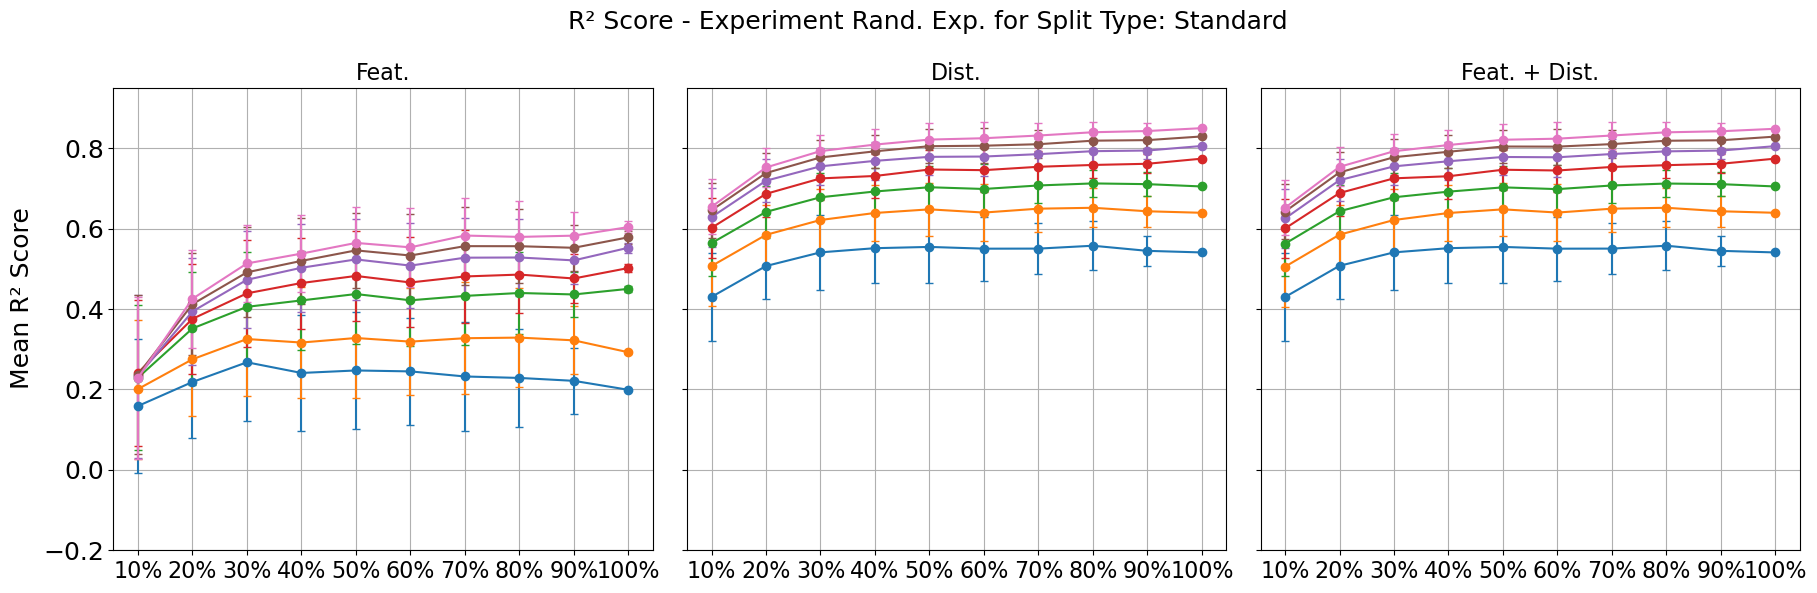

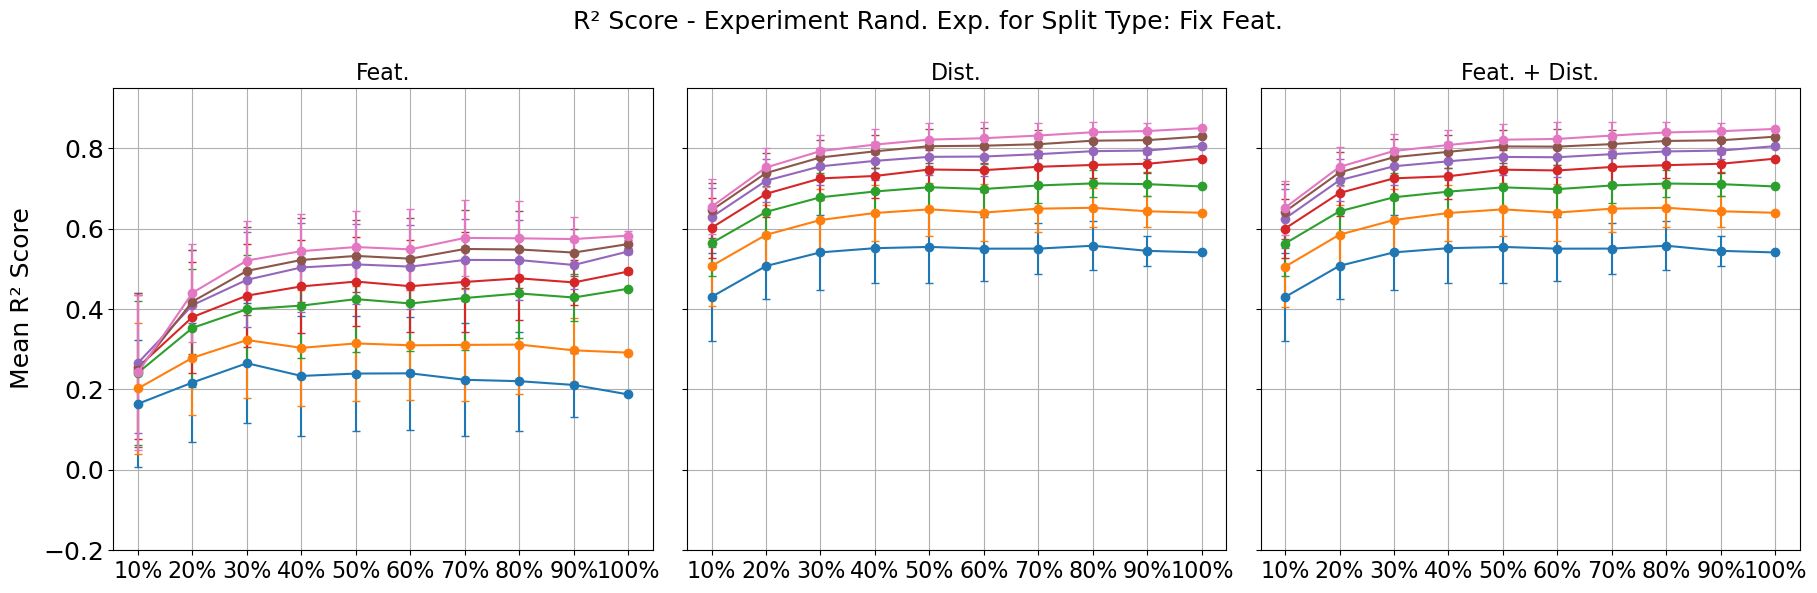

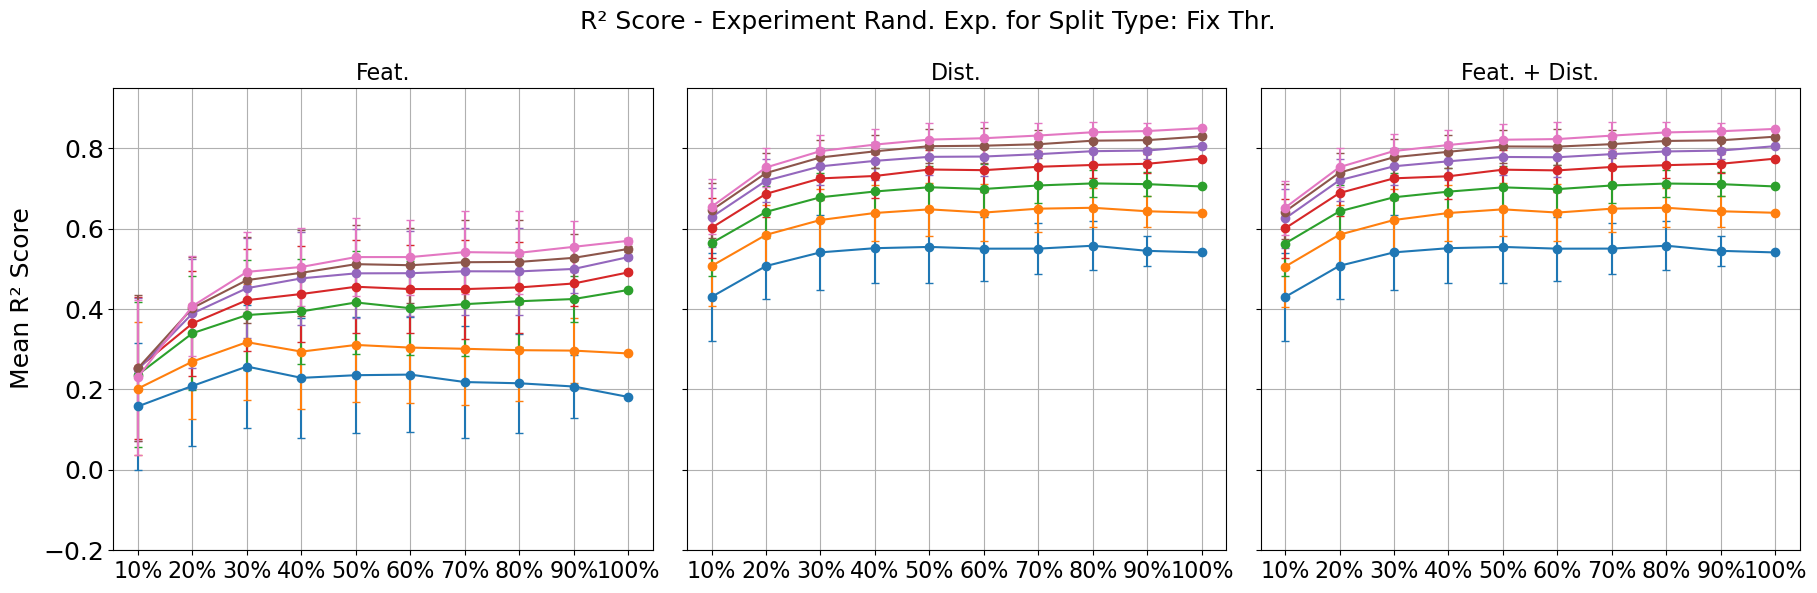

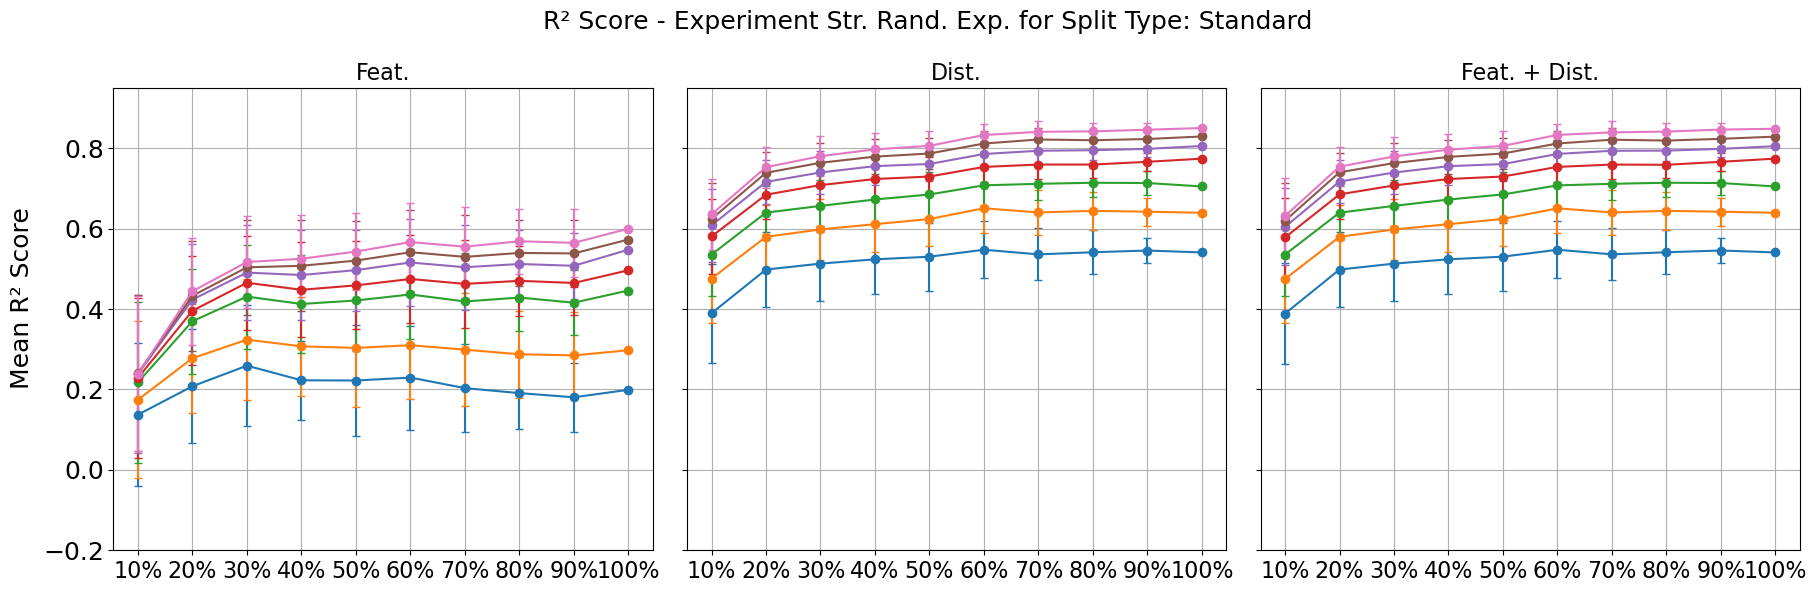

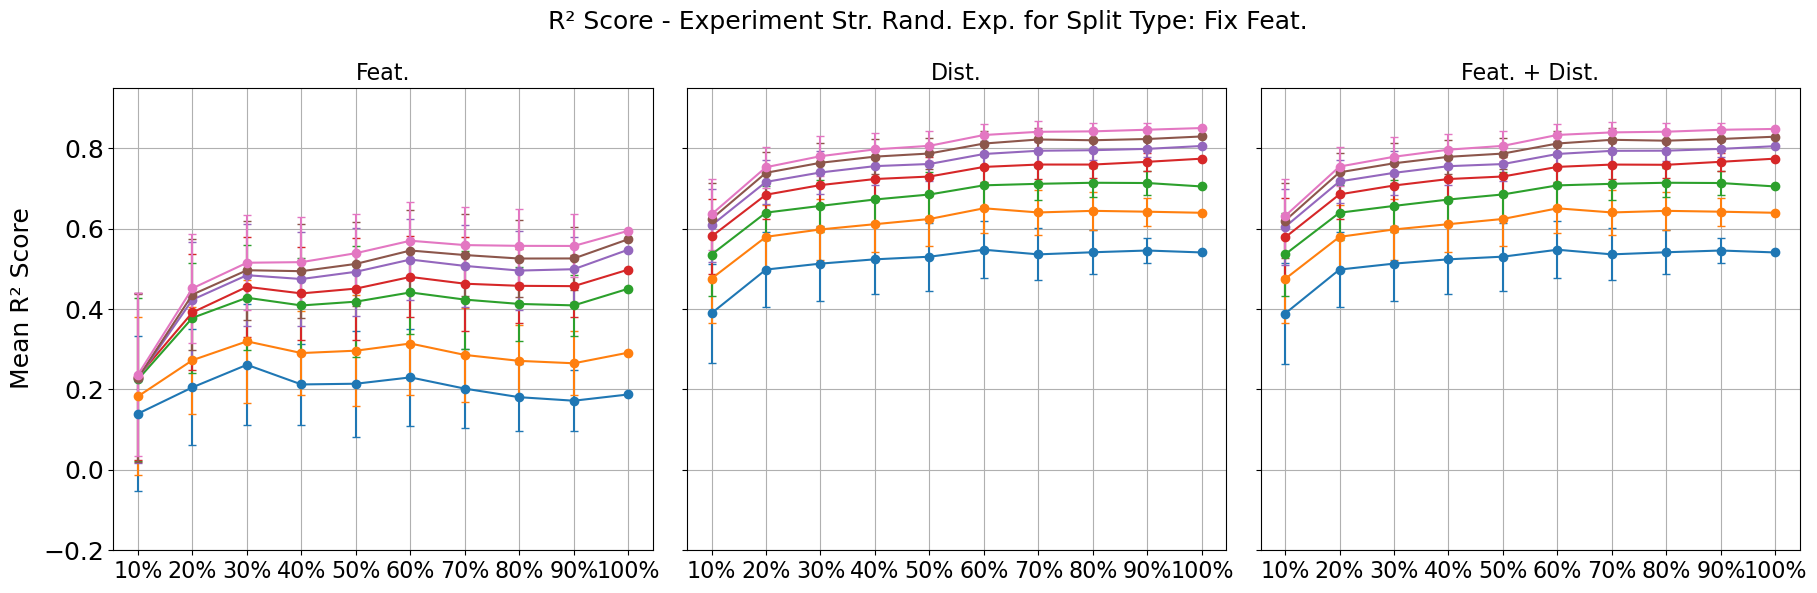

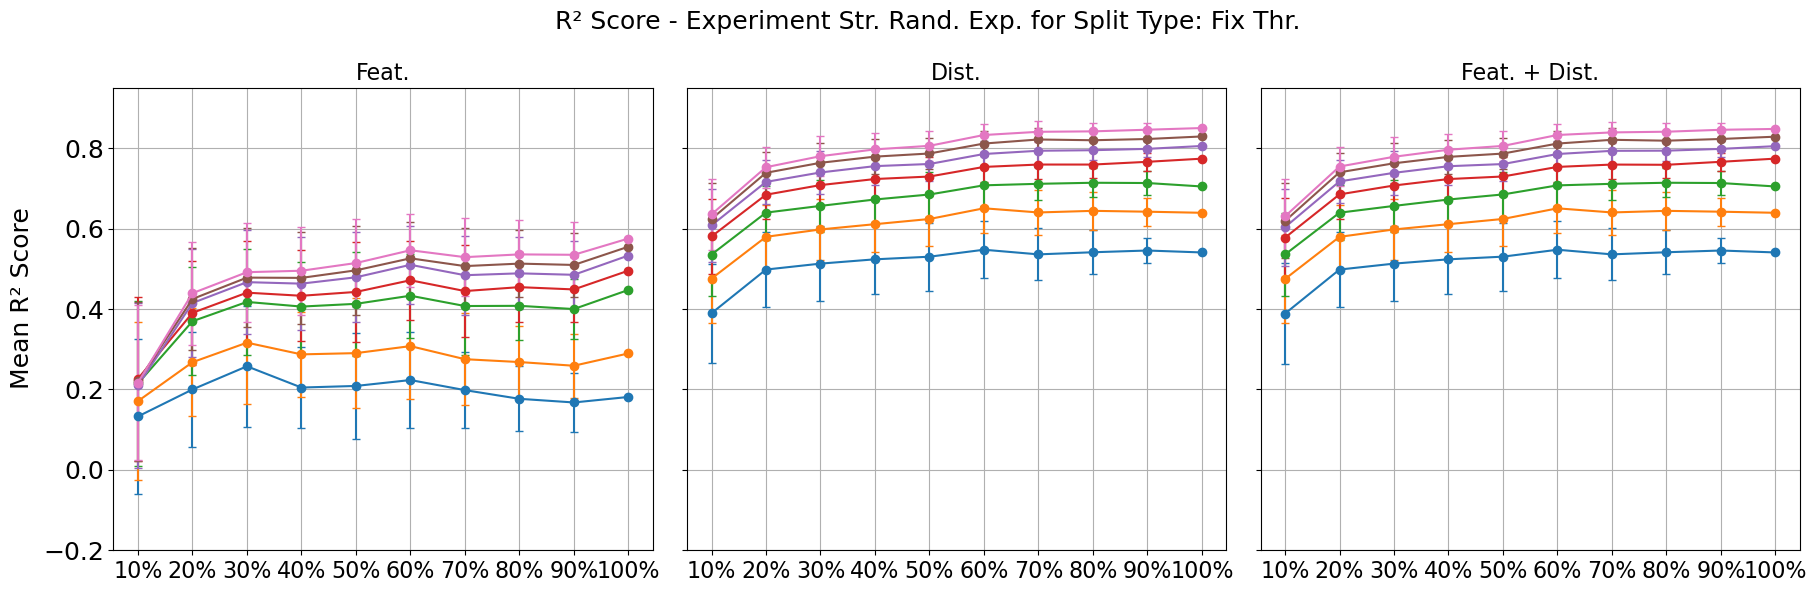

In [164]:
import matplotlib.pyplot as plt

# The `plot_r2_vs_dataset_size` function
def plot_r2_vs_dataset_size(df_grouped_mean: pd.DataFrame, df_grouped_std: pd.DataFrame, ax=None):
    """
    Plots R² score vs dataset size for different max depths, with standard deviation as error bars.
    
    Parameters:
    df_grouped_mean (pd.DataFrame): DataFrame containing the mean R² scores with 'max_depth' as the first column.
    df_grouped_std (pd.DataFrame): DataFrame containing the standard deviations with 'max_depth' as the first column.
    ax (matplotlib axis, optional): The axis to plot on. If None, creates a new plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))

    # Extracting necessary information
    absolute_diff_ = df_grouped_mean.iloc[0]['absolute_diff_']
    type_of_split_ = df_grouped_mean.iloc[0]['type_of_split_']
    type_of_exp = df_grouped_mean.iloc[0]['type_of_exp']
    
    # Dropping columns not needed for plotting
    df_grouped_mean = df_grouped_mean.drop(columns=['absolute_diff_', 'type_of_split_', 'type_of_exp'])
    df_grouped_std = df_grouped_std.drop(columns=['absolute_diff_', 'type_of_split_', 'type_of_exp'])
    
    # Extract dataset sizes (columns) and format them as percentages
    dataset_sizes = df_grouped_mean.columns[1:].astype(float)
    x_labels = [f"{int(size * 100)}%" for size in dataset_sizes]
    
    # Iterate over each row (each max depth)
    for _, row in df_grouped_mean.iterrows():
        depth = int(row["max_depth"])
        mean_values = row[1:].values
        std_values = df_grouped_std[df_grouped_std["max_depth"] == depth].iloc[:, 1:].values.flatten()

        # Plot with error bars on the specified axis
        ax.errorbar(dataset_sizes, mean_values, yerr=std_values, label=f"Depth {depth}", marker='o', capsize=3)

    # Set plot title, xticks, and formatting
    ax.set_title(f"{dict_type_of_exp[type_of_exp]} - {dict_type_of_split_[type_of_split_]} Split on {dict_abs[absolute_diff_]} Avg. Performance", fontsize=18)
    ax.set_xticks(dataset_sizes)
    ax.set_xticklabels(x_labels, fontsize=16)  # Format x-axis as percentages
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(True)

    # Set y-axis limits
    #ax.set_ylim(-0.2, 0.9)
    ax.set_ylim(-0.2, 0.95)

    # Display the legend (if needed)
    # ax.legend(title="Tree Depth", fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left')

    return ax


# Create a list of `type_of_splits` and `type_of_features`
type_of_features = ['original_feat', 'only_difference', 'both_original_and_diff']  # Example values
type_of_splits = ['free', 'fix_feat', 'fix_thr']  # Example values
type_of_exp = 'stratrand_results' 

# Loop over each type_of_split and create a separate figure for each
for type_of_split in type_of_splits:
    # Set up the figure and subplots for this `type_of_split`
    fig, axes = plt.subplots(1, len(type_of_features), figsize=(18, 6), sharey=True)

    # Loop over each `type_of_feature`
    for i, type_of_feat in enumerate(type_of_features):
        # Get the results for the given combination of `type_of_split` and `type_of_feat`
        res_mean, res_std = plot_value(strat_random_exps_final, 
                                       type_of_exp='stratrand_results',
                                       type_of_split_=type_of_split,
                                       absolute_diff_=type_of_feat)

        # Plot the R² score vs dataset size on the corresponding subplot
        plot_r2_vs_dataset_size(res_mean, res_std, ax=axes[i])

        # Set the title for each subplot
        axes[i].set_title(f"{dict_abs[type_of_feat]}", fontsize=16)

    # Add common labels and title for the current figure
    fig.suptitle(f"R² Score - Experiment {dict_type_of_exp[type_of_exp]} for Split Type: {dict_type_of_split_[type_of_split]}", fontsize=18)

    # Set the common x and y labels for the whole figure
    #fig.text(0.5, 0.04, 'Dataset Size', ha='center', fontsize=18)
    fig.text(-0.01, 0.5, 'Mean R² Score', va='center', rotation='vertical', fontsize=18)

    # Adjust layout to avoid overlap and make space for the main title
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust title spacing

    # Show the plot for the current `type_of_split`
    plt.show()


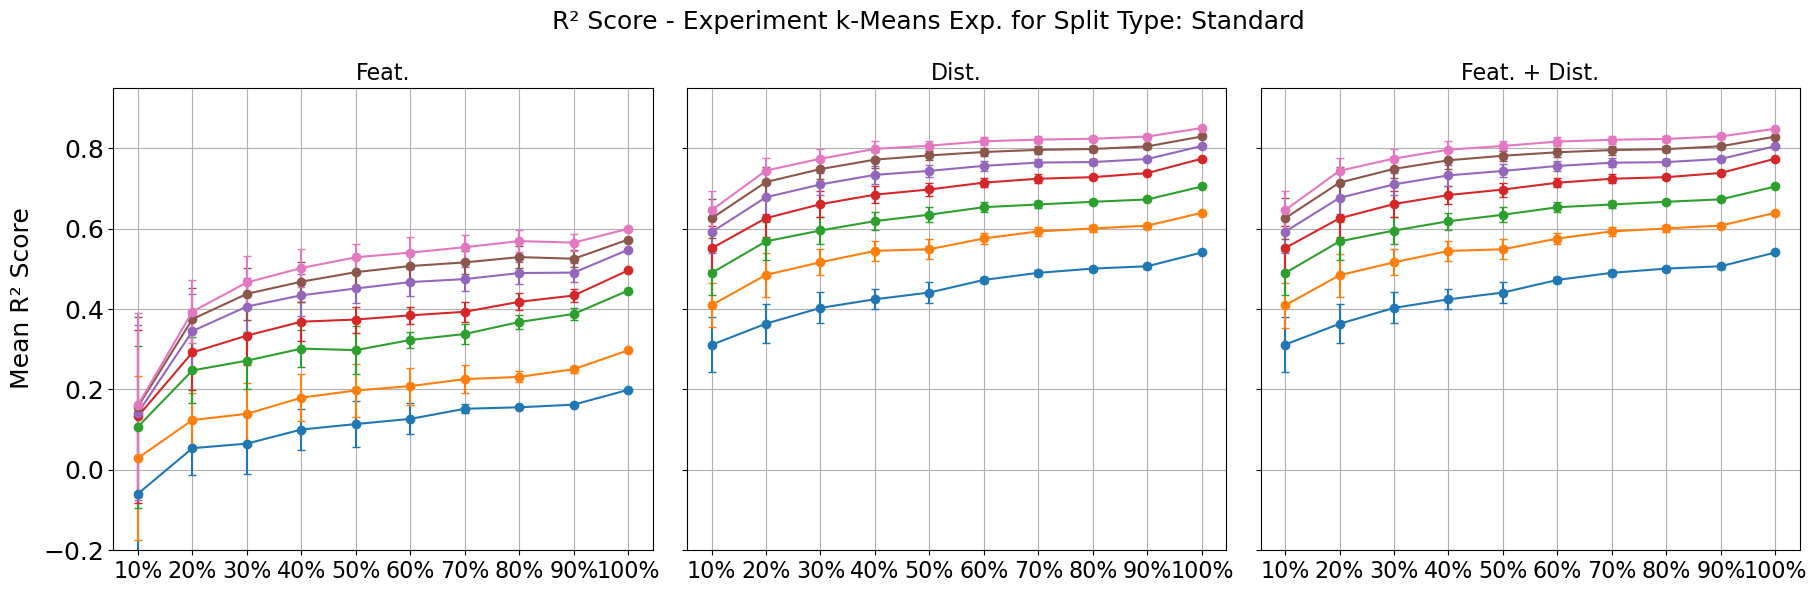

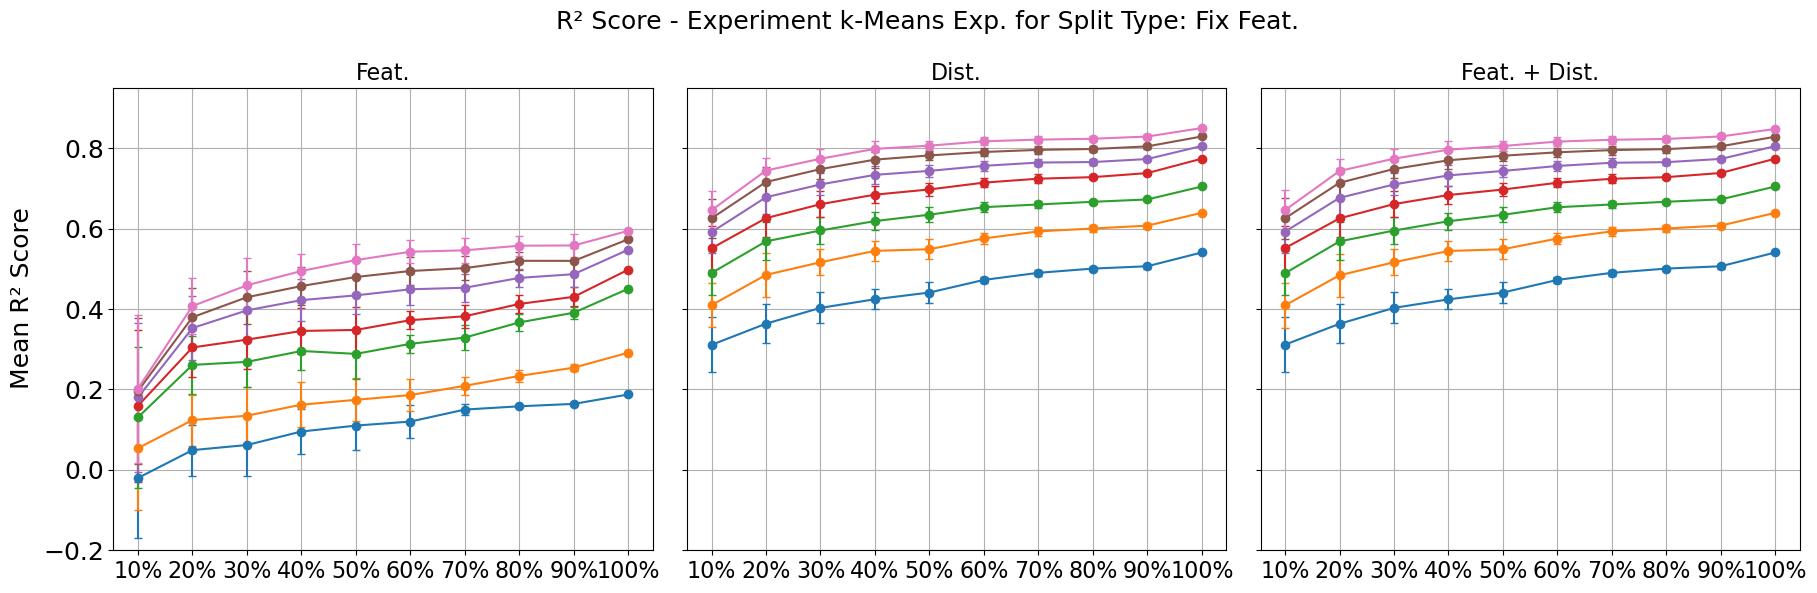

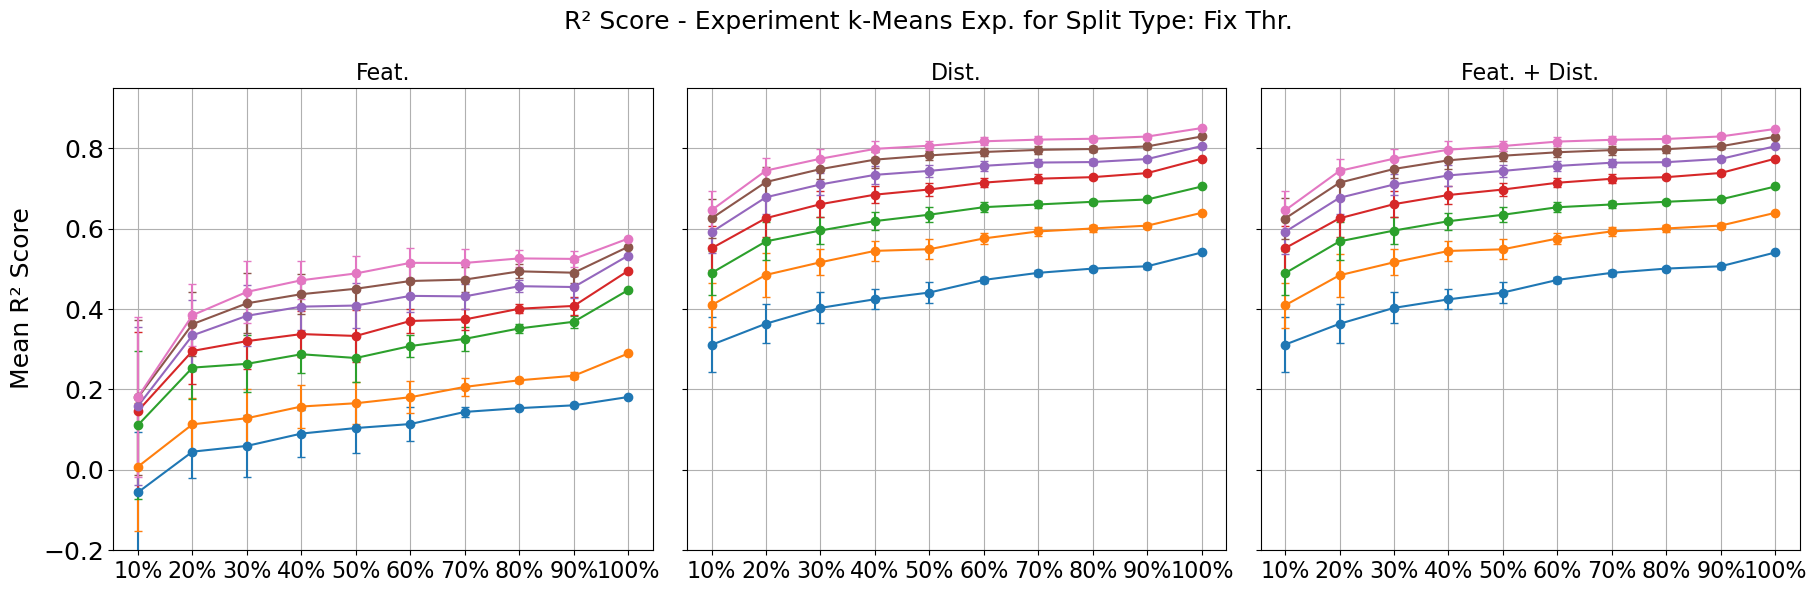

In [166]:
import matplotlib.pyplot as plt

# The `plot_r2_vs_dataset_size` function
def plot_r2_vs_dataset_size(df_grouped_mean: pd.DataFrame, df_grouped_std: pd.DataFrame, ax=None):
    """
    Plots R² score vs dataset size for different max depths, with standard deviation as error bars.
    
    Parameters:
    df_grouped_mean (pd.DataFrame): DataFrame containing the mean R² scores with 'max_depth' as the first column.
    df_grouped_std (pd.DataFrame): DataFrame containing the standard deviations with 'max_depth' as the first column.
    ax (matplotlib axis, optional): The axis to plot on. If None, creates a new plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))

    # Extracting necessary information
    absolute_diff_ = df_grouped_mean.iloc[0]['absolute_diff_']
    type_of_split_ = df_grouped_mean.iloc[0]['type_of_split_']
    type_of_exp = df_grouped_mean.iloc[0]['type_of_exp']
    
    # Dropping columns not needed for plotting
    df_grouped_mean = df_grouped_mean.drop(columns=['absolute_diff_', 'type_of_split_', 'type_of_exp'])
    df_grouped_std = df_grouped_std.drop(columns=['absolute_diff_', 'type_of_split_', 'type_of_exp'])
    
    # Extract dataset sizes (columns) and format them as percentages
    dataset_sizes = df_grouped_mean.columns[1:].astype(float)
    x_labels = [f"{int(size * 100)}%" for size in dataset_sizes]
    
    # Iterate over each row (each max depth)
    for _, row in df_grouped_mean.iterrows():
        depth = int(row["max_depth"])
        mean_values = row[1:].values
        std_values = df_grouped_std[df_grouped_std["max_depth"] == depth].iloc[:, 1:].values.flatten()

        # Plot with error bars on the specified axis
        ax.errorbar(dataset_sizes, mean_values, yerr=std_values, label=f"Depth {depth}", marker='o', capsize=3)

    # Set plot title, xticks, and formatting
    ax.set_title(f"{dict_type_of_exp[type_of_exp]} - {dict_type_of_split_[type_of_split_]} Split on {dict_abs[absolute_diff_]} Avg. Performance", fontsize=18)
    ax.set_xticks(dataset_sizes)
    ax.set_xticklabels(x_labels, fontsize=16)  # Format x-axis as percentages
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(True)

    # Set y-axis limits
    #ax.set_ylim(-0.2, 0.9)
    ax.set_ylim(-0.2, 0.95)

    # Display the legend (if needed)
    # ax.legend(title="Tree Depth", fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left')

    return ax


# Create a list of `type_of_splits` and `type_of_features`
type_of_features = ['original_feat', 'only_difference', 'both_original_and_diff']  # Example values
type_of_splits = ['free', 'fix_feat', 'fix_thr']  # Example values
type_of_exp = 'kmeans_class_results' 



# Loop over each type_of_split and create a separate figure for each
for type_of_split in type_of_splits:
    # Set up the figure and subplots for this `type_of_split`
    fig, axes = plt.subplots(1, len(type_of_features), figsize=(18, 6), sharey=True)

    # Loop over each `type_of_feature`
    for i, type_of_feat in enumerate(type_of_features):
        # Get the results for the given combination of `type_of_split` and `type_of_feat`
        res_mean, res_std = plot_value(kmean_exps_final, 
                                       type_of_exp='kmeans_class_results',
                                       type_of_split_=type_of_split,
                                       absolute_diff_=type_of_feat)

        # Plot the R² score vs dataset size on the corresponding subplot
        plot_r2_vs_dataset_size(res_mean, res_std, ax=axes[i])

        # Set the title for each subplot
        axes[i].set_title(f"{dict_abs[type_of_feat]}", fontsize=16)

    # Add common labels and title for the current figure
    fig.suptitle(f"R² Score - Experiment {dict_type_of_exp[type_of_exp]} for Split Type: {dict_type_of_split_[type_of_split]}", fontsize=18)

    # Set the common x and y labels for the whole figure
    #fig.text(0.5, 0.04, 'Dataset Size', ha='center', fontsize=18)
    fig.text(-0.01, 0.5, 'Mean R² Score', va='center', rotation='vertical', fontsize=18)

    # Adjust layout to avoid overlap and make space for the main title
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust title spacing

    # Show the plot for the current `type_of_split`
    plt.show()


In [390]:
set(experiment_results['random_results'][dataset].absolute_diff_)

{'both_original_and_diff', 'only_difference', 'original_feat'}

In [401]:
def filter_experiment_results(experiment_results, 
                              type_of_exp = 'random_results',
                              dataset = 'iris',
                              absolute_diff='original_feat', 
                              perc=0.5, type_of_split='free',
                              max_depth=2):

    if dataset not in experiment_results[type_of_exp]:
        raise ValueError(f"Dataset '{dataset}' not found in experiment_results['random_results']")

    beta = experiment_results[type_of_exp][dataset]
    beta = beta[(beta['absolute_diff_'] == absolute_diff) &
                (beta['perc_'] == perc) &
                (beta['type_of_split_'] == type_of_split) &
                (beta['max_depth_'] == max_depth)]
    
    return beta


In [ ]:
consider all configuration of 

dataset = list(experiment_results['random_results'].keys())
absolute_diff = 

In [405]:
np.array(experiment_results['random_results']['iris'].absolute_diff_)

array(['both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff',
       'both_original_and_diff', 'both_original_and_diff

In [403]:
filter_experiment_results(experiment_results , type_of_exp = 'kmeans_class_results')

absolute_diff_ dataset_name_  perc_  max_depth_  fix_feature_   
504  original_feat          iris    0.5           2         False  \

     fix_threshold_ type_of_split_  random_seed_mean  random_seed_std   
504           False           free               4.5          3.02765  \

     sample_size_mean  sample_size_std  total_kmeans_fit_time_wall_mean   
504              60.0              0.0                         0.009916  \

     total_kmeans_fit_time_wall_std  total_kmeans_fit_time_process_mean   
504                        0.000351                            0.009919  \

     total_kmeans_fit_time_process_std  total_kmeans_fit_time_perf_mean   
504                           0.000351                         0.009922  \

     total_kmeans_fit_time_perf_std   
504                        0.000352  \

     total_selection_closest_instance_time_wall_mean   
504                                         0.001164  \

     total_selection_closest_instance_time_wall_std   
504                                        0.000018  \

     total_selection_closest_instance_time_process_mean   
504                                           0.001162   \

     total_selection_closest_instance_time_process_std   
504                                           0.000017  \

     total_selection_closest_instance_time_perf_mean   
504                                         0.001159  \

     total_selection_closest_instance_time_perf_std  selection_time_wall_mean   
504                                        0.000017                   0.01108  \

     selection_time_wall_std  selection_time_process_mean   
504                 0.000354                     0.011081  \

     selection_time_process_std  selection_time_perf_mean   
504                    0.000353                   0.01108  \

     selection_time_perf_std  scaler_fit_time_wall_mean   
504                 0.000353                   0.000373  \

     scaler_fit_time_wall_std  scaler_fit_time_process_mean   
504                  0.000019                      0.000374  \

     scaler_fit_time_process_std  scaler_fit_time_perf_mean   
504                     0.000019                   0.000374  \

     scaler_fit_time_perf_std  scaler_transform_train_time_wall_mean   
504                  0.000019                               0.000109  \

     scaler_transform_train_time_wall_std   
504                              0.000002  \

     scaler_transform_train_time_process_mean   
504                                  0.000109  \

     scaler_transform_train_time_process_std   
504                                 0.000002  \

     scaler_transform_train_time_perf_mean   
504                                0.00011  \

     scaler_transform_train_time_perf_std   
504                              0.000002  \

     scaler_transform_test_time_wall_mean   
504                              0.000085  \

     scaler_transform_test_time_wall_std   
504                             0.000001  \

     scaler_transform_test_time_process_mean   
504                                 0.000085  \

     scaler_transform_test_time_process_std   
504                                0.000002  \

     scaler_transform_test_time_perf_mean   
504                              0.000085  \

     scaler_transform_test_time_perf_std  matrix_train_time_wall_mean   
504                             0.000002                     0.000344  \

     matrix_train_time_wall_std  matrix_train_time_process_mean   
504                    0.000031                        0.000345  \

     matrix_train_time_process_std  matrix_train_time_perf_mean   
504                       0.000031                     0.000345  \

     matrix_train_time_perf_std  matrix_test_time_wall_mean   
504                    0.000031                    0.000269  \

     matrix_test_time_wall_std  matrix_test_time_process_mean   
504                   0.000019                        0.00027  \

     matrix_test_time_process_std  matrix_test_time_perf_mean   
504         

In [396]:
for dataset in list(experiment_results['random_results'].keys()):
    beta = filter_experiment_results(experiment_results, 'random_results')
    

In [397]:
beta

absolute_diff_ dataset_name_  perc_  max_depth_  fix_feature_   
504  original_feat          iris    0.5           2         False  \

     fix_threshold_ type_of_split_  random_seed_mean  random_seed_std   
504           False           free               4.5          3.02765  \

     sample_size_mean  sample_size_std  selection_time_wall_mean   
504              60.0              0.0                  0.000041  \

     selection_time_wall_std  selection_time_process_mean   
504                 0.000005                     0.000041  \

     selection_time_process_std  selection_time_perf_mean   
504                    0.000005                   0.00004  \

     selection_time_perf_std  scaler_fit_time_wall_mean   
504                 0.000005                   0.000333  \

     scaler_fit_time_wall_std  scaler_fit_time_process_mean   
504                  0.000007                      0.000334  \

     scaler_fit_time_process_std  scaler_fit_time_perf_mean   
504                     0.000007                   0.000334  \

     scaler_fit_time_perf_std  scaler_transform_train_time_wall_mean   
504                  0.000007                               0.000109  \

     scaler_transform_train_time_wall_std   
504                              0.000003  \

     scaler_transform_train_time_process_mean   
504                                   0.00011  \

     scaler_transform_train_time_process_std   
504                                 0.000003  \

     scaler_transform_train_time_perf_mean   
504                                0.00011  \

     scaler_transform_train_time_perf_std   
504                              0.000003  \

     scaler_transform_test_time_wall_mean   
504                              0.000084  \

     scaler_transform_test_time_wall_std   
504                             0.000001  \

     scaler_transform_test_time_process_mean   
504                                 0.000084  \

     scaler_transform_test_time_process_std   
504                                0.000001  \

     scaler_transform_test_time_perf_mean   
504                              0.000084  \

     scaler_transform_test_time_perf_std  matrix_train_time_wall_mean   
504                             0.000001                      0.00033  \

     matrix_train_time_wall_std  matrix_train_time_process_mean   
504                    0.000007                        0.000332  \

     matrix_train_time_process_std  matrix_train_time_perf_mean   
504                       0.000007                     0.000333  \

     matrix_train_time_perf_std  matrix_test_time_wall_mean   
504                    0.000007                    0.000264  \

     matrix_test_time_wall_std  matrix_test_time_process_mean   
504                   0.000003                       0.000265  \

     matrix_test_time_process_std  matrix_test_time_perf_mean   
504                      0.000003                    0.000266  \

     matrix_test_time_perf_std  min_samples_leaf_mean  min_samples_leaf_std   
504                   0.000003                    1.0                   0.0  \

     min_samples_split_mean  min_samples_split_std  random_state_mean   
504                     2.0                    0.0               42.0  \

     random_state_std  PairDistTree_train_time_wall_mean   
504               0.0                            0.00695  \

     PairDistTree_train_time_wall_std  PairDistTree_train_time_process_mean   
504                          0.000101                               0.00695  \

     PairDistTree_train_time_process_std  PairDistTree_train_time_perf_mean   
504                             0.000102                           0.006949  \

     PairDistTree_train_time_perf_std   
504                          0.000102  \

     PairDistTree_predict_on_train_time_wall_mean   
504                                      0.001439  \

     PairDistTree_predict_on_train_time_wall_std   
504                                     0.000049  \

     PairDistTree_predict_on_train_ti

In [346]:
def get_results(dataframe, absolute_diff_ = 'original_feat', 
                type_of_split = 'free', 
                measure = 'PairDistTree_measure_test_r2_mean',
                depths = [2,3,4,5,6,7,8],
                ):
    
    df = dataframe[dataframe['absolute_diff_'] == absolute_diff_]
    df = df[df['type_of_split_'] == type_of_split]
    perc = sorted(np.unique(experiment_results['random_results']['lrs'].perc_))

    lines = {}
    for dep in depths:
        df_dept = df[df['max_depth_'] == dep]
        x_axis = {}
        for perc_ in perc:
            
            
            df_dept_perc = df_dept[df_dept['perc_'] == perc_]
            
            if len(df_dept_perc) > 1:
                raise TypeError
            #display(df_dept_perc)
            x_axis[perc_] =  ((df_dept_perc.iloc[0][measure]))
            #print(x_axis)
            
        lines[dep] = x_axis
            
    
    return lines


### Random Results

In [349]:
dataframe = experiment_results['random_results']

In [ ]:
compute_results(experiment_results['random_results'],